# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,recall_score,precision_score,accuracy_score,f1_score

import pickle

%matplotlib inline
sns.set()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis

In [2]:
df = pd.read_csv('aus-weather-data.csv')

In [5]:
print(f'Our dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Our dataset has 142193 rows and 24 columns.


In [4]:
#We drop columns with high volumes of missing data: Evaporation, Sunshine, Cloud9am, Cloud3pm
df_na = (df.isna().sum()/df.shape[0]*100).round(2)
df_na

Date              0.00
Location          0.00
MinTemp           0.45
MaxTemp           0.23
Rainfall          0.99
Evaporation      42.79
Sunshine         47.69
WindGustDir       6.56
WindGustSpeed     6.52
WindDir9am        7.04
WindDir3pm        2.66
WindSpeed9am      0.95
WindSpeed3pm      1.85
Humidity9am       1.25
Humidity3pm       2.54
Pressure9am       9.86
Pressure3pm       9.83
Cloud9am         37.74
Cloud3pm         40.15
Temp9am           0.64
Temp3pm           1.92
RainToday         0.99
RISK_MM           0.00
RainTomorrow      0.00
dtype: float64

In [5]:
#Add a column indicating the year of the measure
df['MeasureAge'] = 2020 - pd.to_datetime(df.Date).dt.year

#Drop columns with large volumes of missing values
drop_cols = ['RISK_MM','Date','Evaporation','Sunshine','Cloud9am','Cloud3pm','RainToday']
df.drop(drop_cols,axis=1,inplace=True)

#Drop rows with any missing values
df.dropna(how='any',inplace=True)
df = df.reset_index(drop=True)

#Get new shape
print(f'New shape: {df.shape} ({round((142193-df.shape[0])/142193*100,1)}% of rows were removed)')

#Encode RainToday and RainTomorrow columns
encoder = LabelEncoder()
df.RainTomorrow = encoder.fit_transform(df.RainTomorrow)

New shape: (112925, 18) (20.6% of rows were removed)


Text(0.5, 0, 'RainTomorrow: Yes (1) or No (0)')

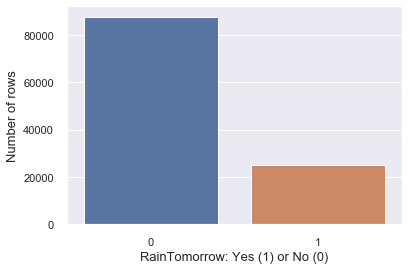

In [6]:
# The dataset is strongly umbalanced. To keep in mind for our model:
# - Add classweight parameters
# - Test the oversampling approach

fig,ax=plt.subplots()
sns.countplot(df.RainTomorrow,ax=ax)
ax.set_ylabel('Number of rows',fontsize=13)
ax.set_xlabel('RainTomorrow: Yes (1) or No (0)',fontsize=13)

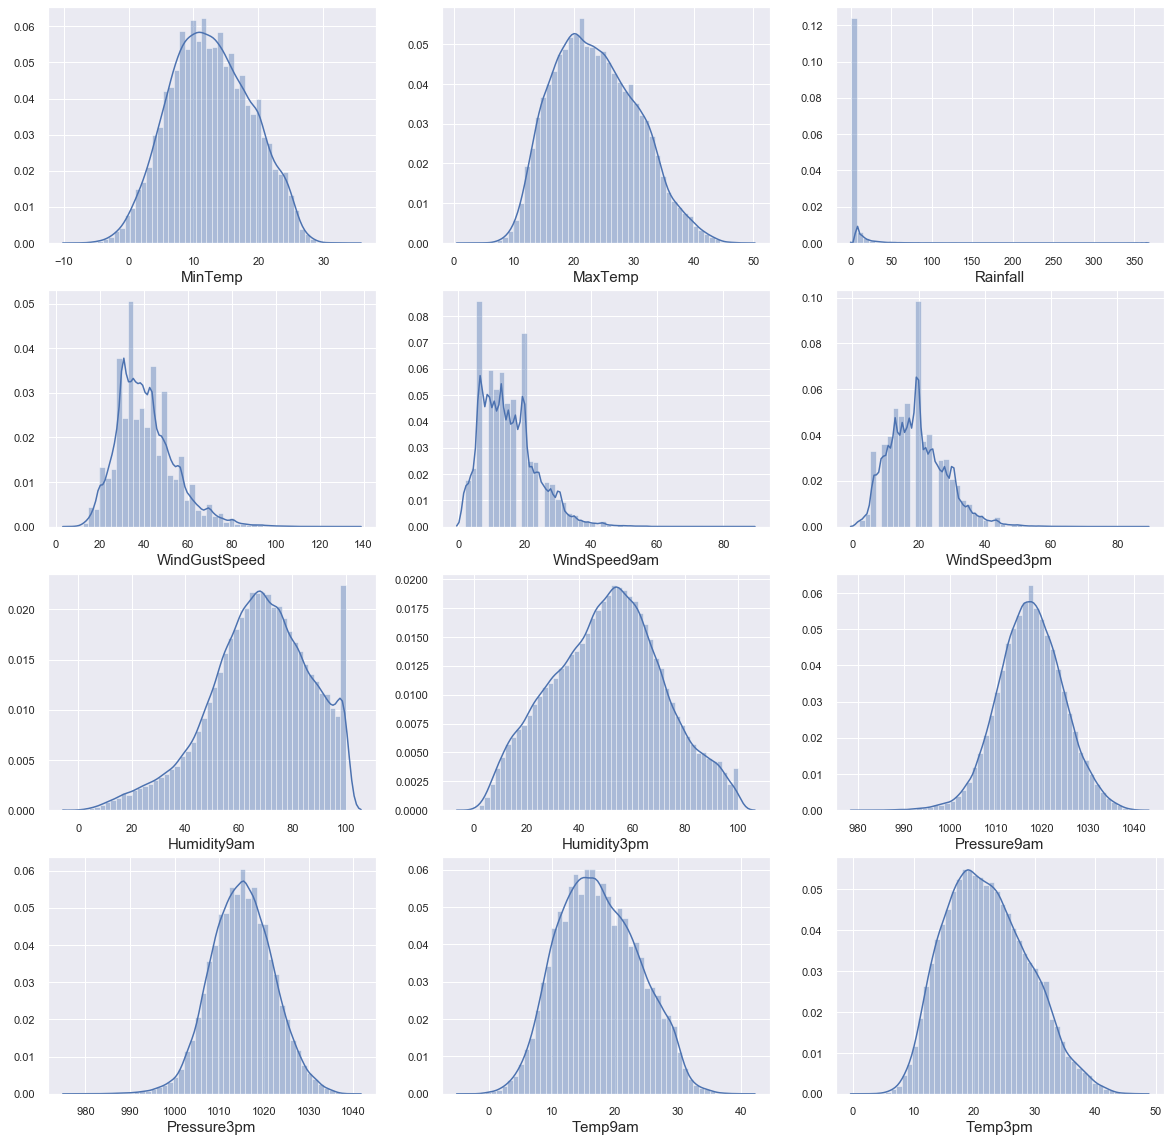

In [9]:
# Study features distribution

df_num = df.select_dtypes(exclude='object')

fig,ax = plt.subplots(4,3,figsize=(20,20))
for row in range(4):
    for col in range(3):
        sns.distplot(df_num.iloc[:,row*3+col],ax=ax[row,col])
        ax[row,col].set_xlabel(df_num.columns[row*3+col],fontsize=15)

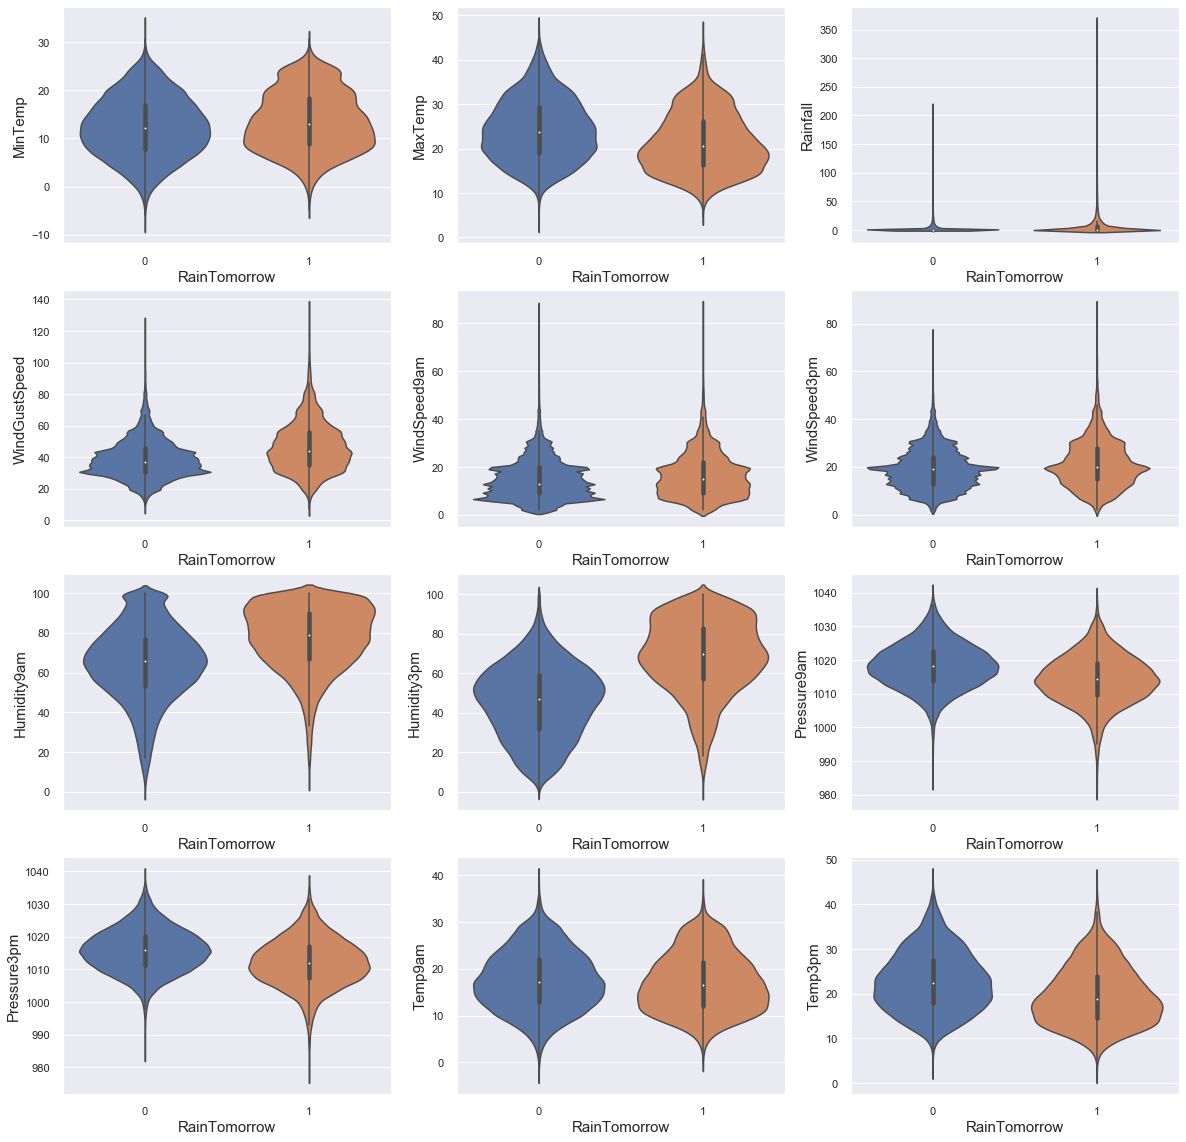

In [11]:
fig,ax = plt.subplots(4,3,figsize=(20,20))
for row in range(4):
    for col in range(3):
        sns.violinplot(x=df.RainTomorrow,y=df_num.iloc[:,row*3+col],ax=ax[row,col])
        ax[row,col].set_xlabel('RainTomorrow',fontsize=15)
        ax[row,col].set_ylabel(df_num.columns[row*3+col],fontsize=15)

The parameters that seem to influence RainTomorrow most are:
- Rainfall
- WindGustSpeed
- Humidity9am
- Humidity3pm

# Prepare train set

#### 1. Outliers

The distribution of 3 features is right-squewed, due to outliers. We will winsorize them (by [0%,0.01%]).

In [12]:
for col in ['Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm']:
    df[col] = winsorize(df[col],limits=[0,.01])

#### 2. Correlations

After studying the correlation matrix below, we will drop:
- MinTemp and MaxTemp (respectively correlated to Temp9am and Temp3pm)
- Pressure9am (correlated to Pressure3pm)
- RainToday (as it is also a measure of Rainfall)

(0, 14)

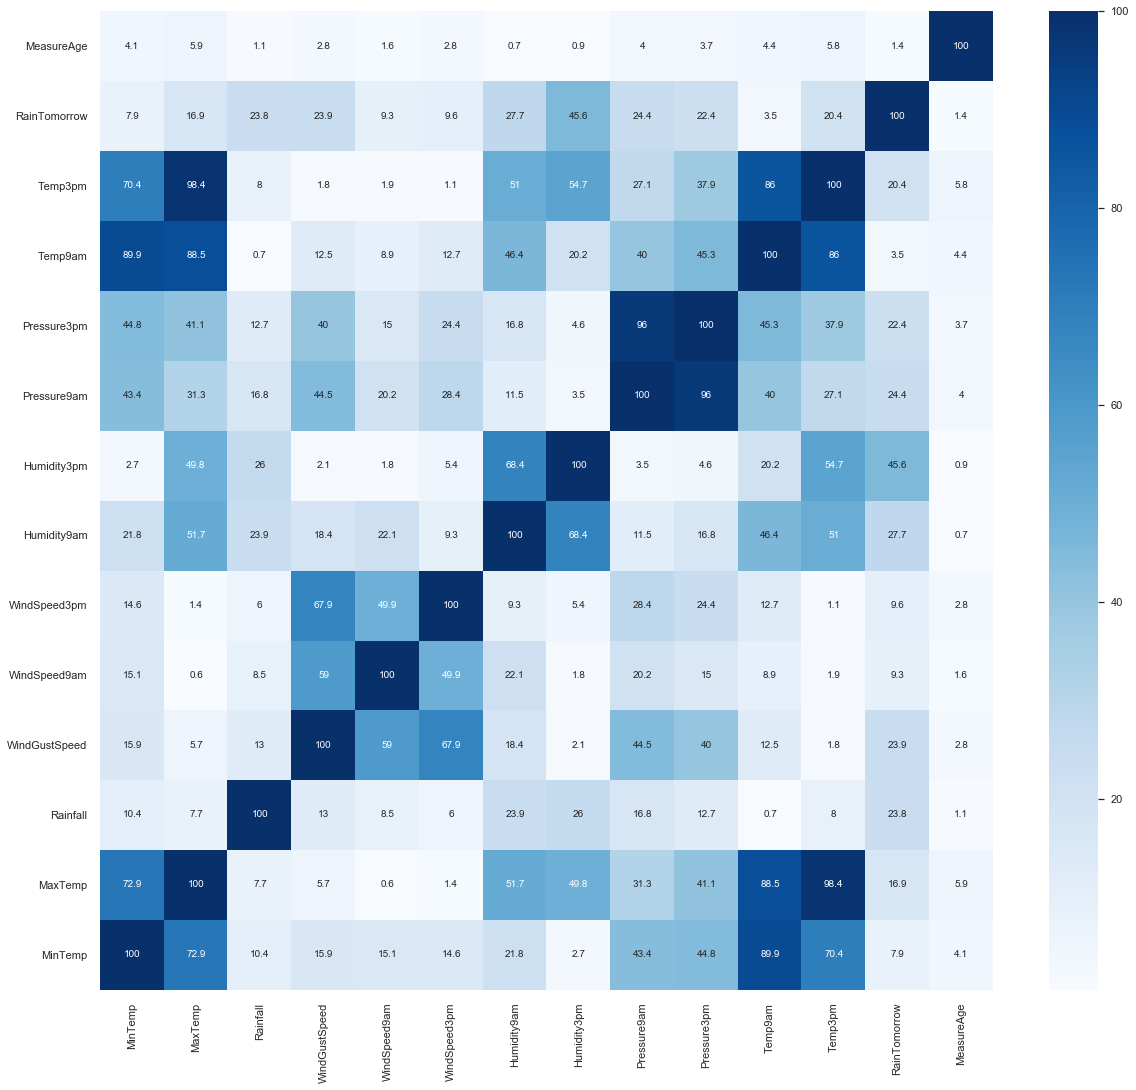

In [14]:
fig,ax = plt.subplots(figsize=(20,18))
ax = sns.heatmap(abs((df_num.corr()*100).round(1)),annot=True,cmap='Blues',fmt='g')
ax.set_ylim(0,14)

(0, 11)

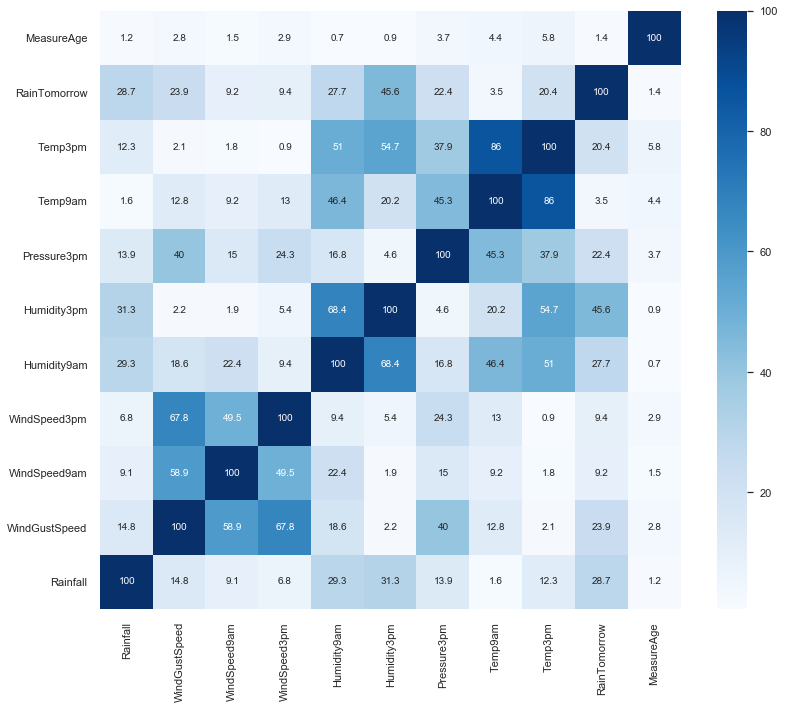

In [18]:
df.drop(['MinTemp','MaxTemp','Pressure9am'],axis=1,inplace=True)
df_num = df.select_dtypes(exclude='object')

fig,ax = plt.subplots(figsize=(13,11))
ax = sns.heatmap(abs((df_num.corr()*100).round(1)),annot=True,cmap='Blues',fmt='g')
ax.set_ylim(0,11)

#### 3. Dummies & scaling

In [19]:
dummy_cols = ['Location','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow']

categ_df = df[dummy_cols]
cont_df = df.drop(dummy_cols,axis=1)

categ_df = pd.get_dummies(categ_df,columns=dummy_cols,drop_first=True)
categ_df.rename(columns={'RainTomorrow_1':'RainTomorrow'},inplace=True)

scaler = StandardScaler()
cont_df = pd.DataFrame(scaler.fit_transform(cont_df),columns=cont_df.columns)

model_df = pd.concat([cont_df,categ_df],axis=1)

In [20]:
model_df.head()

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Temp9am,Temp3pm,MeasureAge,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainTomorrow
0,-0.253128,0.253403,0.596412,0.543288,0.190140,-1.380413,-1.142455,-0.088435,-0.047870,1.878666,...,0,0,0,0,0,0,0,1,0,0
1,-0.354292,0.253403,-1.363629,0.304814,-1.237561,-1.235963,-1.041848,-0.041228,0.317768,1.878666,...,0,0,0,0,0,0,0,0,1,0
2,-0.354292,0.407105,0.473909,0.781762,-1.554828,-0.995214,-0.912497,0.556724,0.156887,1.878666,...,0,0,0,0,0,0,0,0,1,0
3,-0.354292,-1.283619,-0.506111,-1.245267,-1.184683,-1.669313,-0.323229,0.100392,0.639531,1.878666,...,0,0,0,0,0,0,0,0,0,0
4,-0.185686,0.022849,-0.996121,0.066340,0.771796,-0.850764,-1.300551,0.053185,1.107548,1.878666,...,1,0,0,0,0,0,0,0,0,0


# Create clusters on wind-related columns

In [22]:
wind_cols = [col for col in model_df.columns if 'Wind' in col]

In [23]:
wind_df = model_df[wind_cols]

km = KMeans(n_clusters=4,n_jobs=-1,random_state=4)
km.fit(wind_df)
wind_df['WindCluster'] = km.labels_

with open ('wind_clustering_model', 'wb') as file :
    my_pickler = pickle.Pickler(file) 
    my_pickler.dump(km)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


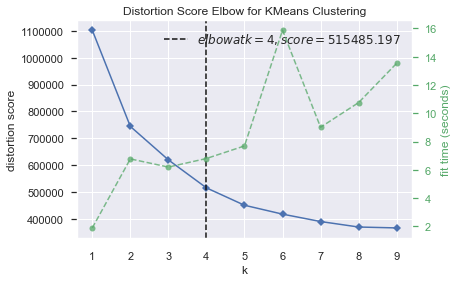

In [38]:
visualizer = KElbowVisualizer(km,k=(1,10))
visualizer.fit(wind_df)
visualizer.poof()

(0, 4)

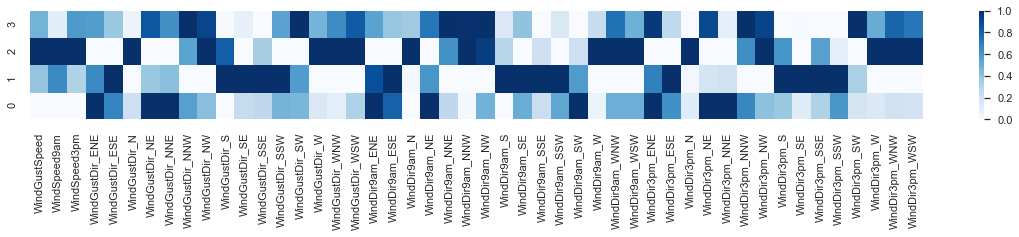

In [152]:
results_df = wind_df.groupby('WindCluster').agg('mean')
scaler = MinMaxScaler()
scaled_results_df = pd.DataFrame(scaler.fit_transform(results_df),columns=results_df.columns)

fig,ax = plt.subplots(figsize=(20,2))
ax = sns.heatmap(scaled_results_df,cmap='Blues',fmt='g')
ax.set_ylim(0,4)

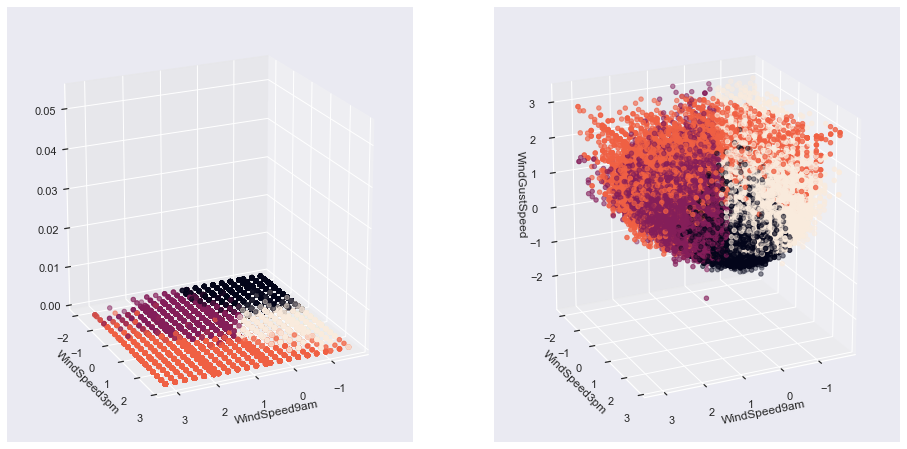

In [98]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(wind_df.WindSpeed9am,wind_df.WindSpeed3pm,c=wind_df.WindCluster)
ax1.set_xlabel('WindSpeed9am')
ax1.set_ylabel('WindSpeed3pm')
ax1.set_zlim(0)
ax1.view_init(elev=20,azim=65)

ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter(wind_df.WindSpeed9am,wind_df.WindSpeed3pm,wind_df.WindGustSpeed,c=wind_df.WindCluster)
ax2.set_xlabel('WindSpeed9am')
ax2.set_ylabel('WindSpeed3pm')
ax2.set_zlabel('WindGustSpeed')
ax2.view_init(elev=20,azim=65)

In [45]:
sil_score = silhouette_score(wind_df,labels=wind_df.WindCluster)
db_score = davies_bouldin_score(wind_df,labels=wind_df.WindCluster)

print(f'Silhouette score: {round(sil_score,2)}')
print(f'Davies-Bouldin score: {round(db_score,2)}')

Silhouette score: 0.21
Davies-Bouldin score: 1.66


In [24]:
clustered_wind_df = pd.concat([wind_df[['WindCluster']],
                         model_df[[col for col in model_df.columns if 'Wind' not in col]]],axis=1)
clustered_wind_df = pd.get_dummies(clustered_wind_df,columns=['WindCluster'],drop_first=True)
clustered_wind_df.head()

,Rainfall,Humidity9am,Humidity3pm,Pressure3pm,Temp9am,Temp3pm,MeasureAge,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,...,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,RainTomorrow,WindCluster_1,WindCluster_2,WindCluster_3
0,-0.253128,0.190140,-1.380413,-1.142455,-0.088435,-0.047870,1.878666,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.354292,-1.237561,-1.235963,-1.041848,-0.041228,0.317768,1.878666,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.354292,-1.554828,-0.995214,-0.912497,0.556724,0.156887,1.878666,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.354292,-1.184683,-1.669313,-0.323229,0.100392,0.639531,1.878666,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.185686,0.771796,-0.850764,-1.300551,0.053185,1.107548,1.878666,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Find the best model
### With clusters

#### 1. Create train and test sets

In [72]:
X = clustered_wind_df.drop('RainTomorrow',axis=1)
y = clustered_wind_df.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,stratify=y,random_state=42)

#### 2. Cross-validate models on the train set, to select the best performing one

In [94]:
metrics = ['roc_auc','accuracy','precision','recall','f1']

def append_model_perf(model,scores,df_scores):
    scores_lst = []
    for metric in metrics:
        scores_lst.append(round(np.mean(scores[f'test_{metric}'])*100,2))
    df_temp = pd.DataFrame(data=scores_lst, index=metrics, columns=[model]).T
    if df_scores.empty:
        return df_temp
    else:
        return pd.concat([df_scores,df_temp])
    
df_scores = pd.DataFrame()
cv = StratifiedKFold(n_splits=10, shuffle=False)

In [95]:
model = LogisticRegression()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('LogisticRegression',scores,df_scores)

In [96]:
model = LogisticRegression(class_weight='balanced')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('LogisticRegression (balanced)',scores,df_scores)

In [98]:
model = KNeighborsClassifier(weights='distance')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('KNeighborsClassifier (distance-based)',scores,df_scores)

In [99]:
model = GaussianNB()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('GaussianNB',scores,df_scores)

In [100]:
model = DecisionTreeClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('DecisionTreeClassifier',scores,df_scores)

In [101]:
model = RandomForestClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('RandomForestClassifier',scores,df_scores)

In [102]:
model = RandomForestClassifier(class_weight='balanced')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('RandomForestClassifier (balanced)',scores,df_scores)

In [103]:
model = CatBoostClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('CatBoostClassifier',scores,df_scores)

Learning rate set to 0.06247
0:	learn: 0.6482965	total: 24.9ms	remaining: 24.8s
1:	learn: 0.6088915	total: 46.6ms	remaining: 23.2s
2:	learn: 0.5776441	total: 72.2ms	remaining: 24s
3:	learn: 0.5494995	total: 105ms	remaining: 26.2s
4:	learn: 0.5241908	total: 124ms	remaining: 24.7s
5:	learn: 0.5029456	total: 145ms	remaining: 24.1s
6:	learn: 0.4869066	total: 168ms	remaining: 23.8s
7:	learn: 0.4721025	total: 196ms	remaining: 24.3s
8:	learn: 0.4583828	total: 227ms	remaining: 25s
9:	learn: 0.4471295	total: 254ms	remaining: 25.1s
10:	learn: 0.4382603	total: 274ms	remaining: 24.7s
11:	learn: 0.4291799	total: 293ms	remaining: 24.1s
12:	learn: 0.4215461	total: 316ms	remaining: 24s
13:	learn: 0.4151271	total: 335ms	remaining: 23.6s
14:	learn: 0.4094341	total: 357ms	remaining: 23.4s
15:	learn: 0.4047287	total: 380ms	remaining: 23.3s
16:	learn: 0.4001103	total: 410ms	remaining: 23.7s
17:	learn: 0.3963127	total: 444ms	remaining: 24.2s
18:	learn: 0.3930191	total: 467ms	remaining: 24.1s
19:	learn: 0.39

161:	learn: 0.3437795	total: 6.51s	remaining: 33.7s
162:	learn: 0.3436732	total: 6.56s	remaining: 33.7s
163:	learn: 0.3435697	total: 6.63s	remaining: 33.8s
164:	learn: 0.3434594	total: 6.75s	remaining: 34.2s
165:	learn: 0.3433659	total: 6.83s	remaining: 34.3s
166:	learn: 0.3432909	total: 6.85s	remaining: 34.2s
167:	learn: 0.3432066	total: 6.88s	remaining: 34.1s
168:	learn: 0.3430871	total: 6.9s	remaining: 33.9s
169:	learn: 0.3429625	total: 6.92s	remaining: 33.8s
170:	learn: 0.3428505	total: 6.95s	remaining: 33.7s
171:	learn: 0.3427460	total: 6.98s	remaining: 33.6s
172:	learn: 0.3426551	total: 7.01s	remaining: 33.5s
173:	learn: 0.3425614	total: 7.03s	remaining: 33.4s
174:	learn: 0.3424329	total: 7.06s	remaining: 33.3s
175:	learn: 0.3423312	total: 7.08s	remaining: 33.1s
176:	learn: 0.3422323	total: 7.1s	remaining: 33s
177:	learn: 0.3421074	total: 7.12s	remaining: 32.9s
178:	learn: 0.3420403	total: 7.15s	remaining: 32.8s
179:	learn: 0.3419233	total: 7.17s	remaining: 32.7s
180:	learn: 0.34

327:	learn: 0.3278908	total: 11.7s	remaining: 23.9s
328:	learn: 0.3278187	total: 11.7s	remaining: 23.8s
329:	learn: 0.3277448	total: 11.7s	remaining: 23.8s
330:	learn: 0.3276607	total: 11.7s	remaining: 23.7s
331:	learn: 0.3275973	total: 11.8s	remaining: 23.7s
332:	learn: 0.3275127	total: 11.8s	remaining: 23.6s
333:	learn: 0.3274239	total: 11.8s	remaining: 23.5s
334:	learn: 0.3273558	total: 11.8s	remaining: 23.5s
335:	learn: 0.3272765	total: 11.8s	remaining: 23.4s
336:	learn: 0.3272089	total: 11.9s	remaining: 23.4s
337:	learn: 0.3271038	total: 11.9s	remaining: 23.3s
338:	learn: 0.3270403	total: 11.9s	remaining: 23.3s
339:	learn: 0.3269752	total: 12s	remaining: 23.2s
340:	learn: 0.3268958	total: 12s	remaining: 23.2s
341:	learn: 0.3268161	total: 12s	remaining: 23.1s
342:	learn: 0.3267474	total: 12s	remaining: 23s
343:	learn: 0.3266731	total: 12.1s	remaining: 23s
344:	learn: 0.3266027	total: 12.1s	remaining: 22.9s
345:	learn: 0.3265378	total: 12.1s	remaining: 22.9s
346:	learn: 0.3264688	to

488:	learn: 0.3166700	total: 17.3s	remaining: 18s
489:	learn: 0.3166091	total: 17.3s	remaining: 18s
490:	learn: 0.3165496	total: 17.4s	remaining: 18s
491:	learn: 0.3164900	total: 17.4s	remaining: 18s
492:	learn: 0.3164458	total: 17.4s	remaining: 17.9s
493:	learn: 0.3164025	total: 17.5s	remaining: 17.9s
494:	learn: 0.3163161	total: 17.5s	remaining: 17.8s
495:	learn: 0.3162557	total: 17.5s	remaining: 17.8s
496:	learn: 0.3161929	total: 17.6s	remaining: 17.8s
497:	learn: 0.3161430	total: 17.6s	remaining: 17.7s
498:	learn: 0.3160668	total: 17.6s	remaining: 17.7s
499:	learn: 0.3160020	total: 17.6s	remaining: 17.6s
500:	learn: 0.3159698	total: 17.7s	remaining: 17.6s
501:	learn: 0.3159175	total: 17.7s	remaining: 17.5s
502:	learn: 0.3158460	total: 17.7s	remaining: 17.5s
503:	learn: 0.3157745	total: 17.7s	remaining: 17.5s
504:	learn: 0.3157049	total: 17.8s	remaining: 17.4s
505:	learn: 0.3156177	total: 17.8s	remaining: 17.4s
506:	learn: 0.3155528	total: 17.8s	remaining: 17.3s
507:	learn: 0.315484

648:	learn: 0.3075396	total: 21.9s	remaining: 11.8s
649:	learn: 0.3074897	total: 21.9s	remaining: 11.8s
650:	learn: 0.3074220	total: 22s	remaining: 11.8s
651:	learn: 0.3073754	total: 22s	remaining: 11.7s
652:	learn: 0.3073185	total: 22s	remaining: 11.7s
653:	learn: 0.3072805	total: 22s	remaining: 11.7s
654:	learn: 0.3072422	total: 22.1s	remaining: 11.6s
655:	learn: 0.3071962	total: 22.1s	remaining: 11.6s
656:	learn: 0.3071434	total: 22.2s	remaining: 11.6s
657:	learn: 0.3070774	total: 22.2s	remaining: 11.5s
658:	learn: 0.3070332	total: 22.2s	remaining: 11.5s
659:	learn: 0.3070044	total: 22.2s	remaining: 11.5s
660:	learn: 0.3069403	total: 22.3s	remaining: 11.4s
661:	learn: 0.3069012	total: 22.3s	remaining: 11.4s
662:	learn: 0.3068734	total: 22.4s	remaining: 11.4s
663:	learn: 0.3068153	total: 22.4s	remaining: 11.3s
664:	learn: 0.3067585	total: 22.4s	remaining: 11.3s
665:	learn: 0.3067152	total: 22.4s	remaining: 11.2s
666:	learn: 0.3066605	total: 22.5s	remaining: 11.2s
667:	learn: 0.306594

810:	learn: 0.2996795	total: 27.6s	remaining: 6.44s
811:	learn: 0.2996399	total: 27.7s	remaining: 6.41s
812:	learn: 0.2995743	total: 27.7s	remaining: 6.37s
813:	learn: 0.2995117	total: 27.7s	remaining: 6.33s
814:	learn: 0.2994667	total: 27.7s	remaining: 6.3s
815:	learn: 0.2994080	total: 27.8s	remaining: 6.26s
816:	learn: 0.2993715	total: 27.8s	remaining: 6.22s
817:	learn: 0.2993374	total: 27.8s	remaining: 6.19s
818:	learn: 0.2992795	total: 27.8s	remaining: 6.15s
819:	learn: 0.2992379	total: 27.9s	remaining: 6.12s
820:	learn: 0.2992025	total: 27.9s	remaining: 6.08s
821:	learn: 0.2991505	total: 27.9s	remaining: 6.05s
822:	learn: 0.2991091	total: 28s	remaining: 6.01s
823:	learn: 0.2990867	total: 28s	remaining: 5.98s
824:	learn: 0.2990383	total: 28s	remaining: 5.94s
825:	learn: 0.2989602	total: 28s	remaining: 5.91s
826:	learn: 0.2989294	total: 28.1s	remaining: 5.87s
827:	learn: 0.2988952	total: 28.1s	remaining: 5.84s
828:	learn: 0.2988554	total: 28.1s	remaining: 5.8s
829:	learn: 0.2988268	

975:	learn: 0.2922991	total: 31.9s	remaining: 786ms
976:	learn: 0.2922733	total: 32s	remaining: 753ms
977:	learn: 0.2922381	total: 32s	remaining: 720ms
978:	learn: 0.2922000	total: 32s	remaining: 687ms
979:	learn: 0.2921395	total: 32s	remaining: 654ms
980:	learn: 0.2921044	total: 32.1s	remaining: 621ms
981:	learn: 0.2920715	total: 32.1s	remaining: 588ms
982:	learn: 0.2920413	total: 32.1s	remaining: 555ms
983:	learn: 0.2920063	total: 32.1s	remaining: 522ms
984:	learn: 0.2919560	total: 32.2s	remaining: 490ms
985:	learn: 0.2919206	total: 32.2s	remaining: 457ms
986:	learn: 0.2918801	total: 32.2s	remaining: 424ms
987:	learn: 0.2918416	total: 32.3s	remaining: 392ms
988:	learn: 0.2917870	total: 32.3s	remaining: 359ms
989:	learn: 0.2917550	total: 32.3s	remaining: 326ms
990:	learn: 0.2917238	total: 32.3s	remaining: 294ms
991:	learn: 0.2916791	total: 32.3s	remaining: 261ms
992:	learn: 0.2916392	total: 32.4s	remaining: 228ms
993:	learn: 0.2915891	total: 32.4s	remaining: 196ms
994:	learn: 0.291535

136:	learn: 0.3469771	total: 6.04s	remaining: 38s
137:	learn: 0.3468314	total: 6.07s	remaining: 37.9s
138:	learn: 0.3467169	total: 6.1s	remaining: 37.8s
139:	learn: 0.3466190	total: 6.12s	remaining: 37.6s
140:	learn: 0.3464741	total: 6.14s	remaining: 37.4s
141:	learn: 0.3463473	total: 6.18s	remaining: 37.4s
142:	learn: 0.3462336	total: 6.23s	remaining: 37.3s
143:	learn: 0.3460980	total: 6.25s	remaining: 37.2s
144:	learn: 0.3460252	total: 6.3s	remaining: 37.1s
145:	learn: 0.3458707	total: 6.33s	remaining: 37.1s
146:	learn: 0.3457649	total: 6.38s	remaining: 37s
147:	learn: 0.3455835	total: 6.4s	remaining: 36.9s
148:	learn: 0.3454689	total: 6.42s	remaining: 36.7s
149:	learn: 0.3453638	total: 6.45s	remaining: 36.5s
150:	learn: 0.3452771	total: 6.48s	remaining: 36.4s
151:	learn: 0.3451837	total: 6.51s	remaining: 36.3s
152:	learn: 0.3450783	total: 6.54s	remaining: 36.2s
153:	learn: 0.3449935	total: 6.56s	remaining: 36.1s
154:	learn: 0.3448606	total: 6.59s	remaining: 35.9s
155:	learn: 0.34473

297:	learn: 0.3303129	total: 11.8s	remaining: 27.9s
298:	learn: 0.3302372	total: 11.9s	remaining: 27.9s
299:	learn: 0.3301529	total: 11.9s	remaining: 27.8s
300:	learn: 0.3300899	total: 11.9s	remaining: 27.7s
301:	learn: 0.3300325	total: 12s	remaining: 27.7s
302:	learn: 0.3299326	total: 12s	remaining: 27.6s
303:	learn: 0.3298625	total: 12.1s	remaining: 27.6s
304:	learn: 0.3297930	total: 12.1s	remaining: 27.6s
305:	learn: 0.3297091	total: 12.1s	remaining: 27.5s
306:	learn: 0.3296352	total: 12.2s	remaining: 27.4s
307:	learn: 0.3295449	total: 12.2s	remaining: 27.4s
308:	learn: 0.3294609	total: 12.2s	remaining: 27.3s
309:	learn: 0.3293731	total: 12.3s	remaining: 27.3s
310:	learn: 0.3292774	total: 12.3s	remaining: 27.3s
311:	learn: 0.3291673	total: 12.3s	remaining: 27.2s
312:	learn: 0.3290716	total: 12.4s	remaining: 27.2s
313:	learn: 0.3289929	total: 12.4s	remaining: 27.2s
314:	learn: 0.3289106	total: 12.5s	remaining: 27.1s
315:	learn: 0.3288013	total: 12.5s	remaining: 27.1s
316:	learn: 0.32

463:	learn: 0.3182853	total: 17s	remaining: 19.6s
464:	learn: 0.3182217	total: 17s	remaining: 19.5s
465:	learn: 0.3181687	total: 17s	remaining: 19.5s
466:	learn: 0.3180994	total: 17s	remaining: 19.4s
467:	learn: 0.3180161	total: 17.1s	remaining: 19.4s
468:	learn: 0.3179520	total: 17.1s	remaining: 19.4s
469:	learn: 0.3178913	total: 17.1s	remaining: 19.3s
470:	learn: 0.3178434	total: 17.2s	remaining: 19.3s
471:	learn: 0.3177793	total: 17.2s	remaining: 19.2s
472:	learn: 0.3177156	total: 17.2s	remaining: 19.2s
473:	learn: 0.3176664	total: 17.2s	remaining: 19.1s
474:	learn: 0.3176021	total: 17.3s	remaining: 19.1s
475:	learn: 0.3175217	total: 17.3s	remaining: 19s
476:	learn: 0.3174678	total: 17.3s	remaining: 19s
477:	learn: 0.3173956	total: 17.3s	remaining: 18.9s
478:	learn: 0.3173142	total: 17.4s	remaining: 18.9s
479:	learn: 0.3172410	total: 17.4s	remaining: 18.8s
480:	learn: 0.3171537	total: 17.4s	remaining: 18.8s
481:	learn: 0.3171039	total: 17.4s	remaining: 18.7s
482:	learn: 0.3170412	to

624:	learn: 0.3087394	total: 21.9s	remaining: 13.1s
625:	learn: 0.3086796	total: 21.9s	remaining: 13.1s
626:	learn: 0.3086311	total: 22s	remaining: 13.1s
627:	learn: 0.3086036	total: 22s	remaining: 13s
628:	learn: 0.3085605	total: 22.1s	remaining: 13s
629:	learn: 0.3085194	total: 22.1s	remaining: 13s
630:	learn: 0.3084584	total: 22.1s	remaining: 12.9s
631:	learn: 0.3083980	total: 22.2s	remaining: 12.9s
632:	learn: 0.3083375	total: 22.2s	remaining: 12.9s
633:	learn: 0.3082886	total: 22.2s	remaining: 12.8s
634:	learn: 0.3082443	total: 22.3s	remaining: 12.8s
635:	learn: 0.3081971	total: 22.3s	remaining: 12.8s
636:	learn: 0.3081431	total: 22.4s	remaining: 12.8s
637:	learn: 0.3080815	total: 22.4s	remaining: 12.7s
638:	learn: 0.3080222	total: 22.5s	remaining: 12.7s
639:	learn: 0.3079679	total: 22.5s	remaining: 12.7s
640:	learn: 0.3079115	total: 22.6s	remaining: 12.7s
641:	learn: 0.3078598	total: 22.6s	remaining: 12.6s
642:	learn: 0.3078206	total: 22.7s	remaining: 12.6s
643:	learn: 0.3077677	

783:	learn: 0.3009850	total: 27.2s	remaining: 7.5s
784:	learn: 0.3009333	total: 27.3s	remaining: 7.47s
785:	learn: 0.3008930	total: 27.3s	remaining: 7.43s
786:	learn: 0.3008334	total: 27.3s	remaining: 7.4s
787:	learn: 0.3007753	total: 27.4s	remaining: 7.36s
788:	learn: 0.3007142	total: 27.4s	remaining: 7.33s
789:	learn: 0.3006529	total: 27.4s	remaining: 7.29s
790:	learn: 0.3005982	total: 27.5s	remaining: 7.26s
791:	learn: 0.3005664	total: 27.5s	remaining: 7.22s
792:	learn: 0.3005214	total: 27.5s	remaining: 7.18s
793:	learn: 0.3004828	total: 27.5s	remaining: 7.15s
794:	learn: 0.3004433	total: 27.6s	remaining: 7.11s
795:	learn: 0.3003921	total: 27.6s	remaining: 7.07s
796:	learn: 0.3003547	total: 27.6s	remaining: 7.04s
797:	learn: 0.3003283	total: 27.7s	remaining: 7.01s
798:	learn: 0.3002871	total: 27.7s	remaining: 6.97s
799:	learn: 0.3002381	total: 27.7s	remaining: 6.93s
800:	learn: 0.3002083	total: 27.8s	remaining: 6.89s
801:	learn: 0.3001569	total: 27.8s	remaining: 6.86s
802:	learn: 0.

944:	learn: 0.2936768	total: 32.3s	remaining: 1.88s
945:	learn: 0.2936175	total: 32.4s	remaining: 1.85s
946:	learn: 0.2935612	total: 32.4s	remaining: 1.81s
947:	learn: 0.2935214	total: 32.5s	remaining: 1.78s
948:	learn: 0.2935014	total: 32.5s	remaining: 1.75s
949:	learn: 0.2934498	total: 32.6s	remaining: 1.71s
950:	learn: 0.2934099	total: 32.6s	remaining: 1.68s
951:	learn: 0.2933536	total: 32.6s	remaining: 1.65s
952:	learn: 0.2933087	total: 32.7s	remaining: 1.61s
953:	learn: 0.2932733	total: 32.7s	remaining: 1.58s
954:	learn: 0.2932173	total: 32.8s	remaining: 1.54s
955:	learn: 0.2931628	total: 32.9s	remaining: 1.51s
956:	learn: 0.2931238	total: 33s	remaining: 1.48s
957:	learn: 0.2930872	total: 33s	remaining: 1.45s
958:	learn: 0.2930420	total: 33.1s	remaining: 1.41s
959:	learn: 0.2930115	total: 33.1s	remaining: 1.38s
960:	learn: 0.2929559	total: 33.2s	remaining: 1.35s
961:	learn: 0.2929231	total: 33.2s	remaining: 1.31s
962:	learn: 0.2928935	total: 33.3s	remaining: 1.28s
963:	learn: 0.29

106:	learn: 0.3500206	total: 3.33s	remaining: 27.8s
107:	learn: 0.3498394	total: 3.36s	remaining: 27.8s
108:	learn: 0.3497006	total: 3.4s	remaining: 27.8s
109:	learn: 0.3495854	total: 3.43s	remaining: 27.7s
110:	learn: 0.3494651	total: 3.45s	remaining: 27.6s
111:	learn: 0.3493273	total: 3.48s	remaining: 27.6s
112:	learn: 0.3492263	total: 3.5s	remaining: 27.5s
113:	learn: 0.3491040	total: 3.52s	remaining: 27.4s
114:	learn: 0.3490032	total: 3.55s	remaining: 27.3s
115:	learn: 0.3488349	total: 3.58s	remaining: 27.3s
116:	learn: 0.3487373	total: 3.6s	remaining: 27.2s
117:	learn: 0.3486296	total: 3.63s	remaining: 27.1s
118:	learn: 0.3484302	total: 3.65s	remaining: 27s
119:	learn: 0.3483618	total: 3.7s	remaining: 27.1s
120:	learn: 0.3482346	total: 3.72s	remaining: 27s
121:	learn: 0.3481244	total: 3.74s	remaining: 26.9s
122:	learn: 0.3480473	total: 3.77s	remaining: 26.9s
123:	learn: 0.3479106	total: 3.8s	remaining: 26.9s
124:	learn: 0.3477188	total: 3.83s	remaining: 26.8s
125:	learn: 0.3476208

265:	learn: 0.3327478	total: 8.4s	remaining: 23.2s
266:	learn: 0.3326431	total: 8.45s	remaining: 23.2s
267:	learn: 0.3325711	total: 8.49s	remaining: 23.2s
268:	learn: 0.3324613	total: 8.54s	remaining: 23.2s
269:	learn: 0.3323742	total: 8.58s	remaining: 23.2s
270:	learn: 0.3322644	total: 8.69s	remaining: 23.4s
271:	learn: 0.3321789	total: 8.72s	remaining: 23.3s
272:	learn: 0.3320664	total: 8.76s	remaining: 23.3s
273:	learn: 0.3319602	total: 8.8s	remaining: 23.3s
274:	learn: 0.3318632	total: 8.83s	remaining: 23.3s
275:	learn: 0.3317473	total: 8.88s	remaining: 23.3s
276:	learn: 0.3316589	total: 8.94s	remaining: 23.3s
277:	learn: 0.3315408	total: 8.98s	remaining: 23.3s
278:	learn: 0.3314441	total: 9.03s	remaining: 23.3s
279:	learn: 0.3313363	total: 9.06s	remaining: 23.3s
280:	learn: 0.3312638	total: 9.11s	remaining: 23.3s
281:	learn: 0.3311666	total: 9.15s	remaining: 23.3s
282:	learn: 0.3310817	total: 9.21s	remaining: 23.3s
283:	learn: 0.3309557	total: 9.27s	remaining: 23.4s
284:	learn: 0.

431:	learn: 0.3195716	total: 13.8s	remaining: 18.2s
432:	learn: 0.3195070	total: 13.9s	remaining: 18.1s
433:	learn: 0.3194619	total: 13.9s	remaining: 18.1s
434:	learn: 0.3193816	total: 13.9s	remaining: 18.1s
435:	learn: 0.3193273	total: 14s	remaining: 18s
436:	learn: 0.3192693	total: 14s	remaining: 18s
437:	learn: 0.3192044	total: 14s	remaining: 18s
438:	learn: 0.3191367	total: 14s	remaining: 17.9s
439:	learn: 0.3190479	total: 14.1s	remaining: 17.9s
440:	learn: 0.3189591	total: 14.1s	remaining: 17.8s
441:	learn: 0.3189173	total: 14.1s	remaining: 17.8s
442:	learn: 0.3188617	total: 14.1s	remaining: 17.8s
443:	learn: 0.3187934	total: 14.2s	remaining: 17.7s
444:	learn: 0.3187158	total: 14.2s	remaining: 17.7s
445:	learn: 0.3186442	total: 14.2s	remaining: 17.7s
446:	learn: 0.3185700	total: 14.2s	remaining: 17.6s
447:	learn: 0.3184958	total: 14.3s	remaining: 17.6s
448:	learn: 0.3184146	total: 14.3s	remaining: 17.5s
449:	learn: 0.3183444	total: 14.3s	remaining: 17.5s
450:	learn: 0.3182961	tota

594:	learn: 0.3095464	total: 19s	remaining: 12.9s
595:	learn: 0.3094977	total: 19s	remaining: 12.9s
596:	learn: 0.3094462	total: 19s	remaining: 12.8s
597:	learn: 0.3094007	total: 19.1s	remaining: 12.8s
598:	learn: 0.3093615	total: 19.1s	remaining: 12.8s
599:	learn: 0.3092820	total: 19.1s	remaining: 12.7s
600:	learn: 0.3092300	total: 19.2s	remaining: 12.7s
601:	learn: 0.3091769	total: 19.2s	remaining: 12.7s
602:	learn: 0.3091254	total: 19.2s	remaining: 12.7s
603:	learn: 0.3090702	total: 19.3s	remaining: 12.6s
604:	learn: 0.3090050	total: 19.3s	remaining: 12.6s
605:	learn: 0.3089736	total: 19.3s	remaining: 12.6s
606:	learn: 0.3089180	total: 19.4s	remaining: 12.6s
607:	learn: 0.3088433	total: 19.4s	remaining: 12.5s
608:	learn: 0.3087819	total: 19.5s	remaining: 12.5s
609:	learn: 0.3087454	total: 19.5s	remaining: 12.5s
610:	learn: 0.3086675	total: 19.5s	remaining: 12.4s
611:	learn: 0.3085987	total: 19.6s	remaining: 12.4s
612:	learn: 0.3085119	total: 19.6s	remaining: 12.4s
613:	learn: 0.3084

755:	learn: 0.3013154	total: 23.8s	remaining: 7.7s
756:	learn: 0.3013068	total: 23.9s	remaining: 7.67s
757:	learn: 0.3012682	total: 23.9s	remaining: 7.63s
758:	learn: 0.3012264	total: 24s	remaining: 7.61s
759:	learn: 0.3011825	total: 24s	remaining: 7.57s
760:	learn: 0.3011464	total: 24s	remaining: 7.54s
761:	learn: 0.3010948	total: 24s	remaining: 7.5s
762:	learn: 0.3010471	total: 24.1s	remaining: 7.47s
763:	learn: 0.3010053	total: 24.1s	remaining: 7.44s
764:	learn: 0.3009500	total: 24.1s	remaining: 7.4s
765:	learn: 0.3009098	total: 24.1s	remaining: 7.37s
766:	learn: 0.3008701	total: 24.1s	remaining: 7.33s
767:	learn: 0.3008127	total: 24.2s	remaining: 7.3s
768:	learn: 0.3007652	total: 24.2s	remaining: 7.27s
769:	learn: 0.3007229	total: 24.2s	remaining: 7.23s
770:	learn: 0.3006923	total: 24.2s	remaining: 7.2s
771:	learn: 0.3006634	total: 24.3s	remaining: 7.17s
772:	learn: 0.3006292	total: 24.3s	remaining: 7.14s
773:	learn: 0.3005875	total: 24.3s	remaining: 7.11s
774:	learn: 0.3005316	tot

917:	learn: 0.2942311	total: 28.8s	remaining: 2.57s
918:	learn: 0.2941461	total: 28.8s	remaining: 2.54s
919:	learn: 0.2940926	total: 28.9s	remaining: 2.51s
920:	learn: 0.2940527	total: 28.9s	remaining: 2.48s
921:	learn: 0.2940055	total: 28.9s	remaining: 2.45s
922:	learn: 0.2939431	total: 29s	remaining: 2.42s
923:	learn: 0.2938913	total: 29s	remaining: 2.39s
924:	learn: 0.2938527	total: 29.1s	remaining: 2.36s
925:	learn: 0.2938061	total: 29.1s	remaining: 2.33s
926:	learn: 0.2937607	total: 29.1s	remaining: 2.29s
927:	learn: 0.2937199	total: 29.2s	remaining: 2.26s
928:	learn: 0.2936847	total: 29.2s	remaining: 2.23s
929:	learn: 0.2936448	total: 29.2s	remaining: 2.2s
930:	learn: 0.2936023	total: 29.3s	remaining: 2.17s
931:	learn: 0.2935638	total: 29.3s	remaining: 2.14s
932:	learn: 0.2935021	total: 29.3s	remaining: 2.11s
933:	learn: 0.2934524	total: 29.4s	remaining: 2.08s
934:	learn: 0.2934072	total: 29.5s	remaining: 2.05s
935:	learn: 0.2933517	total: 29.5s	remaining: 2.02s
936:	learn: 0.293

81:	learn: 0.3541300	total: 2.34s	remaining: 26.2s
82:	learn: 0.3539864	total: 2.38s	remaining: 26.2s
83:	learn: 0.3538258	total: 2.4s	remaining: 26.2s
84:	learn: 0.3536882	total: 2.42s	remaining: 26.1s
85:	learn: 0.3534915	total: 2.44s	remaining: 26s
86:	learn: 0.3533134	total: 2.47s	remaining: 25.9s
87:	learn: 0.3531658	total: 2.49s	remaining: 25.8s
88:	learn: 0.3529352	total: 2.51s	remaining: 25.7s
89:	learn: 0.3528141	total: 2.53s	remaining: 25.6s
90:	learn: 0.3526082	total: 2.56s	remaining: 25.6s
91:	learn: 0.3524928	total: 2.59s	remaining: 25.6s
92:	learn: 0.3523525	total: 2.61s	remaining: 25.5s
93:	learn: 0.3521548	total: 2.64s	remaining: 25.4s
94:	learn: 0.3520289	total: 2.66s	remaining: 25.3s
95:	learn: 0.3518986	total: 2.69s	remaining: 25.3s
96:	learn: 0.3517593	total: 2.72s	remaining: 25.3s
97:	learn: 0.3516401	total: 2.74s	remaining: 25.2s
98:	learn: 0.3514574	total: 2.77s	remaining: 25.3s
99:	learn: 0.3512814	total: 2.82s	remaining: 25.4s
100:	learn: 0.3510771	total: 2.84s

242:	learn: 0.3350500	total: 7.27s	remaining: 22.6s
243:	learn: 0.3349491	total: 7.31s	remaining: 22.7s
244:	learn: 0.3348490	total: 7.35s	remaining: 22.7s
245:	learn: 0.3347522	total: 7.4s	remaining: 22.7s
246:	learn: 0.3346538	total: 7.44s	remaining: 22.7s
247:	learn: 0.3345793	total: 7.51s	remaining: 22.8s
248:	learn: 0.3344722	total: 7.55s	remaining: 22.8s
249:	learn: 0.3343865	total: 7.58s	remaining: 22.8s
250:	learn: 0.3343009	total: 7.63s	remaining: 22.8s
251:	learn: 0.3342048	total: 7.69s	remaining: 22.8s
252:	learn: 0.3340966	total: 7.73s	remaining: 22.8s
253:	learn: 0.3339765	total: 7.77s	remaining: 22.8s
254:	learn: 0.3338579	total: 7.8s	remaining: 22.8s
255:	learn: 0.3337394	total: 7.83s	remaining: 22.8s
256:	learn: 0.3336433	total: 7.87s	remaining: 22.8s
257:	learn: 0.3335646	total: 7.9s	remaining: 22.7s
258:	learn: 0.3334644	total: 7.95s	remaining: 22.7s
259:	learn: 0.3333589	total: 7.98s	remaining: 22.7s
260:	learn: 0.3332861	total: 8.02s	remaining: 22.7s
261:	learn: 0.3

402:	learn: 0.3218925	total: 12s	remaining: 17.7s
403:	learn: 0.3218105	total: 12s	remaining: 17.7s
404:	learn: 0.3217657	total: 12s	remaining: 17.6s
405:	learn: 0.3216895	total: 12s	remaining: 17.6s
406:	learn: 0.3216435	total: 12.1s	remaining: 17.6s
407:	learn: 0.3215745	total: 12.1s	remaining: 17.5s
408:	learn: 0.3214760	total: 12.1s	remaining: 17.5s
409:	learn: 0.3213857	total: 12.1s	remaining: 17.4s
410:	learn: 0.3213311	total: 12.1s	remaining: 17.4s
411:	learn: 0.3212650	total: 12.2s	remaining: 17.4s
412:	learn: 0.3211983	total: 12.2s	remaining: 17.3s
413:	learn: 0.3210954	total: 12.2s	remaining: 17.3s
414:	learn: 0.3210195	total: 12.2s	remaining: 17.3s
415:	learn: 0.3209207	total: 12.3s	remaining: 17.2s
416:	learn: 0.3208580	total: 12.3s	remaining: 17.2s
417:	learn: 0.3207866	total: 12.3s	remaining: 17.1s
418:	learn: 0.3207308	total: 12.3s	remaining: 17.1s
419:	learn: 0.3206706	total: 12.4s	remaining: 17.1s
420:	learn: 0.3205936	total: 12.4s	remaining: 17s
421:	learn: 0.3205231	

562:	learn: 0.3118388	total: 16.4s	remaining: 12.7s
563:	learn: 0.3117824	total: 16.4s	remaining: 12.7s
564:	learn: 0.3117527	total: 16.5s	remaining: 12.7s
565:	learn: 0.3117246	total: 16.5s	remaining: 12.6s
566:	learn: 0.3116596	total: 16.5s	remaining: 12.6s
567:	learn: 0.3115889	total: 16.5s	remaining: 12.6s
568:	learn: 0.3115329	total: 16.6s	remaining: 12.6s
569:	learn: 0.3114756	total: 16.6s	remaining: 12.5s
570:	learn: 0.3114342	total: 16.6s	remaining: 12.5s
571:	learn: 0.3113817	total: 16.7s	remaining: 12.5s
572:	learn: 0.3113150	total: 16.7s	remaining: 12.4s
573:	learn: 0.3112626	total: 16.7s	remaining: 12.4s
574:	learn: 0.3112030	total: 16.8s	remaining: 12.4s
575:	learn: 0.3111401	total: 16.8s	remaining: 12.4s
576:	learn: 0.3111048	total: 16.8s	remaining: 12.4s
577:	learn: 0.3110331	total: 16.9s	remaining: 12.3s
578:	learn: 0.3109579	total: 16.9s	remaining: 12.3s
579:	learn: 0.3109005	total: 17s	remaining: 12.3s
580:	learn: 0.3108436	total: 17s	remaining: 12.3s
581:	learn: 0.31

723:	learn: 0.3034199	total: 22.1s	remaining: 8.44s
724:	learn: 0.3033614	total: 22.2s	remaining: 8.41s
725:	learn: 0.3033082	total: 22.2s	remaining: 8.38s
726:	learn: 0.3032656	total: 22.2s	remaining: 8.35s
727:	learn: 0.3032218	total: 22.3s	remaining: 8.31s
728:	learn: 0.3032007	total: 22.3s	remaining: 8.28s
729:	learn: 0.3031513	total: 22.3s	remaining: 8.25s
730:	learn: 0.3030940	total: 22.3s	remaining: 8.21s
731:	learn: 0.3030531	total: 22.4s	remaining: 8.18s
732:	learn: 0.3030069	total: 22.4s	remaining: 8.16s
733:	learn: 0.3029611	total: 22.4s	remaining: 8.12s
734:	learn: 0.3029163	total: 22.4s	remaining: 8.09s
735:	learn: 0.3028671	total: 22.5s	remaining: 8.06s
736:	learn: 0.3028198	total: 22.5s	remaining: 8.03s
737:	learn: 0.3028122	total: 22.5s	remaining: 8s
738:	learn: 0.3028051	total: 22.6s	remaining: 7.97s
739:	learn: 0.3027410	total: 22.6s	remaining: 7.94s
740:	learn: 0.3026817	total: 22.6s	remaining: 7.91s
741:	learn: 0.3026336	total: 22.7s	remaining: 7.88s
742:	learn: 0.3

887:	learn: 0.2956230	total: 27s	remaining: 3.4s
888:	learn: 0.2955646	total: 27s	remaining: 3.37s
889:	learn: 0.2955298	total: 27s	remaining: 3.34s
890:	learn: 0.2954852	total: 27.1s	remaining: 3.31s
891:	learn: 0.2954573	total: 27.1s	remaining: 3.28s
892:	learn: 0.2954088	total: 27.1s	remaining: 3.25s
893:	learn: 0.2953701	total: 27.2s	remaining: 3.22s
894:	learn: 0.2953349	total: 27.2s	remaining: 3.19s
895:	learn: 0.2952738	total: 27.2s	remaining: 3.16s
896:	learn: 0.2952190	total: 27.3s	remaining: 3.13s
897:	learn: 0.2951533	total: 27.3s	remaining: 3.1s
898:	learn: 0.2951136	total: 27.4s	remaining: 3.08s
899:	learn: 0.2950973	total: 27.4s	remaining: 3.05s
900:	learn: 0.2950581	total: 27.5s	remaining: 3.02s
901:	learn: 0.2950212	total: 27.5s	remaining: 2.99s
902:	learn: 0.2949550	total: 27.5s	remaining: 2.96s
903:	learn: 0.2948843	total: 27.6s	remaining: 2.93s
904:	learn: 0.2948436	total: 27.6s	remaining: 2.9s
905:	learn: 0.2948094	total: 27.6s	remaining: 2.87s
906:	learn: 0.2947546

48:	learn: 0.3612337	total: 1.32s	remaining: 25.7s
49:	learn: 0.3608545	total: 1.35s	remaining: 25.7s
50:	learn: 0.3604372	total: 1.38s	remaining: 25.7s
51:	learn: 0.3601556	total: 1.41s	remaining: 25.7s
52:	learn: 0.3598956	total: 1.44s	remaining: 25.7s
53:	learn: 0.3596125	total: 1.52s	remaining: 26.7s
54:	learn: 0.3593322	total: 1.58s	remaining: 27.2s
55:	learn: 0.3590213	total: 1.62s	remaining: 27.4s
56:	learn: 0.3586733	total: 1.65s	remaining: 27.3s
57:	learn: 0.3584342	total: 1.7s	remaining: 27.6s
58:	learn: 0.3582038	total: 1.74s	remaining: 27.8s
59:	learn: 0.3578456	total: 1.78s	remaining: 27.9s
60:	learn: 0.3575982	total: 1.81s	remaining: 27.8s
61:	learn: 0.3573944	total: 1.84s	remaining: 27.9s
62:	learn: 0.3571845	total: 1.87s	remaining: 27.8s
63:	learn: 0.3569609	total: 1.9s	remaining: 27.7s
64:	learn: 0.3567721	total: 1.92s	remaining: 27.6s
65:	learn: 0.3566114	total: 1.94s	remaining: 27.5s
66:	learn: 0.3563254	total: 1.98s	remaining: 27.5s
67:	learn: 0.3561374	total: 2s	re

212:	learn: 0.3376349	total: 5.86s	remaining: 21.7s
213:	learn: 0.3375336	total: 5.89s	remaining: 21.6s
214:	learn: 0.3374430	total: 5.91s	remaining: 21.6s
215:	learn: 0.3373238	total: 5.94s	remaining: 21.6s
216:	learn: 0.3371894	total: 5.97s	remaining: 21.6s
217:	learn: 0.3370310	total: 6.02s	remaining: 21.6s
218:	learn: 0.3369443	total: 6.07s	remaining: 21.7s
219:	learn: 0.3368629	total: 6.13s	remaining: 21.7s
220:	learn: 0.3367401	total: 6.18s	remaining: 21.8s
221:	learn: 0.3365986	total: 6.22s	remaining: 21.8s
222:	learn: 0.3364963	total: 6.27s	remaining: 21.8s
223:	learn: 0.3363816	total: 6.32s	remaining: 21.9s
224:	learn: 0.3362576	total: 6.36s	remaining: 21.9s
225:	learn: 0.3361719	total: 6.4s	remaining: 21.9s
226:	learn: 0.3360983	total: 6.45s	remaining: 22s
227:	learn: 0.3359777	total: 6.49s	remaining: 22s
228:	learn: 0.3358723	total: 6.54s	remaining: 22s
229:	learn: 0.3357563	total: 6.58s	remaining: 22s
230:	learn: 0.3356641	total: 6.61s	remaining: 22s
231:	learn: 0.3355390	t

372:	learn: 0.3235825	total: 11.9s	remaining: 20s
373:	learn: 0.3235289	total: 11.9s	remaining: 20s
374:	learn: 0.3234659	total: 12s	remaining: 19.9s
375:	learn: 0.3234012	total: 12s	remaining: 19.9s
376:	learn: 0.3233375	total: 12s	remaining: 19.8s
377:	learn: 0.3232653	total: 12s	remaining: 19.8s
378:	learn: 0.3231963	total: 12.1s	remaining: 19.8s
379:	learn: 0.3231216	total: 12.1s	remaining: 19.7s
380:	learn: 0.3230396	total: 12.1s	remaining: 19.7s
381:	learn: 0.3229959	total: 12.2s	remaining: 19.7s
382:	learn: 0.3229140	total: 12.2s	remaining: 19.6s
383:	learn: 0.3228535	total: 12.2s	remaining: 19.6s
384:	learn: 0.3227760	total: 12.2s	remaining: 19.6s
385:	learn: 0.3227057	total: 12.3s	remaining: 19.5s
386:	learn: 0.3226037	total: 12.3s	remaining: 19.5s
387:	learn: 0.3225180	total: 12.3s	remaining: 19.5s
388:	learn: 0.3224429	total: 12.4s	remaining: 19.4s
389:	learn: 0.3223862	total: 12.4s	remaining: 19.4s
390:	learn: 0.3222989	total: 12.4s	remaining: 19.4s
391:	learn: 0.3222111	to

532:	learn: 0.3129012	total: 17s	remaining: 14.9s
533:	learn: 0.3128491	total: 17.1s	remaining: 14.9s
534:	learn: 0.3127951	total: 17.1s	remaining: 14.9s
535:	learn: 0.3127566	total: 17.2s	remaining: 14.9s
536:	learn: 0.3126947	total: 17.2s	remaining: 14.8s
537:	learn: 0.3126344	total: 17.3s	remaining: 14.8s
538:	learn: 0.3125956	total: 17.3s	remaining: 14.8s
539:	learn: 0.3125625	total: 17.4s	remaining: 14.8s
540:	learn: 0.3124888	total: 17.6s	remaining: 14.9s
541:	learn: 0.3124488	total: 17.6s	remaining: 14.9s
542:	learn: 0.3123728	total: 17.7s	remaining: 14.9s
543:	learn: 0.3123171	total: 17.7s	remaining: 14.8s
544:	learn: 0.3122446	total: 17.7s	remaining: 14.8s
545:	learn: 0.3122018	total: 17.8s	remaining: 14.8s
546:	learn: 0.3121402	total: 17.8s	remaining: 14.8s
547:	learn: 0.3120815	total: 17.9s	remaining: 14.7s
548:	learn: 0.3120310	total: 17.9s	remaining: 14.7s
549:	learn: 0.3119778	total: 17.9s	remaining: 14.7s
550:	learn: 0.3119251	total: 18s	remaining: 14.7s
551:	learn: 0.31

695:	learn: 0.3043198	total: 22.7s	remaining: 9.91s
696:	learn: 0.3042401	total: 22.7s	remaining: 9.87s
697:	learn: 0.3041855	total: 22.7s	remaining: 9.84s
698:	learn: 0.3041408	total: 22.8s	remaining: 9.8s
699:	learn: 0.3040950	total: 22.8s	remaining: 9.77s
700:	learn: 0.3040315	total: 22.8s	remaining: 9.73s
701:	learn: 0.3039831	total: 22.8s	remaining: 9.7s
702:	learn: 0.3039460	total: 22.9s	remaining: 9.66s
703:	learn: 0.3039167	total: 22.9s	remaining: 9.63s
704:	learn: 0.3038610	total: 22.9s	remaining: 9.59s
705:	learn: 0.3038176	total: 23s	remaining: 9.56s
706:	learn: 0.3037458	total: 23s	remaining: 9.53s
707:	learn: 0.3036735	total: 23s	remaining: 9.49s
708:	learn: 0.3036526	total: 23s	remaining: 9.45s
709:	learn: 0.3035955	total: 23.1s	remaining: 9.41s
710:	learn: 0.3035613	total: 23.1s	remaining: 9.38s
711:	learn: 0.3035125	total: 23.1s	remaining: 9.35s
712:	learn: 0.3034506	total: 23.1s	remaining: 9.31s
713:	learn: 0.3034104	total: 23.2s	remaining: 9.28s
714:	learn: 0.3033567	

856:	learn: 0.2965838	total: 27.6s	remaining: 4.6s
857:	learn: 0.2965141	total: 27.6s	remaining: 4.57s
858:	learn: 0.2964925	total: 27.7s	remaining: 4.54s
859:	learn: 0.2964375	total: 27.7s	remaining: 4.51s
860:	learn: 0.2964082	total: 27.7s	remaining: 4.48s
861:	learn: 0.2963607	total: 27.8s	remaining: 4.45s
862:	learn: 0.2963061	total: 27.8s	remaining: 4.42s
863:	learn: 0.2962661	total: 27.9s	remaining: 4.39s
864:	learn: 0.2962087	total: 27.9s	remaining: 4.36s
865:	learn: 0.2961673	total: 28s	remaining: 4.33s
866:	learn: 0.2961236	total: 28s	remaining: 4.3s
867:	learn: 0.2960916	total: 28.1s	remaining: 4.27s
868:	learn: 0.2960578	total: 28.1s	remaining: 4.24s
869:	learn: 0.2960024	total: 28.1s	remaining: 4.2s
870:	learn: 0.2959459	total: 28.2s	remaining: 4.17s
871:	learn: 0.2959089	total: 28.2s	remaining: 4.14s
872:	learn: 0.2958593	total: 28.3s	remaining: 4.12s
873:	learn: 0.2958173	total: 28.4s	remaining: 4.09s
874:	learn: 0.2957784	total: 28.4s	remaining: 4.06s
875:	learn: 0.29571

18:	learn: 0.3928571	total: 469ms	remaining: 24.2s
19:	learn: 0.3900665	total: 503ms	remaining: 24.7s
20:	learn: 0.3872779	total: 533ms	remaining: 24.8s
21:	learn: 0.3850998	total: 566ms	remaining: 25.1s
22:	learn: 0.3831561	total: 592ms	remaining: 25.1s
23:	learn: 0.3813269	total: 622ms	remaining: 25.3s
24:	learn: 0.3794988	total: 654ms	remaining: 25.5s
25:	learn: 0.3780497	total: 685ms	remaining: 25.7s
26:	learn: 0.3763801	total: 723ms	remaining: 26.1s
27:	learn: 0.3750634	total: 756ms	remaining: 26.2s
28:	learn: 0.3738815	total: 788ms	remaining: 26.4s
29:	learn: 0.3728635	total: 823ms	remaining: 26.6s
30:	learn: 0.3720058	total: 856ms	remaining: 26.8s
31:	learn: 0.3709964	total: 883ms	remaining: 26.7s
32:	learn: 0.3701302	total: 923ms	remaining: 27s
33:	learn: 0.3693352	total: 953ms	remaining: 27.1s
34:	learn: 0.3685394	total: 984ms	remaining: 27.1s
35:	learn: 0.3677860	total: 1.03s	remaining: 27.7s
36:	learn: 0.3669968	total: 1.06s	remaining: 27.7s
37:	learn: 0.3662930	total: 1.09s

180:	learn: 0.3417439	total: 5.78s	remaining: 26.1s
181:	learn: 0.3416195	total: 5.83s	remaining: 26.2s
182:	learn: 0.3415100	total: 5.88s	remaining: 26.2s
183:	learn: 0.3414192	total: 5.92s	remaining: 26.2s
184:	learn: 0.3413218	total: 5.96s	remaining: 26.3s
185:	learn: 0.3412152	total: 6s	remaining: 26.3s
186:	learn: 0.3411142	total: 6.04s	remaining: 26.3s
187:	learn: 0.3409963	total: 6.13s	remaining: 26.5s
188:	learn: 0.3409095	total: 6.33s	remaining: 27.2s
189:	learn: 0.3408059	total: 6.47s	remaining: 27.6s
190:	learn: 0.3407359	total: 6.5s	remaining: 27.5s
191:	learn: 0.3406083	total: 6.55s	remaining: 27.6s
192:	learn: 0.3404734	total: 6.59s	remaining: 27.6s
193:	learn: 0.3403657	total: 6.67s	remaining: 27.7s
194:	learn: 0.3402491	total: 6.7s	remaining: 27.7s
195:	learn: 0.3401153	total: 6.74s	remaining: 27.6s
196:	learn: 0.3400050	total: 6.79s	remaining: 27.7s
197:	learn: 0.3399068	total: 6.82s	remaining: 27.6s
198:	learn: 0.3398367	total: 6.86s	remaining: 27.6s
199:	learn: 0.339

341:	learn: 0.3262620	total: 12.6s	remaining: 24.2s
342:	learn: 0.3261914	total: 12.6s	remaining: 24.1s
343:	learn: 0.3261256	total: 12.6s	remaining: 24.1s
344:	learn: 0.3260492	total: 12.6s	remaining: 24s
345:	learn: 0.3259743	total: 12.7s	remaining: 23.9s
346:	learn: 0.3259231	total: 12.7s	remaining: 23.9s
347:	learn: 0.3258661	total: 12.7s	remaining: 23.8s
348:	learn: 0.3258039	total: 12.7s	remaining: 23.8s
349:	learn: 0.3257459	total: 12.8s	remaining: 23.7s
350:	learn: 0.3256713	total: 12.8s	remaining: 23.6s
351:	learn: 0.3256089	total: 12.8s	remaining: 23.6s
352:	learn: 0.3255413	total: 12.8s	remaining: 23.5s
353:	learn: 0.3254497	total: 12.9s	remaining: 23.5s
354:	learn: 0.3253772	total: 12.9s	remaining: 23.4s
355:	learn: 0.3253150	total: 12.9s	remaining: 23.3s
356:	learn: 0.3252303	total: 12.9s	remaining: 23.3s
357:	learn: 0.3251695	total: 13s	remaining: 23.2s
358:	learn: 0.3251109	total: 13s	remaining: 23.2s
359:	learn: 0.3250322	total: 13s	remaining: 23.1s
360:	learn: 0.324960

501:	learn: 0.3153865	total: 17.6s	remaining: 17.4s
502:	learn: 0.3153510	total: 17.6s	remaining: 17.4s
503:	learn: 0.3153091	total: 17.6s	remaining: 17.4s
504:	learn: 0.3152333	total: 17.7s	remaining: 17.3s
505:	learn: 0.3151681	total: 17.7s	remaining: 17.3s
506:	learn: 0.3151124	total: 17.8s	remaining: 17.3s
507:	learn: 0.3150542	total: 17.8s	remaining: 17.2s
508:	learn: 0.3149974	total: 17.9s	remaining: 17.2s
509:	learn: 0.3149458	total: 17.9s	remaining: 17.2s
510:	learn: 0.3148636	total: 17.9s	remaining: 17.1s
511:	learn: 0.3147782	total: 17.9s	remaining: 17.1s
512:	learn: 0.3147129	total: 18s	remaining: 17.1s
513:	learn: 0.3146422	total: 18s	remaining: 17s
514:	learn: 0.3145849	total: 18s	remaining: 17s
515:	learn: 0.3145262	total: 18.1s	remaining: 17s
516:	learn: 0.3144448	total: 18.1s	remaining: 16.9s
517:	learn: 0.3144115	total: 18.1s	remaining: 16.9s
518:	learn: 0.3143403	total: 18.2s	remaining: 16.8s
519:	learn: 0.3142899	total: 18.2s	remaining: 16.8s
520:	learn: 0.3142437	to

663:	learn: 0.3064976	total: 21.7s	remaining: 11s
664:	learn: 0.3064626	total: 21.7s	remaining: 11s
665:	learn: 0.3063958	total: 21.8s	remaining: 10.9s
666:	learn: 0.3063291	total: 21.8s	remaining: 10.9s
667:	learn: 0.3062864	total: 21.8s	remaining: 10.8s
668:	learn: 0.3062584	total: 21.8s	remaining: 10.8s
669:	learn: 0.3061886	total: 21.9s	remaining: 10.8s
670:	learn: 0.3061181	total: 21.9s	remaining: 10.7s
671:	learn: 0.3060703	total: 21.9s	remaining: 10.7s
672:	learn: 0.3060266	total: 21.9s	remaining: 10.7s
673:	learn: 0.3059505	total: 22s	remaining: 10.6s
674:	learn: 0.3058937	total: 22s	remaining: 10.6s
675:	learn: 0.3058542	total: 22s	remaining: 10.6s
676:	learn: 0.3058129	total: 22s	remaining: 10.5s
677:	learn: 0.3057338	total: 22.1s	remaining: 10.5s
678:	learn: 0.3056742	total: 22.1s	remaining: 10.4s
679:	learn: 0.3056110	total: 22.1s	remaining: 10.4s
680:	learn: 0.3055560	total: 22.1s	remaining: 10.4s
681:	learn: 0.3055055	total: 22.2s	remaining: 10.3s
682:	learn: 0.3054621	to

822:	learn: 0.2986132	total: 26.1s	remaining: 5.62s
823:	learn: 0.2985486	total: 26.1s	remaining: 5.58s
824:	learn: 0.2985118	total: 26.2s	remaining: 5.55s
825:	learn: 0.2984844	total: 26.2s	remaining: 5.52s
826:	learn: 0.2984412	total: 26.3s	remaining: 5.49s
827:	learn: 0.2983960	total: 26.3s	remaining: 5.46s
828:	learn: 0.2983458	total: 26.3s	remaining: 5.43s
829:	learn: 0.2982781	total: 26.4s	remaining: 5.41s
830:	learn: 0.2982213	total: 26.4s	remaining: 5.37s
831:	learn: 0.2981819	total: 26.5s	remaining: 5.34s
832:	learn: 0.2981373	total: 26.5s	remaining: 5.31s
833:	learn: 0.2980811	total: 26.5s	remaining: 5.28s
834:	learn: 0.2980180	total: 26.6s	remaining: 5.25s
835:	learn: 0.2979867	total: 26.6s	remaining: 5.22s
836:	learn: 0.2979554	total: 26.6s	remaining: 5.19s
837:	learn: 0.2979036	total: 26.7s	remaining: 5.16s
838:	learn: 0.2978394	total: 26.7s	remaining: 5.13s
839:	learn: 0.2977767	total: 26.7s	remaining: 5.09s
840:	learn: 0.2977387	total: 26.8s	remaining: 5.07s
841:	learn: 

986:	learn: 0.2913887	total: 31.3s	remaining: 413ms
987:	learn: 0.2913484	total: 31.4s	remaining: 381ms
988:	learn: 0.2913113	total: 31.5s	remaining: 350ms
989:	learn: 0.2912670	total: 31.5s	remaining: 318ms
990:	learn: 0.2911942	total: 31.6s	remaining: 287ms
991:	learn: 0.2911418	total: 31.6s	remaining: 255ms
992:	learn: 0.2910834	total: 31.7s	remaining: 224ms
993:	learn: 0.2910211	total: 31.7s	remaining: 192ms
994:	learn: 0.2909777	total: 31.8s	remaining: 160ms
995:	learn: 0.2909323	total: 32.1s	remaining: 129ms
996:	learn: 0.2909070	total: 32.2s	remaining: 96.9ms
997:	learn: 0.2908719	total: 32.3s	remaining: 64.7ms
998:	learn: 0.2908124	total: 32.4s	remaining: 32.4ms
999:	learn: 0.2907634	total: 32.4s	remaining: 0us
Learning rate set to 0.06247
0:	learn: 0.6482168	total: 81.9ms	remaining: 1m 21s
1:	learn: 0.6104175	total: 146ms	remaining: 1m 12s
2:	learn: 0.5766515	total: 190ms	remaining: 1m 3s
3:	learn: 0.5485278	total: 229ms	remaining: 56.9s
4:	learn: 0.5232433	total: 261ms	remain

146:	learn: 0.3448854	total: 4.83s	remaining: 28s
147:	learn: 0.3447105	total: 4.87s	remaining: 28.1s
148:	learn: 0.3445943	total: 4.91s	remaining: 28s
149:	learn: 0.3444973	total: 4.94s	remaining: 28s
150:	learn: 0.3443962	total: 4.97s	remaining: 28s
151:	learn: 0.3442706	total: 5.01s	remaining: 27.9s
152:	learn: 0.3441366	total: 5.05s	remaining: 27.9s
153:	learn: 0.3440204	total: 5.08s	remaining: 27.9s
154:	learn: 0.3439222	total: 5.12s	remaining: 27.9s
155:	learn: 0.3437790	total: 5.16s	remaining: 27.9s
156:	learn: 0.3436615	total: 5.22s	remaining: 28.1s
157:	learn: 0.3435238	total: 5.26s	remaining: 28s
158:	learn: 0.3434285	total: 5.29s	remaining: 28s
159:	learn: 0.3433582	total: 5.37s	remaining: 28.2s
160:	learn: 0.3432689	total: 5.41s	remaining: 28.2s
161:	learn: 0.3431651	total: 5.45s	remaining: 28.2s
162:	learn: 0.3430481	total: 5.48s	remaining: 28.1s
163:	learn: 0.3429507	total: 5.5s	remaining: 28.1s
164:	learn: 0.3428436	total: 5.53s	remaining: 28s
165:	learn: 0.3427730	total

310:	learn: 0.3284782	total: 9.69s	remaining: 21.5s
311:	learn: 0.3283821	total: 9.73s	remaining: 21.5s
312:	learn: 0.3282940	total: 9.78s	remaining: 21.5s
313:	learn: 0.3282088	total: 9.82s	remaining: 21.5s
314:	learn: 0.3281139	total: 9.86s	remaining: 21.5s
315:	learn: 0.3279995	total: 9.91s	remaining: 21.5s
316:	learn: 0.3279012	total: 9.95s	remaining: 21.4s
317:	learn: 0.3278341	total: 9.98s	remaining: 21.4s
318:	learn: 0.3277543	total: 10s	remaining: 21.4s
319:	learn: 0.3276555	total: 10s	remaining: 21.3s
320:	learn: 0.3275703	total: 10.1s	remaining: 21.3s
321:	learn: 0.3274992	total: 10.1s	remaining: 21.3s
322:	learn: 0.3274232	total: 10.1s	remaining: 21.3s
323:	learn: 0.3273214	total: 10.2s	remaining: 21.2s
324:	learn: 0.3272363	total: 10.2s	remaining: 21.2s
325:	learn: 0.3271575	total: 10.2s	remaining: 21.1s
326:	learn: 0.3270722	total: 10.2s	remaining: 21.1s
327:	learn: 0.3270015	total: 10.3s	remaining: 21.1s
328:	learn: 0.3269330	total: 10.3s	remaining: 21s
329:	learn: 0.3268

471:	learn: 0.3165865	total: 14.7s	remaining: 16.4s
472:	learn: 0.3165260	total: 14.7s	remaining: 16.4s
473:	learn: 0.3164492	total: 14.8s	remaining: 16.4s
474:	learn: 0.3164009	total: 14.8s	remaining: 16.4s
475:	learn: 0.3163470	total: 15.1s	remaining: 16.7s
476:	learn: 0.3162786	total: 15.2s	remaining: 16.7s
477:	learn: 0.3162337	total: 15.3s	remaining: 16.7s
478:	learn: 0.3161769	total: 15.3s	remaining: 16.7s
479:	learn: 0.3161162	total: 15.4s	remaining: 16.7s
480:	learn: 0.3160754	total: 15.4s	remaining: 16.6s
481:	learn: 0.3160135	total: 15.5s	remaining: 16.6s
482:	learn: 0.3159466	total: 15.5s	remaining: 16.6s
483:	learn: 0.3158839	total: 15.6s	remaining: 16.6s
484:	learn: 0.3158109	total: 15.6s	remaining: 16.6s
485:	learn: 0.3157587	total: 15.7s	remaining: 16.6s
486:	learn: 0.3156886	total: 15.7s	remaining: 16.5s
487:	learn: 0.3156223	total: 15.8s	remaining: 16.5s
488:	learn: 0.3155522	total: 15.8s	remaining: 16.5s
489:	learn: 0.3154772	total: 15.9s	remaining: 16.5s
490:	learn: 

634:	learn: 0.3071908	total: 20.6s	remaining: 11.8s
635:	learn: 0.3071476	total: 20.6s	remaining: 11.8s
636:	learn: 0.3070983	total: 20.7s	remaining: 11.8s
637:	learn: 0.3070457	total: 20.7s	remaining: 11.7s
638:	learn: 0.3069895	total: 20.7s	remaining: 11.7s
639:	learn: 0.3069529	total: 20.7s	remaining: 11.7s
640:	learn: 0.3068704	total: 20.8s	remaining: 11.6s
641:	learn: 0.3068324	total: 20.8s	remaining: 11.6s
642:	learn: 0.3067728	total: 20.8s	remaining: 11.6s
643:	learn: 0.3067396	total: 20.9s	remaining: 11.5s
644:	learn: 0.3066709	total: 20.9s	remaining: 11.5s
645:	learn: 0.3066409	total: 20.9s	remaining: 11.5s
646:	learn: 0.3065881	total: 20.9s	remaining: 11.4s
647:	learn: 0.3065450	total: 21s	remaining: 11.4s
648:	learn: 0.3065111	total: 21s	remaining: 11.4s
649:	learn: 0.3064582	total: 21s	remaining: 11.3s
650:	learn: 0.3064336	total: 21.1s	remaining: 11.3s
651:	learn: 0.3063834	total: 21.1s	remaining: 11.2s
652:	learn: 0.3063154	total: 21.1s	remaining: 11.2s
653:	learn: 0.3062

797:	learn: 0.2992382	total: 26.2s	remaining: 6.64s
798:	learn: 0.2991857	total: 26.3s	remaining: 6.61s
799:	learn: 0.2991566	total: 26.3s	remaining: 6.57s
800:	learn: 0.2990900	total: 26.3s	remaining: 6.54s
801:	learn: 0.2990463	total: 26.4s	remaining: 6.51s
802:	learn: 0.2989997	total: 26.4s	remaining: 6.48s
803:	learn: 0.2989542	total: 26.4s	remaining: 6.45s
804:	learn: 0.2989037	total: 26.5s	remaining: 6.41s
805:	learn: 0.2988346	total: 26.5s	remaining: 6.38s
806:	learn: 0.2987782	total: 26.5s	remaining: 6.35s
807:	learn: 0.2987145	total: 26.6s	remaining: 6.31s
808:	learn: 0.2986759	total: 26.6s	remaining: 6.28s
809:	learn: 0.2986225	total: 26.6s	remaining: 6.25s
810:	learn: 0.2985639	total: 26.7s	remaining: 6.22s
811:	learn: 0.2985058	total: 26.7s	remaining: 6.18s
812:	learn: 0.2984745	total: 26.8s	remaining: 6.15s
813:	learn: 0.2984417	total: 26.8s	remaining: 6.12s
814:	learn: 0.2983808	total: 26.8s	remaining: 6.08s
815:	learn: 0.2983242	total: 26.8s	remaining: 6.05s
816:	learn: 

962:	learn: 0.2920207	total: 31s	remaining: 1.19s
963:	learn: 0.2919846	total: 31.1s	remaining: 1.16s
964:	learn: 0.2919682	total: 31.1s	remaining: 1.13s
965:	learn: 0.2919357	total: 31.1s	remaining: 1.09s
966:	learn: 0.2918879	total: 31.2s	remaining: 1.06s
967:	learn: 0.2918292	total: 31.2s	remaining: 1.03s
968:	learn: 0.2917860	total: 31.2s	remaining: 999ms
969:	learn: 0.2917608	total: 31.2s	remaining: 966ms
970:	learn: 0.2917057	total: 31.3s	remaining: 934ms
971:	learn: 0.2916535	total: 31.3s	remaining: 901ms
972:	learn: 0.2916178	total: 31.3s	remaining: 869ms
973:	learn: 0.2915440	total: 31.3s	remaining: 837ms
974:	learn: 0.2915103	total: 31.4s	remaining: 804ms
975:	learn: 0.2914705	total: 31.4s	remaining: 772ms
976:	learn: 0.2914288	total: 31.4s	remaining: 739ms
977:	learn: 0.2913970	total: 31.4s	remaining: 707ms
978:	learn: 0.2913419	total: 31.5s	remaining: 675ms
979:	learn: 0.2913005	total: 31.5s	remaining: 643ms
980:	learn: 0.2912589	total: 31.5s	remaining: 610ms
981:	learn: 0.

122:	learn: 0.3472825	total: 4.99s	remaining: 35.6s
123:	learn: 0.3471359	total: 5.02s	remaining: 35.5s
124:	learn: 0.3469257	total: 5.05s	remaining: 35.4s
125:	learn: 0.3467994	total: 5.08s	remaining: 35.2s
126:	learn: 0.3467038	total: 5.11s	remaining: 35.1s
127:	learn: 0.3465941	total: 5.14s	remaining: 35s
128:	learn: 0.3465036	total: 5.17s	remaining: 34.9s
129:	learn: 0.3464133	total: 5.22s	remaining: 35s
130:	learn: 0.3462841	total: 5.26s	remaining: 34.9s
131:	learn: 0.3461957	total: 5.29s	remaining: 34.8s
132:	learn: 0.3460651	total: 5.31s	remaining: 34.6s
133:	learn: 0.3459606	total: 5.33s	remaining: 34.5s
134:	learn: 0.3458163	total: 5.35s	remaining: 34.3s
135:	learn: 0.3456977	total: 5.38s	remaining: 34.2s
136:	learn: 0.3456039	total: 5.4s	remaining: 34s
137:	learn: 0.3454800	total: 5.42s	remaining: 33.9s
138:	learn: 0.3453166	total: 5.45s	remaining: 33.7s
139:	learn: 0.3452155	total: 5.47s	remaining: 33.6s
140:	learn: 0.3450637	total: 5.5s	remaining: 33.5s
141:	learn: 0.344968

281:	learn: 0.3304993	total: 13.5s	remaining: 34.3s
282:	learn: 0.3303955	total: 13.5s	remaining: 34.2s
283:	learn: 0.3303363	total: 13.6s	remaining: 34.2s
284:	learn: 0.3302219	total: 13.6s	remaining: 34.1s
285:	learn: 0.3301326	total: 13.8s	remaining: 34.4s
286:	learn: 0.3300542	total: 13.9s	remaining: 34.6s
287:	learn: 0.3299632	total: 14s	remaining: 34.5s
288:	learn: 0.3298929	total: 14s	remaining: 34.4s
289:	learn: 0.3297885	total: 14.2s	remaining: 34.7s
290:	learn: 0.3296892	total: 14.3s	remaining: 35s
291:	learn: 0.3295855	total: 14.4s	remaining: 34.9s
292:	learn: 0.3295015	total: 14.6s	remaining: 35.3s
293:	learn: 0.3294214	total: 14.8s	remaining: 35.6s
294:	learn: 0.3293515	total: 14.9s	remaining: 35.5s
295:	learn: 0.3292688	total: 14.9s	remaining: 35.5s
296:	learn: 0.3291601	total: 14.9s	remaining: 35.4s
297:	learn: 0.3290498	total: 15s	remaining: 35.3s
298:	learn: 0.3289936	total: 15s	remaining: 35.2s
299:	learn: 0.3289175	total: 15.1s	remaining: 35.1s
300:	learn: 0.3288302	

445:	learn: 0.3180491	total: 21.7s	remaining: 26.9s
446:	learn: 0.3179872	total: 21.7s	remaining: 26.8s
447:	learn: 0.3179066	total: 21.7s	remaining: 26.8s
448:	learn: 0.3178533	total: 21.8s	remaining: 26.7s
449:	learn: 0.3177478	total: 21.8s	remaining: 26.7s
450:	learn: 0.3176984	total: 21.9s	remaining: 26.6s
451:	learn: 0.3176413	total: 21.9s	remaining: 26.6s
452:	learn: 0.3175578	total: 22s	remaining: 26.5s
453:	learn: 0.3174850	total: 22.1s	remaining: 26.5s
454:	learn: 0.3174412	total: 22.1s	remaining: 26.5s
455:	learn: 0.3174054	total: 22.4s	remaining: 26.7s
456:	learn: 0.3173398	total: 22.8s	remaining: 27.1s
457:	learn: 0.3172743	total: 22.8s	remaining: 27s
458:	learn: 0.3171980	total: 22.9s	remaining: 27s
459:	learn: 0.3171443	total: 22.9s	remaining: 26.9s
460:	learn: 0.3170889	total: 22.9s	remaining: 26.8s
461:	learn: 0.3170236	total: 23s	remaining: 26.8s
462:	learn: 0.3169498	total: 23s	remaining: 26.7s
463:	learn: 0.3168841	total: 23.1s	remaining: 26.7s
464:	learn: 0.3168184	

604:	learn: 0.3087182	total: 28.6s	remaining: 18.7s
605:	learn: 0.3086544	total: 28.7s	remaining: 18.6s
606:	learn: 0.3086090	total: 28.7s	remaining: 18.6s
607:	learn: 0.3085397	total: 28.7s	remaining: 18.5s
608:	learn: 0.3084942	total: 28.8s	remaining: 18.5s
609:	learn: 0.3084366	total: 28.8s	remaining: 18.4s
610:	learn: 0.3083623	total: 28.8s	remaining: 18.3s
611:	learn: 0.3083253	total: 28.8s	remaining: 18.3s
612:	learn: 0.3083039	total: 28.9s	remaining: 18.2s
613:	learn: 0.3082686	total: 28.9s	remaining: 18.2s
614:	learn: 0.3082344	total: 28.9s	remaining: 18.1s
615:	learn: 0.3082274	total: 29s	remaining: 18.1s
616:	learn: 0.3081882	total: 29.1s	remaining: 18s
617:	learn: 0.3081208	total: 29.1s	remaining: 18s
618:	learn: 0.3080767	total: 29.2s	remaining: 18s
619:	learn: 0.3080361	total: 29.2s	remaining: 17.9s
620:	learn: 0.3079752	total: 29.2s	remaining: 17.8s
621:	learn: 0.3079395	total: 29.2s	remaining: 17.8s
622:	learn: 0.3078857	total: 29.3s	remaining: 17.7s
623:	learn: 0.307819

768:	learn: 0.3007250	total: 35.1s	remaining: 10.5s
769:	learn: 0.3006872	total: 35.1s	remaining: 10.5s
770:	learn: 0.3006477	total: 35.2s	remaining: 10.4s
771:	learn: 0.3006014	total: 35.2s	remaining: 10.4s
772:	learn: 0.3005853	total: 35.2s	remaining: 10.3s
773:	learn: 0.3005362	total: 35.3s	remaining: 10.3s
774:	learn: 0.3004669	total: 35.3s	remaining: 10.3s
775:	learn: 0.3004173	total: 35.4s	remaining: 10.2s
776:	learn: 0.3003748	total: 35.5s	remaining: 10.2s
777:	learn: 0.3003349	total: 35.5s	remaining: 10.1s
778:	learn: 0.3002916	total: 35.5s	remaining: 10.1s
779:	learn: 0.3002294	total: 35.6s	remaining: 10s
780:	learn: 0.3001880	total: 35.6s	remaining: 9.98s
781:	learn: 0.3001435	total: 35.6s	remaining: 9.93s
782:	learn: 0.3000983	total: 35.7s	remaining: 9.88s
783:	learn: 0.3000432	total: 35.7s	remaining: 9.84s
784:	learn: 0.2999928	total: 35.8s	remaining: 9.8s
785:	learn: 0.2999367	total: 35.8s	remaining: 9.75s
786:	learn: 0.2999172	total: 35.9s	remaining: 9.71s
787:	learn: 0.2

930:	learn: 0.2934293	total: 40.5s	remaining: 3s
931:	learn: 0.2934012	total: 40.5s	remaining: 2.95s
932:	learn: 0.2933593	total: 40.5s	remaining: 2.91s
933:	learn: 0.2933065	total: 40.5s	remaining: 2.87s
934:	learn: 0.2932646	total: 40.6s	remaining: 2.82s
935:	learn: 0.2932379	total: 40.6s	remaining: 2.78s
936:	learn: 0.2931978	total: 40.6s	remaining: 2.73s
937:	learn: 0.2931380	total: 40.6s	remaining: 2.69s
938:	learn: 0.2931068	total: 40.7s	remaining: 2.64s
939:	learn: 0.2930640	total: 40.7s	remaining: 2.6s
940:	learn: 0.2930314	total: 40.7s	remaining: 2.55s
941:	learn: 0.2929867	total: 40.8s	remaining: 2.51s
942:	learn: 0.2929574	total: 40.8s	remaining: 2.46s
943:	learn: 0.2929254	total: 40.8s	remaining: 2.42s
944:	learn: 0.2928788	total: 40.8s	remaining: 2.38s
945:	learn: 0.2928345	total: 40.9s	remaining: 2.33s
946:	learn: 0.2927947	total: 40.9s	remaining: 2.29s
947:	learn: 0.2927576	total: 40.9s	remaining: 2.25s
948:	learn: 0.2927063	total: 41s	remaining: 2.2s
949:	learn: 0.29264

90:	learn: 0.3516569	total: 3.62s	remaining: 36.2s
91:	learn: 0.3515455	total: 3.67s	remaining: 36.2s
92:	learn: 0.3513968	total: 3.7s	remaining: 36.1s
93:	learn: 0.3512483	total: 3.72s	remaining: 35.9s
94:	learn: 0.3511320	total: 3.77s	remaining: 35.9s
95:	learn: 0.3509566	total: 3.81s	remaining: 35.9s
96:	learn: 0.3507776	total: 3.83s	remaining: 35.7s
97:	learn: 0.3505653	total: 3.86s	remaining: 35.5s
98:	learn: 0.3504335	total: 3.88s	remaining: 35.4s
99:	learn: 0.3503394	total: 3.91s	remaining: 35.2s
100:	learn: 0.3501914	total: 3.94s	remaining: 35.1s
101:	learn: 0.3499725	total: 3.96s	remaining: 34.9s
102:	learn: 0.3497444	total: 3.99s	remaining: 34.7s
103:	learn: 0.3496453	total: 4.01s	remaining: 34.6s
104:	learn: 0.3495063	total: 4.04s	remaining: 34.4s
105:	learn: 0.3493712	total: 4.06s	remaining: 34.3s
106:	learn: 0.3492768	total: 4.09s	remaining: 34.1s
107:	learn: 0.3491436	total: 4.11s	remaining: 34s
108:	learn: 0.3489555	total: 4.13s	remaining: 33.8s
109:	learn: 0.3488351	tot

250:	learn: 0.3334973	total: 18.2s	remaining: 54.3s
251:	learn: 0.3333810	total: 18.3s	remaining: 54.3s
252:	learn: 0.3333058	total: 18.4s	remaining: 54.3s
253:	learn: 0.3332235	total: 18.5s	remaining: 54.2s
254:	learn: 0.3331445	total: 18.5s	remaining: 54.1s
255:	learn: 0.3330115	total: 18.5s	remaining: 53.9s
256:	learn: 0.3329340	total: 18.6s	remaining: 53.7s
257:	learn: 0.3328664	total: 18.6s	remaining: 53.6s
258:	learn: 0.3327690	total: 18.7s	remaining: 53.6s
259:	learn: 0.3326917	total: 18.8s	remaining: 53.4s
260:	learn: 0.3325885	total: 18.8s	remaining: 53.3s
261:	learn: 0.3325012	total: 18.9s	remaining: 53.2s
262:	learn: 0.3324228	total: 19s	remaining: 53.1s
263:	learn: 0.3323205	total: 19s	remaining: 53s
264:	learn: 0.3322423	total: 19.1s	remaining: 53s
265:	learn: 0.3321649	total: 19.2s	remaining: 53s
266:	learn: 0.3320912	total: 19.3s	remaining: 52.9s
267:	learn: 0.3320131	total: 19.4s	remaining: 52.9s
268:	learn: 0.3319257	total: 19.5s	remaining: 52.9s
269:	learn: 0.3318267	

410:	learn: 0.3207065	total: 24.7s	remaining: 35.4s
411:	learn: 0.3206352	total: 24.7s	remaining: 35.3s
412:	learn: 0.3205664	total: 24.7s	remaining: 35.2s
413:	learn: 0.3204863	total: 24.8s	remaining: 35.1s
414:	learn: 0.3204426	total: 24.8s	remaining: 34.9s
415:	learn: 0.3203755	total: 24.8s	remaining: 34.8s
416:	learn: 0.3203033	total: 24.8s	remaining: 34.7s
417:	learn: 0.3202446	total: 24.9s	remaining: 34.6s
418:	learn: 0.3201405	total: 24.9s	remaining: 34.5s
419:	learn: 0.3200737	total: 24.9s	remaining: 34.4s
420:	learn: 0.3200033	total: 24.9s	remaining: 34.3s
421:	learn: 0.3199223	total: 25s	remaining: 34.2s
422:	learn: 0.3198544	total: 25s	remaining: 34.1s
423:	learn: 0.3198023	total: 25s	remaining: 34s
424:	learn: 0.3197326	total: 25s	remaining: 33.9s
425:	learn: 0.3196614	total: 25.1s	remaining: 33.8s
426:	learn: 0.3195833	total: 25.1s	remaining: 33.7s
427:	learn: 0.3195185	total: 25.1s	remaining: 33.6s
428:	learn: 0.3194624	total: 25.1s	remaining: 33.4s
429:	learn: 0.3193713	

573:	learn: 0.3105895	total: 29.5s	remaining: 21.9s
574:	learn: 0.3105146	total: 29.5s	remaining: 21.8s
575:	learn: 0.3104708	total: 29.6s	remaining: 21.8s
576:	learn: 0.3104033	total: 29.6s	remaining: 21.7s
577:	learn: 0.3103236	total: 29.6s	remaining: 21.6s
578:	learn: 0.3102650	total: 29.7s	remaining: 21.6s
579:	learn: 0.3102260	total: 29.7s	remaining: 21.5s
580:	learn: 0.3101532	total: 29.8s	remaining: 21.5s
581:	learn: 0.3100805	total: 29.8s	remaining: 21.4s
582:	learn: 0.3100218	total: 29.8s	remaining: 21.3s
583:	learn: 0.3099725	total: 29.8s	remaining: 21.2s
584:	learn: 0.3098972	total: 29.8s	remaining: 21.2s
585:	learn: 0.3098252	total: 29.9s	remaining: 21.1s
586:	learn: 0.3097751	total: 29.9s	remaining: 21s
587:	learn: 0.3097212	total: 29.9s	remaining: 21s
588:	learn: 0.3096715	total: 29.9s	remaining: 20.9s
589:	learn: 0.3096363	total: 30s	remaining: 20.8s
590:	learn: 0.3095896	total: 30s	remaining: 20.8s
591:	learn: 0.3095359	total: 30s	remaining: 20.7s
592:	learn: 0.3094744	

737:	learn: 0.3019179	total: 35.6s	remaining: 12.6s
738:	learn: 0.3018670	total: 35.6s	remaining: 12.6s
739:	learn: 0.3018461	total: 35.6s	remaining: 12.5s
740:	learn: 0.3017901	total: 35.7s	remaining: 12.5s
741:	learn: 0.3017256	total: 35.7s	remaining: 12.4s
742:	learn: 0.3016753	total: 35.7s	remaining: 12.4s
743:	learn: 0.3016309	total: 35.7s	remaining: 12.3s
744:	learn: 0.3015808	total: 35.8s	remaining: 12.2s
745:	learn: 0.3015373	total: 35.8s	remaining: 12.2s
746:	learn: 0.3014826	total: 35.8s	remaining: 12.1s
747:	learn: 0.3014366	total: 35.8s	remaining: 12.1s
748:	learn: 0.3013862	total: 35.9s	remaining: 12s
749:	learn: 0.3013454	total: 35.9s	remaining: 12s
750:	learn: 0.3012868	total: 35.9s	remaining: 11.9s
751:	learn: 0.3012438	total: 35.9s	remaining: 11.8s
752:	learn: 0.3011994	total: 36s	remaining: 11.8s
753:	learn: 0.3011395	total: 36s	remaining: 11.7s
754:	learn: 0.3010873	total: 36s	remaining: 11.7s
755:	learn: 0.3010582	total: 36s	remaining: 11.6s
756:	learn: 0.3009936	to

898:	learn: 0.2942632	total: 40.8s	remaining: 4.58s
899:	learn: 0.2942052	total: 40.8s	remaining: 4.53s
900:	learn: 0.2941640	total: 40.8s	remaining: 4.49s
901:	learn: 0.2941132	total: 40.8s	remaining: 4.44s
902:	learn: 0.2940538	total: 40.9s	remaining: 4.39s
903:	learn: 0.2940045	total: 40.9s	remaining: 4.34s
904:	learn: 0.2939792	total: 41s	remaining: 4.3s
905:	learn: 0.2939348	total: 41s	remaining: 4.25s
906:	learn: 0.2938904	total: 41s	remaining: 4.21s
907:	learn: 0.2938515	total: 41.1s	remaining: 4.16s
908:	learn: 0.2938043	total: 41.1s	remaining: 4.11s
909:	learn: 0.2937619	total: 41.1s	remaining: 4.07s
910:	learn: 0.2937284	total: 41.1s	remaining: 4.02s
911:	learn: 0.2936800	total: 41.2s	remaining: 3.97s
912:	learn: 0.2936294	total: 41.2s	remaining: 3.93s
913:	learn: 0.2936058	total: 41.3s	remaining: 3.88s
914:	learn: 0.2935902	total: 41.3s	remaining: 3.83s
915:	learn: 0.2935596	total: 41.3s	remaining: 3.79s
916:	learn: 0.2934965	total: 41.3s	remaining: 3.74s
917:	learn: 0.29345

65:	learn: 0.3555269	total: 1.93s	remaining: 27.3s
66:	learn: 0.3553249	total: 1.96s	remaining: 27.3s
67:	learn: 0.3551269	total: 1.99s	remaining: 27.2s
68:	learn: 0.3548830	total: 2.02s	remaining: 27.2s
69:	learn: 0.3546742	total: 2.05s	remaining: 27.2s
70:	learn: 0.3544850	total: 2.07s	remaining: 27.1s
71:	learn: 0.3543204	total: 2.09s	remaining: 27s
72:	learn: 0.3541079	total: 2.12s	remaining: 26.9s
73:	learn: 0.3539160	total: 2.14s	remaining: 26.8s
74:	learn: 0.3537201	total: 2.17s	remaining: 26.7s
75:	learn: 0.3535881	total: 2.19s	remaining: 26.6s
76:	learn: 0.3534631	total: 2.21s	remaining: 26.5s
77:	learn: 0.3532661	total: 2.23s	remaining: 26.4s
78:	learn: 0.3530535	total: 2.26s	remaining: 26.3s
79:	learn: 0.3528294	total: 2.28s	remaining: 26.3s
80:	learn: 0.3526437	total: 2.31s	remaining: 26.2s
81:	learn: 0.3524845	total: 2.33s	remaining: 26.1s
82:	learn: 0.3523577	total: 2.36s	remaining: 26s
83:	learn: 0.3521809	total: 2.38s	remaining: 25.9s
84:	learn: 0.3520426	total: 2.4s	re

228:	learn: 0.3350263	total: 6.16s	remaining: 20.7s
229:	learn: 0.3349258	total: 6.19s	remaining: 20.7s
230:	learn: 0.3347946	total: 6.21s	remaining: 20.7s
231:	learn: 0.3346873	total: 6.24s	remaining: 20.6s
232:	learn: 0.3346026	total: 6.26s	remaining: 20.6s
233:	learn: 0.3345130	total: 6.28s	remaining: 20.6s
234:	learn: 0.3343989	total: 6.3s	remaining: 20.5s
235:	learn: 0.3343162	total: 6.33s	remaining: 20.5s
236:	learn: 0.3342236	total: 6.35s	remaining: 20.4s
237:	learn: 0.3341389	total: 6.38s	remaining: 20.4s
238:	learn: 0.3340480	total: 6.4s	remaining: 20.4s
239:	learn: 0.3339604	total: 6.42s	remaining: 20.3s
240:	learn: 0.3338633	total: 6.45s	remaining: 20.3s
241:	learn: 0.3337586	total: 6.47s	remaining: 20.3s
242:	learn: 0.3336498	total: 6.49s	remaining: 20.2s
243:	learn: 0.3335363	total: 6.52s	remaining: 20.2s
244:	learn: 0.3334395	total: 6.54s	remaining: 20.2s
245:	learn: 0.3333317	total: 6.57s	remaining: 20.1s
246:	learn: 0.3332487	total: 6.6s	remaining: 20.1s
247:	learn: 0.3

391:	learn: 0.3214131	total: 12.4s	remaining: 19.3s
392:	learn: 0.3213374	total: 12.5s	remaining: 19.3s
393:	learn: 0.3212988	total: 12.5s	remaining: 19.2s
394:	learn: 0.3212128	total: 12.5s	remaining: 19.2s
395:	learn: 0.3211178	total: 12.6s	remaining: 19.2s
396:	learn: 0.3210444	total: 12.6s	remaining: 19.1s
397:	learn: 0.3209871	total: 12.6s	remaining: 19.1s
398:	learn: 0.3209301	total: 12.7s	remaining: 19.1s
399:	learn: 0.3208387	total: 12.7s	remaining: 19.1s
400:	learn: 0.3207596	total: 12.7s	remaining: 19s
401:	learn: 0.3206627	total: 12.8s	remaining: 19s
402:	learn: 0.3205828	total: 12.8s	remaining: 19s
403:	learn: 0.3205019	total: 12.8s	remaining: 19s
404:	learn: 0.3204368	total: 12.9s	remaining: 18.9s
405:	learn: 0.3203692	total: 12.9s	remaining: 18.9s
406:	learn: 0.3202994	total: 13s	remaining: 18.9s
407:	learn: 0.3202436	total: 13s	remaining: 18.8s
408:	learn: 0.3201895	total: 13s	remaining: 18.8s
409:	learn: 0.3201271	total: 13.1s	remaining: 18.8s
410:	learn: 0.3200339	tota

554:	learn: 0.3112284	total: 17.3s	remaining: 13.9s
555:	learn: 0.3111726	total: 17.4s	remaining: 13.9s
556:	learn: 0.3111076	total: 17.4s	remaining: 13.8s
557:	learn: 0.3110318	total: 17.4s	remaining: 13.8s
558:	learn: 0.3109794	total: 17.5s	remaining: 13.8s
559:	learn: 0.3109167	total: 17.5s	remaining: 13.8s
560:	learn: 0.3108649	total: 17.6s	remaining: 13.8s
561:	learn: 0.3108107	total: 17.7s	remaining: 13.8s
562:	learn: 0.3107518	total: 17.8s	remaining: 13.8s
563:	learn: 0.3106960	total: 17.8s	remaining: 13.8s
564:	learn: 0.3106353	total: 17.9s	remaining: 13.8s
565:	learn: 0.3105638	total: 17.9s	remaining: 13.7s
566:	learn: 0.3105138	total: 17.9s	remaining: 13.7s
567:	learn: 0.3104558	total: 18s	remaining: 13.7s
568:	learn: 0.3103784	total: 18s	remaining: 13.6s
569:	learn: 0.3103394	total: 18s	remaining: 13.6s
570:	learn: 0.3103058	total: 18.1s	remaining: 13.6s
571:	learn: 0.3102288	total: 18.1s	remaining: 13.5s
572:	learn: 0.3102005	total: 18.1s	remaining: 13.5s
573:	learn: 0.3101

713:	learn: 0.3030214	total: 23.4s	remaining: 9.39s
714:	learn: 0.3029805	total: 23.5s	remaining: 9.35s
715:	learn: 0.3029061	total: 23.5s	remaining: 9.32s
716:	learn: 0.3028646	total: 23.5s	remaining: 9.28s
717:	learn: 0.3027918	total: 23.5s	remaining: 9.24s
718:	learn: 0.3027536	total: 23.6s	remaining: 9.21s
719:	learn: 0.3027111	total: 23.6s	remaining: 9.17s
720:	learn: 0.3026563	total: 23.6s	remaining: 9.13s
721:	learn: 0.3025811	total: 23.6s	remaining: 9.1s
722:	learn: 0.3025367	total: 23.7s	remaining: 9.07s
723:	learn: 0.3024975	total: 23.7s	remaining: 9.03s
724:	learn: 0.3024591	total: 23.7s	remaining: 9s
725:	learn: 0.3024179	total: 23.8s	remaining: 8.97s
726:	learn: 0.3023656	total: 23.8s	remaining: 8.93s
727:	learn: 0.3023096	total: 23.8s	remaining: 8.9s
728:	learn: 0.3022809	total: 23.8s	remaining: 8.86s
729:	learn: 0.3022067	total: 23.9s	remaining: 8.83s
730:	learn: 0.3021401	total: 23.9s	remaining: 8.8s
731:	learn: 0.3020900	total: 23.9s	remaining: 8.76s
732:	learn: 0.3020

876:	learn: 0.2953690	total: 28.9s	remaining: 4.06s
877:	learn: 0.2953112	total: 29.1s	remaining: 4.04s
878:	learn: 0.2952757	total: 29.1s	remaining: 4.01s
879:	learn: 0.2952210	total: 29.2s	remaining: 3.98s
880:	learn: 0.2951697	total: 29.3s	remaining: 3.95s
881:	learn: 0.2951105	total: 29.3s	remaining: 3.92s
882:	learn: 0.2950548	total: 29.4s	remaining: 3.89s
883:	learn: 0.2950187	total: 29.4s	remaining: 3.86s
884:	learn: 0.2949808	total: 29.4s	remaining: 3.83s
885:	learn: 0.2949270	total: 29.5s	remaining: 3.8s
886:	learn: 0.2948924	total: 29.6s	remaining: 3.77s
887:	learn: 0.2948590	total: 29.6s	remaining: 3.73s
888:	learn: 0.2948238	total: 29.6s	remaining: 3.7s
889:	learn: 0.2947705	total: 29.7s	remaining: 3.67s
890:	learn: 0.2947267	total: 29.7s	remaining: 3.63s
891:	learn: 0.2946911	total: 29.7s	remaining: 3.6s
892:	learn: 0.2946624	total: 29.8s	remaining: 3.57s
893:	learn: 0.2946232	total: 29.8s	remaining: 3.54s
894:	learn: 0.2945885	total: 29.9s	remaining: 3.51s
895:	learn: 0.2

Text(0.5, 1, 'Cross-validated model scores (0=worst, 1=best)')

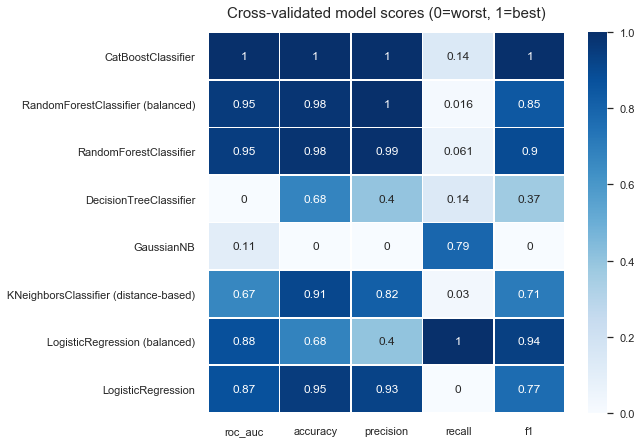

In [114]:
scaler = MinMaxScaler()
df_scores_scaled = scaler.fit_transform(df_scores)
df_scores_scaled = pd.DataFrame(df_scores_scaled,columns=df_scores.columns,index=df_scores.index)

fig,ax=plt.subplots(figsize=(8,7))
sns.heatmap(df_scores_scaled,cmap='Blues',annot=True,ax=ax,linewidths=0.75)
ax.set_ylim(0,8)
ax.set_title('Cross-validated model scores (0=worst, 1=best)',fontsize=15,pad=15)

In [119]:
df_scores

,roc_auc,accuracy,precision,recall,f1
LogisticRegression,85.34,84.42,72.76,47.46,57.44
LogisticRegression (balanced),85.41,77.91,50.10,75.71,60.29
KNeighborsClassifier (distance-based),81.34,83.52,68.02,48.32,56.50
GaussianNB,70.53,61.55,32.75,69.81,44.59
DecisionTreeClassifier,68.41,77.88,50.07,51.41,50.73
RandomForestClassifier,86.82,85.22,75.62,49.19,59.60
RandomForestClassifier (balanced),86.91,85.08,75.84,47.92,58.72
CatBoostClassifier,87.81,85.60,75.74,51.49,61.30


#### 3. Train the best performing model on the whole train set, and test it on the test set

In [115]:
model = CatBoostClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.065344
0:	learn: 0.6462891	total: 25.2ms	remaining: 25.1s
1:	learn: 0.6062307	total: 50.5ms	remaining: 25.2s
2:	learn: 0.5734985	total: 80.3ms	remaining: 26.7s
3:	learn: 0.5436406	total: 117ms	remaining: 29.2s
4:	learn: 0.5190321	total: 146ms	remaining: 29.1s
5:	learn: 0.4991893	total: 173ms	remaining: 28.6s
6:	learn: 0.4812747	total: 215ms	remaining: 30.5s
7:	learn: 0.4671972	total: 254ms	remaining: 31.5s
8:	learn: 0.4545232	total: 282ms	remaining: 31.1s
9:	learn: 0.4438706	total: 307ms	remaining: 30.4s
10:	learn: 0.4335776	total: 343ms	remaining: 30.8s
11:	learn: 0.4245711	total: 375ms	remaining: 30.9s
12:	learn: 0.4176171	total: 411ms	remaining: 31.2s
13:	learn: 0.4110122	total: 458ms	remaining: 32.3s
14:	learn: 0.4057075	total: 483ms	remaining: 31.7s
15:	learn: 0.4011776	total: 522ms	remaining: 32.1s
16:	learn: 0.3975860	total: 546ms	remaining: 31.6s
17:	learn: 0.3936476	total: 571ms	remaining: 31.1s
18:	learn: 0.3908590	total: 596ms	remaining: 30.7s
19:	lear

162:	learn: 0.3431074	total: 6.5s	remaining: 33.4s
163:	learn: 0.3429895	total: 6.56s	remaining: 33.4s
164:	learn: 0.3428800	total: 6.58s	remaining: 33.3s
165:	learn: 0.3427675	total: 6.6s	remaining: 33.2s
166:	learn: 0.3426459	total: 6.63s	remaining: 33.1s
167:	learn: 0.3425601	total: 6.65s	remaining: 32.9s
168:	learn: 0.3424912	total: 6.68s	remaining: 32.8s
169:	learn: 0.3423874	total: 6.7s	remaining: 32.7s
170:	learn: 0.3422739	total: 6.73s	remaining: 32.6s
171:	learn: 0.3421653	total: 6.76s	remaining: 32.5s
172:	learn: 0.3420519	total: 6.78s	remaining: 32.4s
173:	learn: 0.3419762	total: 6.81s	remaining: 32.3s
174:	learn: 0.3418402	total: 6.83s	remaining: 32.2s
175:	learn: 0.3417325	total: 6.85s	remaining: 32.1s
176:	learn: 0.3416181	total: 6.88s	remaining: 32s
177:	learn: 0.3415091	total: 6.9s	remaining: 31.9s
178:	learn: 0.3414272	total: 6.94s	remaining: 31.8s
179:	learn: 0.3413351	total: 6.96s	remaining: 31.7s
180:	learn: 0.3412223	total: 6.98s	remaining: 31.6s
181:	learn: 0.3411

322:	learn: 0.3280375	total: 13.3s	remaining: 27.8s
323:	learn: 0.3279829	total: 13.3s	remaining: 27.8s
324:	learn: 0.3279100	total: 13.3s	remaining: 27.7s
325:	learn: 0.3278413	total: 13.4s	remaining: 27.6s
326:	learn: 0.3277361	total: 13.4s	remaining: 27.6s
327:	learn: 0.3276725	total: 13.4s	remaining: 27.5s
328:	learn: 0.3275933	total: 13.4s	remaining: 27.4s
329:	learn: 0.3275138	total: 13.8s	remaining: 27.9s
330:	learn: 0.3274036	total: 13.8s	remaining: 27.9s
331:	learn: 0.3273430	total: 14.1s	remaining: 28.4s
332:	learn: 0.3272808	total: 14.2s	remaining: 28.4s
333:	learn: 0.3272095	total: 14.2s	remaining: 28.3s
334:	learn: 0.3271256	total: 14.2s	remaining: 28.2s
335:	learn: 0.3270542	total: 14.2s	remaining: 28.2s
336:	learn: 0.3269779	total: 14.3s	remaining: 28.1s
337:	learn: 0.3269207	total: 14.3s	remaining: 28s
338:	learn: 0.3268516	total: 14.3s	remaining: 28s
339:	learn: 0.3267727	total: 14.4s	remaining: 27.9s
340:	learn: 0.3266845	total: 14.4s	remaining: 27.8s
341:	learn: 0.32

486:	learn: 0.3170279	total: 19.5s	remaining: 20.6s
487:	learn: 0.3169641	total: 19.6s	remaining: 20.5s
488:	learn: 0.3169086	total: 19.6s	remaining: 20.5s
489:	learn: 0.3168307	total: 19.7s	remaining: 20.5s
490:	learn: 0.3167769	total: 19.7s	remaining: 20.4s
491:	learn: 0.3167285	total: 19.8s	remaining: 20.4s
492:	learn: 0.3166764	total: 19.8s	remaining: 20.3s
493:	learn: 0.3166242	total: 19.8s	remaining: 20.3s
494:	learn: 0.3165537	total: 19.9s	remaining: 20.3s
495:	learn: 0.3164826	total: 19.9s	remaining: 20.2s
496:	learn: 0.3163945	total: 20s	remaining: 20.2s
497:	learn: 0.3163315	total: 20s	remaining: 20.2s
498:	learn: 0.3162516	total: 20.1s	remaining: 20.1s
499:	learn: 0.3161678	total: 20.1s	remaining: 20.1s
500:	learn: 0.3161153	total: 20.1s	remaining: 20.1s
501:	learn: 0.3160594	total: 20.2s	remaining: 20s
502:	learn: 0.3160112	total: 20.2s	remaining: 20s
503:	learn: 0.3159669	total: 20.3s	remaining: 19.9s
504:	learn: 0.3158986	total: 20.3s	remaining: 19.9s
505:	learn: 0.315847

647:	learn: 0.3081737	total: 25.2s	remaining: 13.7s
648:	learn: 0.3081320	total: 25.2s	remaining: 13.7s
649:	learn: 0.3080809	total: 25.3s	remaining: 13.6s
650:	learn: 0.3080132	total: 25.3s	remaining: 13.6s
651:	learn: 0.3079775	total: 25.4s	remaining: 13.5s
652:	learn: 0.3079350	total: 25.4s	remaining: 13.5s
653:	learn: 0.3079069	total: 25.4s	remaining: 13.5s
654:	learn: 0.3078506	total: 25.5s	remaining: 13.4s
655:	learn: 0.3078300	total: 25.5s	remaining: 13.4s
656:	learn: 0.3077812	total: 25.5s	remaining: 13.3s
657:	learn: 0.3077212	total: 25.6s	remaining: 13.3s
658:	learn: 0.3076313	total: 25.6s	remaining: 13.2s
659:	learn: 0.3075675	total: 25.6s	remaining: 13.2s
660:	learn: 0.3075180	total: 25.7s	remaining: 13.2s
661:	learn: 0.3074689	total: 25.7s	remaining: 13.1s
662:	learn: 0.3074276	total: 25.7s	remaining: 13.1s
663:	learn: 0.3073969	total: 25.8s	remaining: 13s
664:	learn: 0.3073451	total: 25.8s	remaining: 13s
665:	learn: 0.3072989	total: 25.8s	remaining: 13s
666:	learn: 0.3072

808:	learn: 0.3004467	total: 31.7s	remaining: 7.48s
809:	learn: 0.3004095	total: 32s	remaining: 7.5s
810:	learn: 0.3003734	total: 32.1s	remaining: 7.47s
811:	learn: 0.3003216	total: 32.1s	remaining: 7.44s
812:	learn: 0.3002759	total: 32.2s	remaining: 7.41s
813:	learn: 0.3002274	total: 32.3s	remaining: 7.37s
814:	learn: 0.3001633	total: 32.3s	remaining: 7.33s
815:	learn: 0.3001173	total: 32.3s	remaining: 7.29s
816:	learn: 0.3000807	total: 32.4s	remaining: 7.26s
817:	learn: 0.3000254	total: 32.4s	remaining: 7.22s
818:	learn: 0.2999692	total: 32.5s	remaining: 7.18s
819:	learn: 0.2999302	total: 32.5s	remaining: 7.14s
820:	learn: 0.2998642	total: 32.6s	remaining: 7.1s
821:	learn: 0.2998149	total: 32.6s	remaining: 7.06s
822:	learn: 0.2997555	total: 32.7s	remaining: 7.02s
823:	learn: 0.2997044	total: 32.7s	remaining: 6.99s
824:	learn: 0.2996587	total: 32.7s	remaining: 6.94s
825:	learn: 0.2996263	total: 32.8s	remaining: 6.9s
826:	learn: 0.2996006	total: 32.8s	remaining: 6.86s
827:	learn: 0.299

972:	learn: 0.2934534	total: 40.7s	remaining: 1.13s
973:	learn: 0.2934092	total: 40.7s	remaining: 1.09s
974:	learn: 0.2933668	total: 40.7s	remaining: 1.04s
975:	learn: 0.2933031	total: 40.8s	remaining: 1s
976:	learn: 0.2932676	total: 40.8s	remaining: 961ms
977:	learn: 0.2932113	total: 40.8s	remaining: 919ms
978:	learn: 0.2931770	total: 40.9s	remaining: 877ms
979:	learn: 0.2931192	total: 40.9s	remaining: 835ms
980:	learn: 0.2930921	total: 40.9s	remaining: 793ms
981:	learn: 0.2930614	total: 41s	remaining: 751ms
982:	learn: 0.2930287	total: 41s	remaining: 709ms
983:	learn: 0.2929830	total: 41.1s	remaining: 668ms
984:	learn: 0.2929267	total: 41.1s	remaining: 626ms
985:	learn: 0.2928781	total: 41.1s	remaining: 584ms
986:	learn: 0.2928216	total: 41.2s	remaining: 542ms
987:	learn: 0.2927625	total: 41.2s	remaining: 501ms
988:	learn: 0.2927219	total: 41.3s	remaining: 459ms
989:	learn: 0.2926908	total: 41.3s	remaining: 417ms
990:	learn: 0.2926530	total: 41.4s	remaining: 376ms
991:	learn: 0.29258

In [116]:
print(f'roc_auc: {round(roc_auc_score(y_test,y_pred)*100,2)}%')
print(f'accuracy: {round(accuracy_score(y_test,y_pred)*100,2)}%')
print(f'precision: {round(precision_score(y_test,y_pred)*100,2)}%')
print(f'recall: {round(recall_score(y_test,y_pred)*100,2)}%')
print(f'f1: {round(f1_score(y_test,y_pred)*100,2)}%')

roc_auc: 73.72%
accuracy: 85.73%
precision: 75.91%
recall: 52.14%
f1: 61.82%


In [117]:
confusion_matrix(y_test,y_pred)

array([[27644,  1366],
       [ 3951,  4305]])

### Without clusters

In [125]:
X = model_df.drop('RainTomorrow',axis=1)
y = model_df.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,stratify=y,random_state=42)

In [126]:
metrics = ['roc_auc','accuracy','precision','recall','f1']

def append_model_perf(model,scores,df_scores):
    scores_lst = []
    for metric in metrics:
        scores_lst.append(round(np.mean(scores[f'test_{metric}'])*100,2))
    df_temp = pd.DataFrame(data=scores_lst, index=metrics, columns=[model]).T
    if df_scores.empty:
        return df_temp
    else:
        return pd.concat([df_scores,df_temp])
    
df_scores = pd.DataFrame()
cv = StratifiedKFold(n_splits=10, shuffle=False)

In [127]:
model = LogisticRegression()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('LogisticRegression',scores,df_scores)

In [128]:
model = LogisticRegression(class_weight='balanced')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('LogisticRegression (balanced)',scores,df_scores)

In [129]:
model = KNeighborsClassifier(weights='distance')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('KNeighborsClassifier (distance-based)',scores,df_scores)

In [130]:
model = GaussianNB()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('GaussianNB',scores,df_scores)

In [131]:
model = DecisionTreeClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('DecisionTreeClassifier',scores,df_scores)

In [132]:
model = RandomForestClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('RandomForestClassifier',scores,df_scores)

In [133]:
model = RandomForestClassifier(class_weight='balanced')
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('RandomForestClassifier (balanced)',scores,df_scores)

In [134]:
model = CatBoostClassifier()
scores = cross_validate(model,X_train, y_train, cv=cv, scoring=metrics)
df_scores = append_model_perf('CatBoostClassifier',scores,df_scores)

Learning rate set to 0.06247
0:	learn: 0.6509699	total: 38.9ms	remaining: 38.9s
1:	learn: 0.6106284	total: 62.7ms	remaining: 31.3s
2:	learn: 0.5749551	total: 83.4ms	remaining: 27.7s
3:	learn: 0.5460876	total: 107ms	remaining: 26.6s
4:	learn: 0.5210668	total: 126ms	remaining: 25.2s
5:	learn: 0.5001730	total: 146ms	remaining: 24.1s
6:	learn: 0.4831496	total: 166ms	remaining: 23.6s
7:	learn: 0.4671847	total: 193ms	remaining: 24s
8:	learn: 0.4530118	total: 233ms	remaining: 25.7s
9:	learn: 0.4420095	total: 254ms	remaining: 25.2s
10:	learn: 0.4325705	total: 278ms	remaining: 25s
11:	learn: 0.4246216	total: 301ms	remaining: 24.8s
12:	learn: 0.4174068	total: 327ms	remaining: 24.8s
13:	learn: 0.4102037	total: 356ms	remaining: 25.1s
14:	learn: 0.4040376	total: 383ms	remaining: 25.1s
15:	learn: 0.3990021	total: 435ms	remaining: 26.7s
16:	learn: 0.3951610	total: 464ms	remaining: 26.8s
17:	learn: 0.3913377	total: 488ms	remaining: 26.6s
18:	learn: 0.3878661	total: 510ms	remaining: 26.3s
19:	learn: 0.

161:	learn: 0.3287168	total: 5.23s	remaining: 27.1s
162:	learn: 0.3286312	total: 5.28s	remaining: 27.1s
163:	learn: 0.3285321	total: 5.3s	remaining: 27s
164:	learn: 0.3283795	total: 5.32s	remaining: 26.9s
165:	learn: 0.3282300	total: 5.35s	remaining: 26.9s
166:	learn: 0.3280933	total: 5.38s	remaining: 26.9s
167:	learn: 0.3279527	total: 5.41s	remaining: 26.8s
168:	learn: 0.3278112	total: 5.44s	remaining: 26.8s
169:	learn: 0.3276841	total: 5.48s	remaining: 26.8s
170:	learn: 0.3275661	total: 5.5s	remaining: 26.7s
171:	learn: 0.3274230	total: 5.53s	remaining: 26.6s
172:	learn: 0.3273190	total: 5.55s	remaining: 26.5s
173:	learn: 0.3271973	total: 5.57s	remaining: 26.4s
174:	learn: 0.3270273	total: 5.59s	remaining: 26.4s
175:	learn: 0.3268501	total: 5.62s	remaining: 26.3s
176:	learn: 0.3267248	total: 5.64s	remaining: 26.2s
177:	learn: 0.3266168	total: 5.68s	remaining: 26.2s
178:	learn: 0.3264886	total: 5.7s	remaining: 26.1s
179:	learn: 0.3263183	total: 5.72s	remaining: 26.1s
180:	learn: 0.326

324:	learn: 0.3089165	total: 10.4s	remaining: 21.6s
325:	learn: 0.3088237	total: 10.4s	remaining: 21.5s
326:	learn: 0.3087125	total: 10.4s	remaining: 21.5s
327:	learn: 0.3086300	total: 10.5s	remaining: 21.5s
328:	learn: 0.3085384	total: 10.6s	remaining: 21.6s
329:	learn: 0.3084155	total: 10.6s	remaining: 21.6s
330:	learn: 0.3083096	total: 10.7s	remaining: 21.6s
331:	learn: 0.3082146	total: 10.7s	remaining: 21.6s
332:	learn: 0.3081343	total: 10.7s	remaining: 21.5s
333:	learn: 0.3080592	total: 10.8s	remaining: 21.5s
334:	learn: 0.3079865	total: 10.8s	remaining: 21.4s
335:	learn: 0.3079082	total: 10.8s	remaining: 21.4s
336:	learn: 0.3078257	total: 10.8s	remaining: 21.3s
337:	learn: 0.3077288	total: 10.9s	remaining: 21.3s
338:	learn: 0.3076517	total: 10.9s	remaining: 21.3s
339:	learn: 0.3075467	total: 10.9s	remaining: 21.2s
340:	learn: 0.3074637	total: 11s	remaining: 21.2s
341:	learn: 0.3073863	total: 11s	remaining: 21.2s
342:	learn: 0.3073037	total: 11s	remaining: 21.2s
343:	learn: 0.3072

487:	learn: 0.2948570	total: 16.2s	remaining: 17s
488:	learn: 0.2947743	total: 16.2s	remaining: 17s
489:	learn: 0.2946748	total: 16.3s	remaining: 16.9s
490:	learn: 0.2945852	total: 16.3s	remaining: 16.9s
491:	learn: 0.2945070	total: 16.3s	remaining: 16.8s
492:	learn: 0.2944505	total: 16.3s	remaining: 16.8s
493:	learn: 0.2943765	total: 16.4s	remaining: 16.8s
494:	learn: 0.2942945	total: 16.4s	remaining: 16.7s
495:	learn: 0.2942195	total: 16.4s	remaining: 16.7s
496:	learn: 0.2941482	total: 16.4s	remaining: 16.6s
497:	learn: 0.2940904	total: 16.5s	remaining: 16.6s
498:	learn: 0.2940103	total: 16.5s	remaining: 16.6s
499:	learn: 0.2939082	total: 16.5s	remaining: 16.5s
500:	learn: 0.2938372	total: 16.5s	remaining: 16.5s
501:	learn: 0.2937489	total: 16.6s	remaining: 16.4s
502:	learn: 0.2936613	total: 16.6s	remaining: 16.4s
503:	learn: 0.2935877	total: 16.6s	remaining: 16.4s
504:	learn: 0.2934971	total: 16.7s	remaining: 16.3s
505:	learn: 0.2934334	total: 16.7s	remaining: 16.3s
506:	learn: 0.29

646:	learn: 0.2834036	total: 20.6s	remaining: 11.3s
647:	learn: 0.2833378	total: 20.7s	remaining: 11.2s
648:	learn: 0.2832620	total: 20.7s	remaining: 11.2s
649:	learn: 0.2831775	total: 20.7s	remaining: 11.2s
650:	learn: 0.2831053	total: 20.7s	remaining: 11.1s
651:	learn: 0.2830348	total: 20.8s	remaining: 11.1s
652:	learn: 0.2829804	total: 20.8s	remaining: 11s
653:	learn: 0.2828891	total: 20.8s	remaining: 11s
654:	learn: 0.2828352	total: 20.8s	remaining: 11s
655:	learn: 0.2828016	total: 20.9s	remaining: 10.9s
656:	learn: 0.2827344	total: 20.9s	remaining: 10.9s
657:	learn: 0.2826687	total: 20.9s	remaining: 10.9s
658:	learn: 0.2825988	total: 20.9s	remaining: 10.8s
659:	learn: 0.2825336	total: 21s	remaining: 10.8s
660:	learn: 0.2824860	total: 21s	remaining: 10.8s
661:	learn: 0.2824190	total: 21s	remaining: 10.7s
662:	learn: 0.2823646	total: 21s	remaining: 10.7s
663:	learn: 0.2822950	total: 21.1s	remaining: 10.7s
664:	learn: 0.2822371	total: 21.1s	remaining: 10.6s
665:	learn: 0.2821810	tota

805:	learn: 0.2736145	total: 25.6s	remaining: 6.16s
806:	learn: 0.2735651	total: 25.6s	remaining: 6.13s
807:	learn: 0.2735039	total: 25.7s	remaining: 6.1s
808:	learn: 0.2734661	total: 25.7s	remaining: 6.07s
809:	learn: 0.2734037	total: 25.7s	remaining: 6.04s
810:	learn: 0.2733485	total: 25.8s	remaining: 6.01s
811:	learn: 0.2732796	total: 25.8s	remaining: 5.98s
812:	learn: 0.2732272	total: 25.9s	remaining: 5.95s
813:	learn: 0.2731782	total: 25.9s	remaining: 5.91s
814:	learn: 0.2731088	total: 25.9s	remaining: 5.88s
815:	learn: 0.2730489	total: 25.9s	remaining: 5.85s
816:	learn: 0.2729686	total: 26s	remaining: 5.81s
817:	learn: 0.2729110	total: 26s	remaining: 5.78s
818:	learn: 0.2728668	total: 26s	remaining: 5.75s
819:	learn: 0.2728098	total: 26s	remaining: 5.71s
820:	learn: 0.2727515	total: 26.1s	remaining: 5.68s
821:	learn: 0.2726979	total: 26.1s	remaining: 5.65s
822:	learn: 0.2726301	total: 26.1s	remaining: 5.62s
823:	learn: 0.2725747	total: 26.1s	remaining: 5.58s
824:	learn: 0.2725287

968:	learn: 0.2646736	total: 29.8s	remaining: 954ms
969:	learn: 0.2646353	total: 29.8s	remaining: 923ms
970:	learn: 0.2645501	total: 29.9s	remaining: 892ms
971:	learn: 0.2644858	total: 29.9s	remaining: 861ms
972:	learn: 0.2644382	total: 29.9s	remaining: 830ms
973:	learn: 0.2643918	total: 29.9s	remaining: 799ms
974:	learn: 0.2643448	total: 30s	remaining: 768ms
975:	learn: 0.2643067	total: 30s	remaining: 737ms
976:	learn: 0.2642445	total: 30s	remaining: 707ms
977:	learn: 0.2642032	total: 30s	remaining: 676ms
978:	learn: 0.2641566	total: 30.1s	remaining: 645ms
979:	learn: 0.2641067	total: 30.1s	remaining: 614ms
980:	learn: 0.2640488	total: 30.1s	remaining: 583ms
981:	learn: 0.2639948	total: 30.1s	remaining: 553ms
982:	learn: 0.2639272	total: 30.2s	remaining: 522ms
983:	learn: 0.2638458	total: 30.2s	remaining: 491ms
984:	learn: 0.2637988	total: 30.2s	remaining: 460ms
985:	learn: 0.2637497	total: 30.2s	remaining: 430ms
986:	learn: 0.2637104	total: 30.3s	remaining: 399ms
987:	learn: 0.263652

130:	learn: 0.3335782	total: 4.08s	remaining: 27.1s
131:	learn: 0.3333816	total: 4.13s	remaining: 27.1s
132:	learn: 0.3332280	total: 4.17s	remaining: 27.2s
133:	learn: 0.3330986	total: 4.21s	remaining: 27.2s
134:	learn: 0.3329231	total: 4.24s	remaining: 27.2s
135:	learn: 0.3327878	total: 4.28s	remaining: 27.2s
136:	learn: 0.3326418	total: 4.32s	remaining: 27.2s
137:	learn: 0.3325700	total: 4.36s	remaining: 27.2s
138:	learn: 0.3323566	total: 4.39s	remaining: 27.2s
139:	learn: 0.3322386	total: 4.42s	remaining: 27.2s
140:	learn: 0.3320723	total: 4.46s	remaining: 27.2s
141:	learn: 0.3319392	total: 4.49s	remaining: 27.1s
142:	learn: 0.3318135	total: 4.53s	remaining: 27.2s
143:	learn: 0.3316669	total: 4.57s	remaining: 27.2s
144:	learn: 0.3314953	total: 4.6s	remaining: 27.1s
145:	learn: 0.3313530	total: 4.62s	remaining: 27.1s
146:	learn: 0.3311874	total: 4.65s	remaining: 27s
147:	learn: 0.3310292	total: 4.68s	remaining: 26.9s
148:	learn: 0.3309402	total: 4.7s	remaining: 26.8s
149:	learn: 0.33

290:	learn: 0.3124083	total: 8.4s	remaining: 20.5s
291:	learn: 0.3122802	total: 8.43s	remaining: 20.4s
292:	learn: 0.3121704	total: 8.46s	remaining: 20.4s
293:	learn: 0.3120445	total: 8.48s	remaining: 20.4s
294:	learn: 0.3119313	total: 8.5s	remaining: 20.3s
295:	learn: 0.3118358	total: 8.53s	remaining: 20.3s
296:	learn: 0.3117326	total: 8.55s	remaining: 20.2s
297:	learn: 0.3116340	total: 8.57s	remaining: 20.2s
298:	learn: 0.3115241	total: 8.6s	remaining: 20.2s
299:	learn: 0.3114187	total: 8.63s	remaining: 20.1s
300:	learn: 0.3112755	total: 8.66s	remaining: 20.1s
301:	learn: 0.3111801	total: 8.68s	remaining: 20.1s
302:	learn: 0.3110812	total: 8.71s	remaining: 20s
303:	learn: 0.3109687	total: 8.73s	remaining: 20s
304:	learn: 0.3108479	total: 8.75s	remaining: 19.9s
305:	learn: 0.3107246	total: 8.78s	remaining: 19.9s
306:	learn: 0.3106252	total: 8.8s	remaining: 19.9s
307:	learn: 0.3105413	total: 8.82s	remaining: 19.8s
308:	learn: 0.3104122	total: 8.86s	remaining: 19.8s
309:	learn: 0.310298

450:	learn: 0.2976829	total: 12.7s	remaining: 15.4s
451:	learn: 0.2975992	total: 12.7s	remaining: 15.4s
452:	learn: 0.2975167	total: 12.8s	remaining: 15.4s
453:	learn: 0.2974311	total: 12.8s	remaining: 15.4s
454:	learn: 0.2973503	total: 12.8s	remaining: 15.4s
455:	learn: 0.2972568	total: 12.9s	remaining: 15.4s
456:	learn: 0.2971787	total: 12.9s	remaining: 15.3s
457:	learn: 0.2971221	total: 13s	remaining: 15.3s
458:	learn: 0.2970367	total: 13s	remaining: 15.3s
459:	learn: 0.2969653	total: 13s	remaining: 15.3s
460:	learn: 0.2968770	total: 13.1s	remaining: 15.3s
461:	learn: 0.2967901	total: 13.1s	remaining: 15.3s
462:	learn: 0.2966807	total: 13.1s	remaining: 15.3s
463:	learn: 0.2965827	total: 13.2s	remaining: 15.2s
464:	learn: 0.2964897	total: 13.2s	remaining: 15.2s
465:	learn: 0.2964180	total: 13.3s	remaining: 15.2s
466:	learn: 0.2963247	total: 13.3s	remaining: 15.2s
467:	learn: 0.2962361	total: 13.3s	remaining: 15.1s
468:	learn: 0.2961613	total: 13.4s	remaining: 15.1s
469:	learn: 0.2960

615:	learn: 0.2853100	total: 17.7s	remaining: 11s
616:	learn: 0.2852442	total: 17.7s	remaining: 11s
617:	learn: 0.2851763	total: 17.7s	remaining: 11s
618:	learn: 0.2850988	total: 17.7s	remaining: 10.9s
619:	learn: 0.2850346	total: 17.8s	remaining: 10.9s
620:	learn: 0.2849571	total: 17.8s	remaining: 10.9s
621:	learn: 0.2849130	total: 17.8s	remaining: 10.8s
622:	learn: 0.2848579	total: 17.8s	remaining: 10.8s
623:	learn: 0.2848257	total: 17.9s	remaining: 10.8s
624:	learn: 0.2847576	total: 17.9s	remaining: 10.7s
625:	learn: 0.2846809	total: 17.9s	remaining: 10.7s
626:	learn: 0.2846215	total: 17.9s	remaining: 10.7s
627:	learn: 0.2845539	total: 18s	remaining: 10.6s
628:	learn: 0.2844709	total: 18s	remaining: 10.6s
629:	learn: 0.2844157	total: 18s	remaining: 10.6s
630:	learn: 0.2843519	total: 18.1s	remaining: 10.6s
631:	learn: 0.2842869	total: 18.1s	remaining: 10.5s
632:	learn: 0.2841978	total: 18.1s	remaining: 10.5s
633:	learn: 0.2841462	total: 18.1s	remaining: 10.5s
634:	learn: 0.2840624	to

777:	learn: 0.2750492	total: 21.9s	remaining: 6.25s
778:	learn: 0.2749872	total: 21.9s	remaining: 6.22s
779:	learn: 0.2749248	total: 22s	remaining: 6.2s
780:	learn: 0.2748649	total: 22s	remaining: 6.17s
781:	learn: 0.2747937	total: 22s	remaining: 6.14s
782:	learn: 0.2747323	total: 22.1s	remaining: 6.11s
783:	learn: 0.2746810	total: 22.1s	remaining: 6.08s
784:	learn: 0.2746028	total: 22.1s	remaining: 6.05s
785:	learn: 0.2745507	total: 22.1s	remaining: 6.03s
786:	learn: 0.2744986	total: 22.2s	remaining: 6s
787:	learn: 0.2744396	total: 22.2s	remaining: 5.97s
788:	learn: 0.2743883	total: 22.2s	remaining: 5.94s
789:	learn: 0.2743225	total: 22.2s	remaining: 5.91s
790:	learn: 0.2742828	total: 22.3s	remaining: 5.88s
791:	learn: 0.2742210	total: 22.3s	remaining: 5.86s
792:	learn: 0.2741562	total: 22.3s	remaining: 5.83s
793:	learn: 0.2740948	total: 22.4s	remaining: 5.8s
794:	learn: 0.2740491	total: 22.4s	remaining: 5.77s
795:	learn: 0.2739944	total: 22.4s	remaining: 5.74s
796:	learn: 0.2739271	t

943:	learn: 0.2655742	total: 27.2s	remaining: 1.61s
944:	learn: 0.2655181	total: 27.2s	remaining: 1.58s
945:	learn: 0.2654679	total: 27.3s	remaining: 1.56s
946:	learn: 0.2654115	total: 27.3s	remaining: 1.53s
947:	learn: 0.2653601	total: 27.3s	remaining: 1.5s
948:	learn: 0.2653180	total: 27.3s	remaining: 1.47s
949:	learn: 0.2652892	total: 27.4s	remaining: 1.44s
950:	learn: 0.2652548	total: 27.4s	remaining: 1.41s
951:	learn: 0.2651974	total: 27.4s	remaining: 1.38s
952:	learn: 0.2651388	total: 27.4s	remaining: 1.35s
953:	learn: 0.2650874	total: 27.5s	remaining: 1.32s
954:	learn: 0.2650603	total: 27.5s	remaining: 1.29s
955:	learn: 0.2649793	total: 27.5s	remaining: 1.27s
956:	learn: 0.2649418	total: 27.5s	remaining: 1.24s
957:	learn: 0.2648938	total: 27.6s	remaining: 1.21s
958:	learn: 0.2648509	total: 27.6s	remaining: 1.18s
959:	learn: 0.2647813	total: 27.6s	remaining: 1.15s
960:	learn: 0.2647103	total: 27.6s	remaining: 1.12s
961:	learn: 0.2646501	total: 27.7s	remaining: 1.09s
962:	learn: 0

104:	learn: 0.3372246	total: 5.49s	remaining: 46.8s
105:	learn: 0.3370288	total: 5.78s	remaining: 48.8s
106:	learn: 0.3368605	total: 5.93s	remaining: 49.5s
107:	learn: 0.3367464	total: 6.12s	remaining: 50.6s
108:	learn: 0.3365241	total: 6.15s	remaining: 50.3s
109:	learn: 0.3363656	total: 6.21s	remaining: 50.2s
110:	learn: 0.3362291	total: 6.32s	remaining: 50.6s
111:	learn: 0.3360820	total: 6.51s	remaining: 51.6s
112:	learn: 0.3359678	total: 6.55s	remaining: 51.4s
113:	learn: 0.3358257	total: 6.64s	remaining: 51.6s
114:	learn: 0.3356509	total: 6.68s	remaining: 51.4s
115:	learn: 0.3355477	total: 6.73s	remaining: 51.3s
116:	learn: 0.3353877	total: 6.77s	remaining: 51.1s
117:	learn: 0.3352191	total: 6.8s	remaining: 50.9s
118:	learn: 0.3350535	total: 6.87s	remaining: 50.8s
119:	learn: 0.3347895	total: 6.92s	remaining: 50.7s
120:	learn: 0.3345815	total: 7s	remaining: 50.8s
121:	learn: 0.3343890	total: 7.04s	remaining: 50.7s
122:	learn: 0.3341656	total: 7.08s	remaining: 50.5s
123:	learn: 0.33

271:	learn: 0.3143035	total: 11.8s	remaining: 31.7s
272:	learn: 0.3141991	total: 11.8s	remaining: 31.6s
273:	learn: 0.3140744	total: 11.9s	remaining: 31.5s
274:	learn: 0.3139650	total: 11.9s	remaining: 31.4s
275:	learn: 0.3138496	total: 11.9s	remaining: 31.3s
276:	learn: 0.3137372	total: 12s	remaining: 31.2s
277:	learn: 0.3136178	total: 12s	remaining: 31.1s
278:	learn: 0.3135207	total: 12s	remaining: 31s
279:	learn: 0.3134333	total: 12s	remaining: 30.9s
280:	learn: 0.3133288	total: 12.1s	remaining: 30.9s
281:	learn: 0.3131976	total: 12.1s	remaining: 30.8s
282:	learn: 0.3130819	total: 12.1s	remaining: 30.7s
283:	learn: 0.3129882	total: 12.1s	remaining: 30.6s
284:	learn: 0.3128940	total: 12.2s	remaining: 30.5s
285:	learn: 0.3127434	total: 12.2s	remaining: 30.4s
286:	learn: 0.3126421	total: 12.2s	remaining: 30.3s
287:	learn: 0.3125421	total: 12.2s	remaining: 30.2s
288:	learn: 0.3124416	total: 12.3s	remaining: 30.2s
289:	learn: 0.3123248	total: 12.3s	remaining: 30.1s
290:	learn: 0.3122233	

432:	learn: 0.2989101	total: 16.8s	remaining: 22s
433:	learn: 0.2988225	total: 16.9s	remaining: 22s
434:	learn: 0.2987664	total: 16.9s	remaining: 22s
435:	learn: 0.2986810	total: 16.9s	remaining: 21.9s
436:	learn: 0.2986125	total: 17s	remaining: 21.9s
437:	learn: 0.2985016	total: 17s	remaining: 21.8s
438:	learn: 0.2984112	total: 17.1s	remaining: 21.8s
439:	learn: 0.2983342	total: 17.1s	remaining: 21.8s
440:	learn: 0.2982387	total: 17.1s	remaining: 21.7s
441:	learn: 0.2981513	total: 17.2s	remaining: 21.7s
442:	learn: 0.2980937	total: 17.2s	remaining: 21.6s
443:	learn: 0.2980173	total: 17.2s	remaining: 21.6s
444:	learn: 0.2979434	total: 17.3s	remaining: 21.6s
445:	learn: 0.2978340	total: 17.3s	remaining: 21.5s
446:	learn: 0.2977768	total: 17.4s	remaining: 21.5s
447:	learn: 0.2977057	total: 17.4s	remaining: 21.5s
448:	learn: 0.2976340	total: 17.5s	remaining: 21.4s
449:	learn: 0.2975652	total: 17.5s	remaining: 21.4s
450:	learn: 0.2974919	total: 17.5s	remaining: 21.3s
451:	learn: 0.2974333	

594:	learn: 0.2869704	total: 21.4s	remaining: 14.6s
595:	learn: 0.2868854	total: 21.4s	remaining: 14.5s
596:	learn: 0.2868127	total: 21.4s	remaining: 14.5s
597:	learn: 0.2867177	total: 21.5s	remaining: 14.4s
598:	learn: 0.2866362	total: 21.5s	remaining: 14.4s
599:	learn: 0.2865764	total: 21.5s	remaining: 14.3s
600:	learn: 0.2865115	total: 21.5s	remaining: 14.3s
601:	learn: 0.2864376	total: 21.6s	remaining: 14.3s
602:	learn: 0.2863947	total: 21.6s	remaining: 14.2s
603:	learn: 0.2863310	total: 21.6s	remaining: 14.2s
604:	learn: 0.2862528	total: 21.7s	remaining: 14.1s
605:	learn: 0.2861702	total: 21.7s	remaining: 14.1s
606:	learn: 0.2860994	total: 21.7s	remaining: 14.1s
607:	learn: 0.2860369	total: 21.7s	remaining: 14s
608:	learn: 0.2859550	total: 21.8s	remaining: 14s
609:	learn: 0.2858845	total: 21.8s	remaining: 13.9s
610:	learn: 0.2858221	total: 21.8s	remaining: 13.9s
611:	learn: 0.2857738	total: 21.9s	remaining: 13.9s
612:	learn: 0.2857044	total: 21.9s	remaining: 13.8s
613:	learn: 0.28

754:	learn: 0.2767793	total: 25.8s	remaining: 8.38s
755:	learn: 0.2767046	total: 25.9s	remaining: 8.35s
756:	learn: 0.2766348	total: 25.9s	remaining: 8.31s
757:	learn: 0.2765869	total: 25.9s	remaining: 8.28s
758:	learn: 0.2765401	total: 26s	remaining: 8.24s
759:	learn: 0.2764702	total: 26s	remaining: 8.21s
760:	learn: 0.2763963	total: 26s	remaining: 8.18s
761:	learn: 0.2763306	total: 26.1s	remaining: 8.15s
762:	learn: 0.2762662	total: 26.1s	remaining: 8.11s
763:	learn: 0.2762032	total: 26.2s	remaining: 8.08s
764:	learn: 0.2761527	total: 26.2s	remaining: 8.05s
765:	learn: 0.2760757	total: 26.2s	remaining: 8.01s
766:	learn: 0.2760407	total: 26.3s	remaining: 7.98s
767:	learn: 0.2759704	total: 26.3s	remaining: 7.95s
768:	learn: 0.2758897	total: 26.4s	remaining: 7.92s
769:	learn: 0.2758236	total: 26.4s	remaining: 7.89s
770:	learn: 0.2757663	total: 26.4s	remaining: 7.85s
771:	learn: 0.2757167	total: 26.5s	remaining: 7.82s
772:	learn: 0.2756551	total: 26.5s	remaining: 7.79s
773:	learn: 0.2756

917:	learn: 0.2670808	total: 30.7s	remaining: 2.75s
918:	learn: 0.2670288	total: 30.8s	remaining: 2.71s
919:	learn: 0.2669624	total: 30.8s	remaining: 2.68s
920:	learn: 0.2668974	total: 30.8s	remaining: 2.64s
921:	learn: 0.2668424	total: 30.9s	remaining: 2.61s
922:	learn: 0.2667928	total: 30.9s	remaining: 2.58s
923:	learn: 0.2667159	total: 30.9s	remaining: 2.54s
924:	learn: 0.2666692	total: 30.9s	remaining: 2.51s
925:	learn: 0.2666204	total: 31s	remaining: 2.47s
926:	learn: 0.2665621	total: 31s	remaining: 2.44s
927:	learn: 0.2665087	total: 31s	remaining: 2.41s
928:	learn: 0.2664674	total: 31s	remaining: 2.37s
929:	learn: 0.2664157	total: 31.1s	remaining: 2.34s
930:	learn: 0.2663551	total: 31.1s	remaining: 2.3s
931:	learn: 0.2662979	total: 31.1s	remaining: 2.27s
932:	learn: 0.2662495	total: 31.1s	remaining: 2.23s
933:	learn: 0.2661988	total: 31.2s	remaining: 2.2s
934:	learn: 0.2661368	total: 31.2s	remaining: 2.17s
935:	learn: 0.2660869	total: 31.2s	remaining: 2.13s
936:	learn: 0.2660377	

84:	learn: 0.3423865	total: 2.2s	remaining: 23.7s
85:	learn: 0.3421914	total: 2.24s	remaining: 23.8s
86:	learn: 0.3420032	total: 2.27s	remaining: 23.9s
87:	learn: 0.3417528	total: 2.31s	remaining: 23.9s
88:	learn: 0.3415445	total: 2.34s	remaining: 24s
89:	learn: 0.3413477	total: 2.38s	remaining: 24.1s
90:	learn: 0.3411368	total: 2.43s	remaining: 24.3s
91:	learn: 0.3409547	total: 2.47s	remaining: 24.4s
92:	learn: 0.3408067	total: 2.51s	remaining: 24.5s
93:	learn: 0.3406196	total: 2.54s	remaining: 24.5s
94:	learn: 0.3404036	total: 2.57s	remaining: 24.5s
95:	learn: 0.3402267	total: 2.6s	remaining: 24.5s
96:	learn: 0.3399845	total: 2.64s	remaining: 24.6s
97:	learn: 0.3397615	total: 2.69s	remaining: 24.8s
98:	learn: 0.3395977	total: 2.72s	remaining: 24.8s
99:	learn: 0.3394214	total: 2.76s	remaining: 24.8s
100:	learn: 0.3392486	total: 2.79s	remaining: 24.8s
101:	learn: 0.3390198	total: 2.83s	remaining: 24.9s
102:	learn: 0.3388486	total: 2.88s	remaining: 25.1s
103:	learn: 0.3386293	total: 2.9

247:	learn: 0.3184771	total: 7.39s	remaining: 22.4s
248:	learn: 0.3183440	total: 7.43s	remaining: 22.4s
249:	learn: 0.3182162	total: 7.46s	remaining: 22.4s
250:	learn: 0.3180888	total: 7.48s	remaining: 22.3s
251:	learn: 0.3179825	total: 7.5s	remaining: 22.3s
252:	learn: 0.3178586	total: 7.53s	remaining: 22.2s
253:	learn: 0.3177362	total: 7.55s	remaining: 22.2s
254:	learn: 0.3176264	total: 7.58s	remaining: 22.1s
255:	learn: 0.3175125	total: 7.61s	remaining: 22.1s
256:	learn: 0.3174267	total: 7.64s	remaining: 22.1s
257:	learn: 0.3173295	total: 7.66s	remaining: 22s
258:	learn: 0.3172458	total: 7.68s	remaining: 22s
259:	learn: 0.3171389	total: 7.71s	remaining: 21.9s
260:	learn: 0.3170378	total: 7.73s	remaining: 21.9s
261:	learn: 0.3169414	total: 7.76s	remaining: 21.9s
262:	learn: 0.3167967	total: 7.78s	remaining: 21.8s
263:	learn: 0.3166867	total: 7.8s	remaining: 21.8s
264:	learn: 0.3165783	total: 7.83s	remaining: 21.7s
265:	learn: 0.3164696	total: 7.86s	remaining: 21.7s
266:	learn: 0.3163

412:	learn: 0.3019219	total: 11.6s	remaining: 16.5s
413:	learn: 0.3018256	total: 11.6s	remaining: 16.5s
414:	learn: 0.3017365	total: 11.7s	remaining: 16.5s
415:	learn: 0.3016637	total: 11.7s	remaining: 16.4s
416:	learn: 0.3015577	total: 11.7s	remaining: 16.4s
417:	learn: 0.3014917	total: 11.7s	remaining: 16.4s
418:	learn: 0.3014188	total: 11.8s	remaining: 16.3s
419:	learn: 0.3013663	total: 11.8s	remaining: 16.3s
420:	learn: 0.3012798	total: 11.8s	remaining: 16.3s
421:	learn: 0.3011766	total: 11.9s	remaining: 16.2s
422:	learn: 0.3010813	total: 11.9s	remaining: 16.2s
423:	learn: 0.3010175	total: 11.9s	remaining: 16.2s
424:	learn: 0.3009040	total: 11.9s	remaining: 16.1s
425:	learn: 0.3008036	total: 11.9s	remaining: 16.1s
426:	learn: 0.3007328	total: 12s	remaining: 16.1s
427:	learn: 0.3006492	total: 12s	remaining: 16s
428:	learn: 0.3005485	total: 12s	remaining: 16s
429:	learn: 0.3004916	total: 12s	remaining: 16s
430:	learn: 0.3003858	total: 12.1s	remaining: 16s
431:	learn: 0.3003082	total:

572:	learn: 0.2893785	total: 16.8s	remaining: 12.5s
573:	learn: 0.2893070	total: 16.8s	remaining: 12.5s
574:	learn: 0.2892348	total: 16.8s	remaining: 12.4s
575:	learn: 0.2891721	total: 16.9s	remaining: 12.4s
576:	learn: 0.2891120	total: 16.9s	remaining: 12.4s
577:	learn: 0.2890447	total: 16.9s	remaining: 12.3s
578:	learn: 0.2889912	total: 16.9s	remaining: 12.3s
579:	learn: 0.2889166	total: 17s	remaining: 12.3s
580:	learn: 0.2888156	total: 17s	remaining: 12.2s
581:	learn: 0.2887577	total: 17s	remaining: 12.2s
582:	learn: 0.2886796	total: 17s	remaining: 12.2s
583:	learn: 0.2886318	total: 17.1s	remaining: 12.2s
584:	learn: 0.2885564	total: 17.1s	remaining: 12.1s
585:	learn: 0.2885021	total: 17.1s	remaining: 12.1s
586:	learn: 0.2884284	total: 17.1s	remaining: 12.1s
587:	learn: 0.2883510	total: 17.2s	remaining: 12s
588:	learn: 0.2882893	total: 17.2s	remaining: 12s
589:	learn: 0.2882028	total: 17.2s	remaining: 12s
590:	learn: 0.2881266	total: 17.2s	remaining: 11.9s
591:	learn: 0.2880630	tota

735:	learn: 0.2786696	total: 21s	remaining: 7.54s
736:	learn: 0.2785891	total: 21s	remaining: 7.51s
737:	learn: 0.2785203	total: 21.1s	remaining: 7.48s
738:	learn: 0.2784642	total: 21.1s	remaining: 7.45s
739:	learn: 0.2783898	total: 21.1s	remaining: 7.42s
740:	learn: 0.2783459	total: 21.1s	remaining: 7.39s
741:	learn: 0.2783043	total: 21.2s	remaining: 7.36s
742:	learn: 0.2782453	total: 21.2s	remaining: 7.33s
743:	learn: 0.2781919	total: 21.2s	remaining: 7.3s
744:	learn: 0.2781301	total: 21.3s	remaining: 7.27s
745:	learn: 0.2780733	total: 21.3s	remaining: 7.24s
746:	learn: 0.2780060	total: 21.3s	remaining: 7.21s
747:	learn: 0.2779419	total: 21.3s	remaining: 7.18s
748:	learn: 0.2778787	total: 21.3s	remaining: 7.15s
749:	learn: 0.2778191	total: 21.4s	remaining: 7.12s
750:	learn: 0.2777558	total: 21.4s	remaining: 7.09s
751:	learn: 0.2776878	total: 21.4s	remaining: 7.06s
752:	learn: 0.2776437	total: 21.5s	remaining: 7.04s
753:	learn: 0.2775888	total: 21.5s	remaining: 7.01s
754:	learn: 0.277

898:	learn: 0.2692763	total: 26.2s	remaining: 2.94s
899:	learn: 0.2692260	total: 26.2s	remaining: 2.91s
900:	learn: 0.2691775	total: 26.2s	remaining: 2.88s
901:	learn: 0.2690990	total: 26.3s	remaining: 2.85s
902:	learn: 0.2690473	total: 26.3s	remaining: 2.82s
903:	learn: 0.2689957	total: 26.3s	remaining: 2.79s
904:	learn: 0.2689448	total: 26.3s	remaining: 2.77s
905:	learn: 0.2688724	total: 26.4s	remaining: 2.73s
906:	learn: 0.2688179	total: 26.4s	remaining: 2.71s
907:	learn: 0.2687859	total: 26.4s	remaining: 2.68s
908:	learn: 0.2687320	total: 26.5s	remaining: 2.65s
909:	learn: 0.2686984	total: 26.5s	remaining: 2.62s
910:	learn: 0.2686568	total: 26.5s	remaining: 2.59s
911:	learn: 0.2686204	total: 26.5s	remaining: 2.56s
912:	learn: 0.2685631	total: 26.5s	remaining: 2.53s
913:	learn: 0.2684922	total: 26.6s	remaining: 2.5s
914:	learn: 0.2684293	total: 26.6s	remaining: 2.47s
915:	learn: 0.2683771	total: 26.6s	remaining: 2.44s
916:	learn: 0.2683356	total: 26.7s	remaining: 2.41s
917:	learn: 0

58:	learn: 0.3482652	total: 1.54s	remaining: 24.6s
59:	learn: 0.3480007	total: 1.57s	remaining: 24.6s
60:	learn: 0.3476634	total: 1.6s	remaining: 24.6s
61:	learn: 0.3473213	total: 1.62s	remaining: 24.5s
62:	learn: 0.3469706	total: 1.64s	remaining: 24.5s
63:	learn: 0.3466791	total: 1.67s	remaining: 24.4s
64:	learn: 0.3463975	total: 1.69s	remaining: 24.3s
65:	learn: 0.3461775	total: 1.71s	remaining: 24.3s
66:	learn: 0.3458354	total: 1.74s	remaining: 24.2s
67:	learn: 0.3455257	total: 1.77s	remaining: 24.3s
68:	learn: 0.3452246	total: 1.8s	remaining: 24.3s
69:	learn: 0.3449499	total: 1.82s	remaining: 24.2s
70:	learn: 0.3446855	total: 1.85s	remaining: 24.2s
71:	learn: 0.3443777	total: 1.87s	remaining: 24.1s
72:	learn: 0.3441457	total: 1.9s	remaining: 24.1s
73:	learn: 0.3438923	total: 1.92s	remaining: 24s
74:	learn: 0.3436421	total: 1.94s	remaining: 24s
75:	learn: 0.3433327	total: 1.97s	remaining: 23.9s
76:	learn: 0.3431278	total: 2s	remaining: 24s
77:	learn: 0.3429176	total: 2.03s	remaining

220:	learn: 0.3203015	total: 7.64s	remaining: 26.9s
221:	learn: 0.3201864	total: 7.67s	remaining: 26.9s
222:	learn: 0.3200157	total: 7.69s	remaining: 26.8s
223:	learn: 0.3198610	total: 7.71s	remaining: 26.7s
224:	learn: 0.3197343	total: 7.74s	remaining: 26.6s
225:	learn: 0.3196113	total: 7.76s	remaining: 26.6s
226:	learn: 0.3194641	total: 7.78s	remaining: 26.5s
227:	learn: 0.3193424	total: 7.81s	remaining: 26.4s
228:	learn: 0.3192119	total: 7.83s	remaining: 26.4s
229:	learn: 0.3190767	total: 7.87s	remaining: 26.3s
230:	learn: 0.3189374	total: 7.89s	remaining: 26.3s
231:	learn: 0.3188269	total: 7.92s	remaining: 26.2s
232:	learn: 0.3187206	total: 7.94s	remaining: 26.1s
233:	learn: 0.3185684	total: 7.96s	remaining: 26.1s
234:	learn: 0.3184578	total: 7.99s	remaining: 26s
235:	learn: 0.3183446	total: 8.01s	remaining: 25.9s
236:	learn: 0.3181800	total: 8.04s	remaining: 25.9s
237:	learn: 0.3180195	total: 8.06s	remaining: 25.8s
238:	learn: 0.3178531	total: 8.1s	remaining: 25.8s
239:	learn: 0.3

381:	learn: 0.3031503	total: 11.7s	remaining: 19s
382:	learn: 0.3030511	total: 11.7s	remaining: 18.9s
383:	learn: 0.3029463	total: 11.8s	remaining: 18.9s
384:	learn: 0.3028561	total: 11.8s	remaining: 18.8s
385:	learn: 0.3027595	total: 11.8s	remaining: 18.8s
386:	learn: 0.3026481	total: 11.8s	remaining: 18.8s
387:	learn: 0.3025556	total: 11.9s	remaining: 18.7s
388:	learn: 0.3024492	total: 11.9s	remaining: 18.7s
389:	learn: 0.3023778	total: 11.9s	remaining: 18.6s
390:	learn: 0.3022961	total: 12s	remaining: 18.6s
391:	learn: 0.3022307	total: 12s	remaining: 18.6s
392:	learn: 0.3021621	total: 12s	remaining: 18.5s
393:	learn: 0.3021022	total: 12s	remaining: 18.5s
394:	learn: 0.3020226	total: 12s	remaining: 18.4s
395:	learn: 0.3019389	total: 12.1s	remaining: 18.4s
396:	learn: 0.3018695	total: 12.1s	remaining: 18.4s
397:	learn: 0.3017785	total: 12.1s	remaining: 18.3s
398:	learn: 0.3016801	total: 12.1s	remaining: 18.3s
399:	learn: 0.3015730	total: 12.2s	remaining: 18.2s
400:	learn: 0.3014741	to

542:	learn: 0.2902570	total: 16.3s	remaining: 13.7s
543:	learn: 0.2901878	total: 16.3s	remaining: 13.7s
544:	learn: 0.2901313	total: 16.4s	remaining: 13.7s
545:	learn: 0.2900507	total: 16.4s	remaining: 13.6s
546:	learn: 0.2899737	total: 16.5s	remaining: 13.6s
547:	learn: 0.2898992	total: 16.5s	remaining: 13.6s
548:	learn: 0.2898013	total: 16.6s	remaining: 13.6s
549:	learn: 0.2897343	total: 16.6s	remaining: 13.6s
550:	learn: 0.2896897	total: 16.6s	remaining: 13.5s
551:	learn: 0.2896049	total: 16.7s	remaining: 13.5s
552:	learn: 0.2895260	total: 16.7s	remaining: 13.5s
553:	learn: 0.2894642	total: 16.7s	remaining: 13.5s
554:	learn: 0.2893805	total: 16.8s	remaining: 13.4s
555:	learn: 0.2893081	total: 16.8s	remaining: 13.4s
556:	learn: 0.2892282	total: 16.8s	remaining: 13.4s
557:	learn: 0.2891441	total: 16.9s	remaining: 13.4s
558:	learn: 0.2890722	total: 16.9s	remaining: 13.4s
559:	learn: 0.2890076	total: 17s	remaining: 13.3s
560:	learn: 0.2889377	total: 17s	remaining: 13.3s
561:	learn: 0.28

709:	learn: 0.2790394	total: 21.1s	remaining: 8.61s
710:	learn: 0.2789873	total: 21.1s	remaining: 8.58s
711:	learn: 0.2789252	total: 21.1s	remaining: 8.55s
712:	learn: 0.2788690	total: 21.1s	remaining: 8.51s
713:	learn: 0.2787877	total: 21.2s	remaining: 8.48s
714:	learn: 0.2787217	total: 21.2s	remaining: 8.45s
715:	learn: 0.2786590	total: 21.2s	remaining: 8.42s
716:	learn: 0.2786051	total: 21.3s	remaining: 8.39s
717:	learn: 0.2785321	total: 21.3s	remaining: 8.37s
718:	learn: 0.2784499	total: 21.3s	remaining: 8.34s
719:	learn: 0.2784000	total: 21.4s	remaining: 8.31s
720:	learn: 0.2783492	total: 21.4s	remaining: 8.28s
721:	learn: 0.2782890	total: 21.4s	remaining: 8.25s
722:	learn: 0.2782258	total: 21.4s	remaining: 8.22s
723:	learn: 0.2781765	total: 21.5s	remaining: 8.19s
724:	learn: 0.2781100	total: 21.5s	remaining: 8.15s
725:	learn: 0.2780440	total: 21.5s	remaining: 8.13s
726:	learn: 0.2779972	total: 21.6s	remaining: 8.09s
727:	learn: 0.2779305	total: 21.6s	remaining: 8.06s
728:	learn: 

870:	learn: 0.2695947	total: 25.4s	remaining: 3.76s
871:	learn: 0.2695420	total: 25.4s	remaining: 3.73s
872:	learn: 0.2694828	total: 25.4s	remaining: 3.7s
873:	learn: 0.2694252	total: 25.5s	remaining: 3.67s
874:	learn: 0.2693787	total: 25.5s	remaining: 3.64s
875:	learn: 0.2693246	total: 25.5s	remaining: 3.61s
876:	learn: 0.2692820	total: 25.6s	remaining: 3.59s
877:	learn: 0.2692305	total: 25.6s	remaining: 3.56s
878:	learn: 0.2691505	total: 25.7s	remaining: 3.53s
879:	learn: 0.2690858	total: 25.7s	remaining: 3.5s
880:	learn: 0.2690527	total: 25.7s	remaining: 3.48s
881:	learn: 0.2689949	total: 25.8s	remaining: 3.45s
882:	learn: 0.2689270	total: 25.8s	remaining: 3.42s
883:	learn: 0.2688715	total: 25.9s	remaining: 3.39s
884:	learn: 0.2688052	total: 25.9s	remaining: 3.37s
885:	learn: 0.2687451	total: 25.9s	remaining: 3.34s
886:	learn: 0.2686849	total: 26s	remaining: 3.31s
887:	learn: 0.2686172	total: 26s	remaining: 3.28s
888:	learn: 0.2685604	total: 26.1s	remaining: 3.25s
889:	learn: 0.2685

32:	learn: 0.3620814	total: 853ms	remaining: 25s
33:	learn: 0.3611519	total: 881ms	remaining: 25s
34:	learn: 0.3602937	total: 906ms	remaining: 25s
35:	learn: 0.3596436	total: 929ms	remaining: 24.9s
36:	learn: 0.3587940	total: 953ms	remaining: 24.8s
37:	learn: 0.3580558	total: 976ms	remaining: 24.7s
38:	learn: 0.3572742	total: 999ms	remaining: 24.6s
39:	learn: 0.3567402	total: 1.02s	remaining: 24.6s
40:	learn: 0.3562771	total: 1.05s	remaining: 24.6s
41:	learn: 0.3558590	total: 1.09s	remaining: 24.8s
42:	learn: 0.3552848	total: 1.11s	remaining: 24.7s
43:	learn: 0.3546514	total: 1.13s	remaining: 24.6s
44:	learn: 0.3541371	total: 1.16s	remaining: 24.6s
45:	learn: 0.3536394	total: 1.18s	remaining: 24.5s
46:	learn: 0.3529499	total: 1.21s	remaining: 24.4s
47:	learn: 0.3525952	total: 1.23s	remaining: 24.5s
48:	learn: 0.3521667	total: 1.26s	remaining: 24.5s
49:	learn: 0.3517876	total: 1.29s	remaining: 24.5s
50:	learn: 0.3513818	total: 1.31s	remaining: 24.5s
51:	learn: 0.3509463	total: 1.34s	rem

196:	learn: 0.3239381	total: 5.01s	remaining: 20.4s
197:	learn: 0.3238256	total: 5.04s	remaining: 20.4s
198:	learn: 0.3236959	total: 5.07s	remaining: 20.4s
199:	learn: 0.3235567	total: 5.09s	remaining: 20.4s
200:	learn: 0.3233909	total: 5.12s	remaining: 20.3s
201:	learn: 0.3232550	total: 5.14s	remaining: 20.3s
202:	learn: 0.3230959	total: 5.16s	remaining: 20.3s
203:	learn: 0.3229774	total: 5.18s	remaining: 20.2s
204:	learn: 0.3228175	total: 5.21s	remaining: 20.2s
205:	learn: 0.3226515	total: 5.24s	remaining: 20.2s
206:	learn: 0.3225476	total: 5.27s	remaining: 20.2s
207:	learn: 0.3223865	total: 5.29s	remaining: 20.2s
208:	learn: 0.3222648	total: 5.32s	remaining: 20.1s
209:	learn: 0.3221527	total: 5.34s	remaining: 20.1s
210:	learn: 0.3220137	total: 5.37s	remaining: 20.1s
211:	learn: 0.3218728	total: 5.39s	remaining: 20s
212:	learn: 0.3217874	total: 5.41s	remaining: 20s
213:	learn: 0.3216633	total: 5.43s	remaining: 20s
214:	learn: 0.3215041	total: 5.46s	remaining: 20s
215:	learn: 0.321378

361:	learn: 0.3054307	total: 10.2s	remaining: 18s
362:	learn: 0.3053413	total: 10.3s	remaining: 18s
363:	learn: 0.3052681	total: 10.3s	remaining: 18s
364:	learn: 0.3051933	total: 10.3s	remaining: 17.9s
365:	learn: 0.3051302	total: 10.3s	remaining: 17.9s
366:	learn: 0.3050413	total: 10.4s	remaining: 17.9s
367:	learn: 0.3049602	total: 10.4s	remaining: 17.8s
368:	learn: 0.3048464	total: 10.4s	remaining: 17.8s
369:	learn: 0.3047579	total: 10.4s	remaining: 17.8s
370:	learn: 0.3046422	total: 10.5s	remaining: 17.7s
371:	learn: 0.3045721	total: 10.5s	remaining: 17.7s
372:	learn: 0.3044824	total: 10.5s	remaining: 17.7s
373:	learn: 0.3044112	total: 10.5s	remaining: 17.6s
374:	learn: 0.3043090	total: 10.6s	remaining: 17.6s
375:	learn: 0.3042434	total: 10.6s	remaining: 17.6s
376:	learn: 0.3041525	total: 10.6s	remaining: 17.6s
377:	learn: 0.3040707	total: 10.7s	remaining: 17.5s
378:	learn: 0.3039918	total: 10.7s	remaining: 17.5s
379:	learn: 0.3038860	total: 10.7s	remaining: 17.5s
380:	learn: 0.3037

527:	learn: 0.2919153	total: 14.5s	remaining: 12.9s
528:	learn: 0.2918166	total: 14.5s	remaining: 12.9s
529:	learn: 0.2917462	total: 14.5s	remaining: 12.9s
530:	learn: 0.2916781	total: 14.5s	remaining: 12.8s
531:	learn: 0.2916263	total: 14.6s	remaining: 12.8s
532:	learn: 0.2915686	total: 14.6s	remaining: 12.8s
533:	learn: 0.2914882	total: 14.6s	remaining: 12.7s
534:	learn: 0.2914201	total: 14.6s	remaining: 12.7s
535:	learn: 0.2913520	total: 14.6s	remaining: 12.7s
536:	learn: 0.2912760	total: 14.7s	remaining: 12.7s
537:	learn: 0.2912123	total: 14.7s	remaining: 12.6s
538:	learn: 0.2911467	total: 14.7s	remaining: 12.6s
539:	learn: 0.2910807	total: 14.8s	remaining: 12.6s
540:	learn: 0.2909845	total: 14.8s	remaining: 12.5s
541:	learn: 0.2909270	total: 14.8s	remaining: 12.5s
542:	learn: 0.2908651	total: 14.8s	remaining: 12.5s
543:	learn: 0.2907831	total: 14.9s	remaining: 12.5s
544:	learn: 0.2907225	total: 14.9s	remaining: 12.4s
545:	learn: 0.2906477	total: 14.9s	remaining: 12.4s
546:	learn: 

689:	learn: 0.2808980	total: 19.6s	remaining: 8.8s
690:	learn: 0.2808362	total: 19.6s	remaining: 8.77s
691:	learn: 0.2807871	total: 19.6s	remaining: 8.74s
692:	learn: 0.2807227	total: 19.7s	remaining: 8.71s
693:	learn: 0.2806338	total: 19.7s	remaining: 8.68s
694:	learn: 0.2805481	total: 19.7s	remaining: 8.65s
695:	learn: 0.2804673	total: 19.7s	remaining: 8.62s
696:	learn: 0.2803906	total: 19.8s	remaining: 8.59s
697:	learn: 0.2803313	total: 19.8s	remaining: 8.56s
698:	learn: 0.2802881	total: 19.8s	remaining: 8.54s
699:	learn: 0.2802116	total: 19.8s	remaining: 8.5s
700:	learn: 0.2801553	total: 19.9s	remaining: 8.47s
701:	learn: 0.2800980	total: 19.9s	remaining: 8.44s
702:	learn: 0.2800260	total: 19.9s	remaining: 8.41s
703:	learn: 0.2799764	total: 19.9s	remaining: 8.38s
704:	learn: 0.2799221	total: 20s	remaining: 8.35s
705:	learn: 0.2798562	total: 20s	remaining: 8.32s
706:	learn: 0.2797996	total: 20s	remaining: 8.29s
707:	learn: 0.2797226	total: 20s	remaining: 8.27s
708:	learn: 0.2796626	

850:	learn: 0.2712940	total: 23.7s	remaining: 4.15s
851:	learn: 0.2712516	total: 23.7s	remaining: 4.12s
852:	learn: 0.2711832	total: 23.8s	remaining: 4.09s
853:	learn: 0.2711134	total: 23.8s	remaining: 4.07s
854:	learn: 0.2710589	total: 23.8s	remaining: 4.04s
855:	learn: 0.2709873	total: 23.8s	remaining: 4.01s
856:	learn: 0.2709397	total: 23.9s	remaining: 3.98s
857:	learn: 0.2708703	total: 23.9s	remaining: 3.95s
858:	learn: 0.2708070	total: 23.9s	remaining: 3.92s
859:	learn: 0.2707643	total: 23.9s	remaining: 3.9s
860:	learn: 0.2707009	total: 24s	remaining: 3.87s
861:	learn: 0.2706573	total: 24s	remaining: 3.84s
862:	learn: 0.2705968	total: 24s	remaining: 3.81s
863:	learn: 0.2705423	total: 24s	remaining: 3.78s
864:	learn: 0.2704891	total: 24.1s	remaining: 3.75s
865:	learn: 0.2704313	total: 24.1s	remaining: 3.73s
866:	learn: 0.2703785	total: 24.1s	remaining: 3.7s
867:	learn: 0.2703145	total: 24.1s	remaining: 3.67s
868:	learn: 0.2702703	total: 24.2s	remaining: 3.64s
869:	learn: 0.2702094	

12:	learn: 0.4153581	total: 451ms	remaining: 34.3s
13:	learn: 0.4094235	total: 478ms	remaining: 33.7s
14:	learn: 0.4040092	total: 499ms	remaining: 32.8s
15:	learn: 0.3994789	total: 524ms	remaining: 32.2s
16:	learn: 0.3944017	total: 545ms	remaining: 31.5s
17:	learn: 0.3906643	total: 571ms	remaining: 31.1s
18:	learn: 0.3868727	total: 595ms	remaining: 30.7s
19:	learn: 0.3836983	total: 623ms	remaining: 30.5s
20:	learn: 0.3811457	total: 649ms	remaining: 30.2s
21:	learn: 0.3788492	total: 682ms	remaining: 30.3s
22:	learn: 0.3767125	total: 707ms	remaining: 30.1s
23:	learn: 0.3746684	total: 740ms	remaining: 30.1s
24:	learn: 0.3728328	total: 764ms	remaining: 29.8s
25:	learn: 0.3710743	total: 798ms	remaining: 29.9s
26:	learn: 0.3693766	total: 838ms	remaining: 30.2s
27:	learn: 0.3679423	total: 873ms	remaining: 30.3s
28:	learn: 0.3665225	total: 922ms	remaining: 30.9s
29:	learn: 0.3652475	total: 952ms	remaining: 30.8s
30:	learn: 0.3640804	total: 976ms	remaining: 30.5s
31:	learn: 0.3631530	total: 1s	

177:	learn: 0.3260834	total: 5.11s	remaining: 23.6s
178:	learn: 0.3259818	total: 5.14s	remaining: 23.6s
179:	learn: 0.3258161	total: 5.17s	remaining: 23.5s
180:	learn: 0.3257113	total: 5.19s	remaining: 23.5s
181:	learn: 0.3255835	total: 5.21s	remaining: 23.4s
182:	learn: 0.3254453	total: 5.24s	remaining: 23.4s
183:	learn: 0.3252422	total: 5.26s	remaining: 23.3s
184:	learn: 0.3250492	total: 5.29s	remaining: 23.3s
185:	learn: 0.3249208	total: 5.31s	remaining: 23.3s
186:	learn: 0.3248161	total: 5.35s	remaining: 23.2s
187:	learn: 0.3246614	total: 5.37s	remaining: 23.2s
188:	learn: 0.3245262	total: 5.39s	remaining: 23.1s
189:	learn: 0.3243913	total: 5.42s	remaining: 23.1s
190:	learn: 0.3241825	total: 5.44s	remaining: 23.1s
191:	learn: 0.3240677	total: 5.46s	remaining: 23s
192:	learn: 0.3239586	total: 5.49s	remaining: 23s
193:	learn: 0.3237759	total: 5.51s	remaining: 22.9s
194:	learn: 0.3236320	total: 5.55s	remaining: 22.9s
195:	learn: 0.3234656	total: 5.57s	remaining: 22.9s
196:	learn: 0.32

338:	learn: 0.3069279	total: 10s	remaining: 19.5s
339:	learn: 0.3068375	total: 10s	remaining: 19.5s
340:	learn: 0.3067510	total: 10.1s	remaining: 19.5s
341:	learn: 0.3066760	total: 10.1s	remaining: 19.5s
342:	learn: 0.3065929	total: 10.1s	remaining: 19.4s
343:	learn: 0.3064995	total: 10.2s	remaining: 19.4s
344:	learn: 0.3064310	total: 10.2s	remaining: 19.4s
345:	learn: 0.3063050	total: 10.3s	remaining: 19.4s
346:	learn: 0.3062428	total: 10.3s	remaining: 19.4s
347:	learn: 0.3061558	total: 10.3s	remaining: 19.3s
348:	learn: 0.3060541	total: 10.4s	remaining: 19.3s
349:	learn: 0.3059731	total: 10.4s	remaining: 19.3s
350:	learn: 0.3058804	total: 10.4s	remaining: 19.3s
351:	learn: 0.3058058	total: 10.5s	remaining: 19.3s
352:	learn: 0.3057221	total: 10.5s	remaining: 19.3s
353:	learn: 0.3056204	total: 10.5s	remaining: 19.2s
354:	learn: 0.3055445	total: 10.6s	remaining: 19.2s
355:	learn: 0.3054229	total: 10.6s	remaining: 19.2s
356:	learn: 0.3053330	total: 10.6s	remaining: 19.2s
357:	learn: 0.30

499:	learn: 0.2932716	total: 14.4s	remaining: 14.4s
500:	learn: 0.2931973	total: 14.4s	remaining: 14.3s
501:	learn: 0.2931319	total: 14.4s	remaining: 14.3s
502:	learn: 0.2930794	total: 14.4s	remaining: 14.3s
503:	learn: 0.2929791	total: 14.5s	remaining: 14.2s
504:	learn: 0.2928979	total: 14.5s	remaining: 14.2s
505:	learn: 0.2928091	total: 14.5s	remaining: 14.2s
506:	learn: 0.2927338	total: 14.5s	remaining: 14.1s
507:	learn: 0.2926602	total: 14.6s	remaining: 14.1s
508:	learn: 0.2925985	total: 14.6s	remaining: 14.1s
509:	learn: 0.2924989	total: 14.6s	remaining: 14.1s
510:	learn: 0.2924370	total: 14.7s	remaining: 14s
511:	learn: 0.2923679	total: 14.7s	remaining: 14s
512:	learn: 0.2922671	total: 14.7s	remaining: 14s
513:	learn: 0.2922103	total: 14.7s	remaining: 13.9s
514:	learn: 0.2921419	total: 14.7s	remaining: 13.9s
515:	learn: 0.2920430	total: 14.8s	remaining: 13.9s
516:	learn: 0.2919878	total: 14.8s	remaining: 13.8s
517:	learn: 0.2919273	total: 14.8s	remaining: 13.8s
518:	learn: 0.2918

663:	learn: 0.2819383	total: 18.8s	remaining: 9.5s
664:	learn: 0.2818658	total: 18.8s	remaining: 9.48s
665:	learn: 0.2818074	total: 18.9s	remaining: 9.46s
666:	learn: 0.2817640	total: 18.9s	remaining: 9.44s
667:	learn: 0.2816974	total: 18.9s	remaining: 9.41s
668:	learn: 0.2816364	total: 19s	remaining: 9.38s
669:	learn: 0.2815727	total: 19s	remaining: 9.37s
670:	learn: 0.2815055	total: 19.1s	remaining: 9.34s
671:	learn: 0.2814456	total: 19.1s	remaining: 9.31s
672:	learn: 0.2813554	total: 19.1s	remaining: 9.29s
673:	learn: 0.2812890	total: 19.2s	remaining: 9.27s
674:	learn: 0.2812332	total: 19.2s	remaining: 9.24s
675:	learn: 0.2811644	total: 19.2s	remaining: 9.22s
676:	learn: 0.2810983	total: 19.3s	remaining: 9.2s
677:	learn: 0.2810270	total: 19.3s	remaining: 9.17s
678:	learn: 0.2809608	total: 19.3s	remaining: 9.14s
679:	learn: 0.2809071	total: 19.4s	remaining: 9.12s
680:	learn: 0.2808348	total: 19.4s	remaining: 9.1s
681:	learn: 0.2807624	total: 19.5s	remaining: 9.08s
682:	learn: 0.28070

828:	learn: 0.2720262	total: 23.8s	remaining: 4.91s
829:	learn: 0.2719787	total: 23.9s	remaining: 4.88s
830:	learn: 0.2719033	total: 23.9s	remaining: 4.86s
831:	learn: 0.2718471	total: 23.9s	remaining: 4.83s
832:	learn: 0.2717912	total: 23.9s	remaining: 4.79s
833:	learn: 0.2717384	total: 23.9s	remaining: 4.76s
834:	learn: 0.2716597	total: 24s	remaining: 4.74s
835:	learn: 0.2716045	total: 24s	remaining: 4.71s
836:	learn: 0.2715304	total: 24s	remaining: 4.68s
837:	learn: 0.2714848	total: 24s	remaining: 4.65s
838:	learn: 0.2714377	total: 24.1s	remaining: 4.62s
839:	learn: 0.2713842	total: 24.1s	remaining: 4.59s
840:	learn: 0.2713169	total: 24.1s	remaining: 4.56s
841:	learn: 0.2712581	total: 24.1s	remaining: 4.53s
842:	learn: 0.2711952	total: 24.2s	remaining: 4.5s
843:	learn: 0.2711480	total: 24.2s	remaining: 4.47s
844:	learn: 0.2711008	total: 24.2s	remaining: 4.44s
845:	learn: 0.2710620	total: 24.2s	remaining: 4.41s
846:	learn: 0.2709929	total: 24.3s	remaining: 4.38s
847:	learn: 0.2709175

993:	learn: 0.2629714	total: 28.1s	remaining: 169ms
994:	learn: 0.2629150	total: 28.1s	remaining: 141ms
995:	learn: 0.2628575	total: 28.1s	remaining: 113ms
996:	learn: 0.2628051	total: 28.1s	remaining: 84.7ms
997:	learn: 0.2627457	total: 28.2s	remaining: 56.5ms
998:	learn: 0.2626843	total: 28.2s	remaining: 28.2ms
999:	learn: 0.2626314	total: 28.2s	remaining: 0us
Learning rate set to 0.06247
0:	learn: 0.6508327	total: 42ms	remaining: 41.9s
1:	learn: 0.6103934	total: 73.3ms	remaining: 36.6s
2:	learn: 0.5748727	total: 107ms	remaining: 35.4s
3:	learn: 0.5468740	total: 145ms	remaining: 36.1s
4:	learn: 0.5236713	total: 186ms	remaining: 37s
5:	learn: 0.5018209	total: 223ms	remaining: 37s
6:	learn: 0.4828789	total: 263ms	remaining: 37.3s
7:	learn: 0.4678230	total: 296ms	remaining: 36.7s
8:	learn: 0.4533998	total: 336ms	remaining: 37s
9:	learn: 0.4411557	total: 370ms	remaining: 36.7s
10:	learn: 0.4317086	total: 419ms	remaining: 37.7s
11:	learn: 0.4237617	total: 457ms	remaining: 37.6s
12:	learn:

161:	learn: 0.3278955	total: 5.09s	remaining: 26.3s
162:	learn: 0.3277936	total: 5.12s	remaining: 26.3s
163:	learn: 0.3276680	total: 5.14s	remaining: 26.2s
164:	learn: 0.3275490	total: 5.17s	remaining: 26.1s
165:	learn: 0.3274232	total: 5.19s	remaining: 26.1s
166:	learn: 0.3272676	total: 5.21s	remaining: 26s
167:	learn: 0.3271301	total: 5.24s	remaining: 25.9s
168:	learn: 0.3269827	total: 5.26s	remaining: 25.9s
169:	learn: 0.3268366	total: 5.29s	remaining: 25.8s
170:	learn: 0.3267162	total: 5.32s	remaining: 25.8s
171:	learn: 0.3265729	total: 5.35s	remaining: 25.7s
172:	learn: 0.3264210	total: 5.37s	remaining: 25.7s
173:	learn: 0.3262821	total: 5.39s	remaining: 25.6s
174:	learn: 0.3261745	total: 5.42s	remaining: 25.5s
175:	learn: 0.3260730	total: 5.44s	remaining: 25.5s
176:	learn: 0.3259208	total: 5.46s	remaining: 25.4s
177:	learn: 0.3258091	total: 5.49s	remaining: 25.3s
178:	learn: 0.3256784	total: 5.51s	remaining: 25.3s
179:	learn: 0.3255695	total: 5.54s	remaining: 25.3s
180:	learn: 0.

320:	learn: 0.3085696	total: 12.3s	remaining: 26s
321:	learn: 0.3084801	total: 12.3s	remaining: 26s
322:	learn: 0.3083718	total: 12.4s	remaining: 26s
323:	learn: 0.3082826	total: 12.5s	remaining: 26.2s
324:	learn: 0.3082054	total: 12.6s	remaining: 26.2s
325:	learn: 0.3080888	total: 12.7s	remaining: 26.2s
326:	learn: 0.3079948	total: 12.7s	remaining: 26.2s
327:	learn: 0.3078979	total: 12.8s	remaining: 26.2s
328:	learn: 0.3078062	total: 12.9s	remaining: 26.3s
329:	learn: 0.3077161	total: 13s	remaining: 26.3s
330:	learn: 0.3076065	total: 13.1s	remaining: 26.4s
331:	learn: 0.3075109	total: 13.1s	remaining: 26.4s
332:	learn: 0.3074092	total: 13.2s	remaining: 26.5s
333:	learn: 0.3073037	total: 13.3s	remaining: 26.5s
334:	learn: 0.3072259	total: 13.4s	remaining: 26.6s
335:	learn: 0.3071270	total: 13.5s	remaining: 26.6s
336:	learn: 0.3070186	total: 13.6s	remaining: 26.7s
337:	learn: 0.3069276	total: 13.6s	remaining: 26.7s
338:	learn: 0.3068299	total: 13.7s	remaining: 26.7s
339:	learn: 0.306712

479:	learn: 0.2948359	total: 20.1s	remaining: 21.7s
480:	learn: 0.2947482	total: 20.1s	remaining: 21.7s
481:	learn: 0.2947042	total: 20.1s	remaining: 21.6s
482:	learn: 0.2946176	total: 20.1s	remaining: 21.6s
483:	learn: 0.2945515	total: 20.2s	remaining: 21.5s
484:	learn: 0.2944746	total: 20.2s	remaining: 21.4s
485:	learn: 0.2943817	total: 20.2s	remaining: 21.4s
486:	learn: 0.2943200	total: 20.3s	remaining: 21.4s
487:	learn: 0.2942636	total: 20.3s	remaining: 21.3s
488:	learn: 0.2942043	total: 20.4s	remaining: 21.3s
489:	learn: 0.2941171	total: 20.4s	remaining: 21.3s
490:	learn: 0.2940273	total: 20.5s	remaining: 21.2s
491:	learn: 0.2939530	total: 20.5s	remaining: 21.2s
492:	learn: 0.2938941	total: 20.5s	remaining: 21.1s
493:	learn: 0.2938278	total: 20.6s	remaining: 21s
494:	learn: 0.2937362	total: 20.6s	remaining: 21s
495:	learn: 0.2936582	total: 20.6s	remaining: 20.9s
496:	learn: 0.2935777	total: 20.6s	remaining: 20.9s
497:	learn: 0.2935079	total: 20.6s	remaining: 20.8s
498:	learn: 0.29

640:	learn: 0.2832913	total: 25.4s	remaining: 14.2s
641:	learn: 0.2832154	total: 25.5s	remaining: 14.2s
642:	learn: 0.2831379	total: 25.5s	remaining: 14.1s
643:	learn: 0.2830765	total: 25.5s	remaining: 14.1s
644:	learn: 0.2830155	total: 25.5s	remaining: 14.1s
645:	learn: 0.2829512	total: 25.6s	remaining: 14s
646:	learn: 0.2828825	total: 25.6s	remaining: 14s
647:	learn: 0.2828085	total: 25.6s	remaining: 13.9s
648:	learn: 0.2827389	total: 25.6s	remaining: 13.9s
649:	learn: 0.2826897	total: 25.7s	remaining: 13.8s
650:	learn: 0.2826254	total: 25.7s	remaining: 13.8s
651:	learn: 0.2825563	total: 25.7s	remaining: 13.7s
652:	learn: 0.2824939	total: 25.7s	remaining: 13.7s
653:	learn: 0.2824371	total: 25.8s	remaining: 13.6s
654:	learn: 0.2823719	total: 25.8s	remaining: 13.6s
655:	learn: 0.2823004	total: 25.8s	remaining: 13.5s
656:	learn: 0.2822499	total: 25.8s	remaining: 13.5s
657:	learn: 0.2821777	total: 25.9s	remaining: 13.4s
658:	learn: 0.2820979	total: 25.9s	remaining: 13.4s
659:	learn: 0.28

799:	learn: 0.2737824	total: 29.6s	remaining: 7.4s
800:	learn: 0.2737408	total: 29.6s	remaining: 7.36s
801:	learn: 0.2736647	total: 29.6s	remaining: 7.32s
802:	learn: 0.2736230	total: 29.7s	remaining: 7.28s
803:	learn: 0.2735508	total: 29.7s	remaining: 7.24s
804:	learn: 0.2734985	total: 29.7s	remaining: 7.2s
805:	learn: 0.2734429	total: 29.7s	remaining: 7.16s
806:	learn: 0.2733844	total: 29.8s	remaining: 7.12s
807:	learn: 0.2733142	total: 29.8s	remaining: 7.08s
808:	learn: 0.2732714	total: 29.8s	remaining: 7.04s
809:	learn: 0.2732156	total: 29.9s	remaining: 7s
810:	learn: 0.2731492	total: 29.9s	remaining: 6.96s
811:	learn: 0.2730985	total: 29.9s	remaining: 6.92s
812:	learn: 0.2730607	total: 29.9s	remaining: 6.88s
813:	learn: 0.2729768	total: 30s	remaining: 6.84s
814:	learn: 0.2729080	total: 30s	remaining: 6.8s
815:	learn: 0.2728360	total: 30s	remaining: 6.76s
816:	learn: 0.2727797	total: 30s	remaining: 6.72s
817:	learn: 0.2727038	total: 30.1s	remaining: 6.69s
818:	learn: 0.2726311	tota

963:	learn: 0.2648698	total: 34.9s	remaining: 1.3s
964:	learn: 0.2648171	total: 34.9s	remaining: 1.27s
965:	learn: 0.2647548	total: 35s	remaining: 1.23s
966:	learn: 0.2646906	total: 35s	remaining: 1.19s
967:	learn: 0.2646322	total: 35s	remaining: 1.16s
968:	learn: 0.2645634	total: 35s	remaining: 1.12s
969:	learn: 0.2645058	total: 35.1s	remaining: 1.08s
970:	learn: 0.2644631	total: 35.1s	remaining: 1.05s
971:	learn: 0.2644149	total: 35.1s	remaining: 1.01s
972:	learn: 0.2643595	total: 35.2s	remaining: 976ms
973:	learn: 0.2643136	total: 35.2s	remaining: 939ms
974:	learn: 0.2642577	total: 35.2s	remaining: 903ms
975:	learn: 0.2642239	total: 35.2s	remaining: 866ms
976:	learn: 0.2641746	total: 35.3s	remaining: 830ms
977:	learn: 0.2641306	total: 35.3s	remaining: 794ms
978:	learn: 0.2640694	total: 35.3s	remaining: 757ms
979:	learn: 0.2640061	total: 35.3s	remaining: 721ms
980:	learn: 0.2639572	total: 35.4s	remaining: 685ms
981:	learn: 0.2639118	total: 35.4s	remaining: 649ms
982:	learn: 0.2638661

124:	learn: 0.3338166	total: 3.23s	remaining: 22.6s
125:	learn: 0.3336983	total: 3.27s	remaining: 22.7s
126:	learn: 0.3335719	total: 3.29s	remaining: 22.6s
127:	learn: 0.3333625	total: 3.31s	remaining: 22.6s
128:	learn: 0.3331927	total: 3.33s	remaining: 22.5s
129:	learn: 0.3330791	total: 3.36s	remaining: 22.5s
130:	learn: 0.3329700	total: 3.38s	remaining: 22.4s
131:	learn: 0.3328171	total: 3.41s	remaining: 22.4s
132:	learn: 0.3326853	total: 3.46s	remaining: 22.5s
133:	learn: 0.3325325	total: 3.48s	remaining: 22.5s
134:	learn: 0.3324038	total: 3.51s	remaining: 22.5s
135:	learn: 0.3322248	total: 3.53s	remaining: 22.5s
136:	learn: 0.3321111	total: 3.56s	remaining: 22.4s
137:	learn: 0.3319440	total: 3.58s	remaining: 22.4s
138:	learn: 0.3317821	total: 3.6s	remaining: 22.3s
139:	learn: 0.3316212	total: 3.63s	remaining: 22.3s
140:	learn: 0.3315008	total: 3.65s	remaining: 22.3s
141:	learn: 0.3313572	total: 3.69s	remaining: 22.3s
142:	learn: 0.3312373	total: 3.72s	remaining: 22.3s
143:	learn: 0

284:	learn: 0.3129466	total: 8.25s	remaining: 20.7s
285:	learn: 0.3128698	total: 8.28s	remaining: 20.7s
286:	learn: 0.3127323	total: 8.3s	remaining: 20.6s
287:	learn: 0.3126383	total: 8.32s	remaining: 20.6s
288:	learn: 0.3125429	total: 8.35s	remaining: 20.5s
289:	learn: 0.3124441	total: 8.38s	remaining: 20.5s
290:	learn: 0.3123338	total: 8.4s	remaining: 20.5s
291:	learn: 0.3122372	total: 8.42s	remaining: 20.4s
292:	learn: 0.3121393	total: 8.45s	remaining: 20.4s
293:	learn: 0.3120563	total: 8.51s	remaining: 20.4s
294:	learn: 0.3119476	total: 8.53s	remaining: 20.4s
295:	learn: 0.3118358	total: 8.55s	remaining: 20.3s
296:	learn: 0.3117505	total: 8.58s	remaining: 20.3s
297:	learn: 0.3116502	total: 8.6s	remaining: 20.3s
298:	learn: 0.3115578	total: 8.63s	remaining: 20.2s
299:	learn: 0.3114760	total: 8.65s	remaining: 20.2s
300:	learn: 0.3113943	total: 8.68s	remaining: 20.2s
301:	learn: 0.3112970	total: 8.7s	remaining: 20.1s
302:	learn: 0.3111933	total: 8.74s	remaining: 20.1s
303:	learn: 0.31

444:	learn: 0.2979533	total: 12.4s	remaining: 15.5s
445:	learn: 0.2978604	total: 12.4s	remaining: 15.5s
446:	learn: 0.2977925	total: 12.5s	remaining: 15.4s
447:	learn: 0.2977228	total: 12.5s	remaining: 15.4s
448:	learn: 0.2976481	total: 12.5s	remaining: 15.4s
449:	learn: 0.2975786	total: 12.5s	remaining: 15.3s
450:	learn: 0.2975031	total: 12.6s	remaining: 15.3s
451:	learn: 0.2974338	total: 12.6s	remaining: 15.3s
452:	learn: 0.2973456	total: 12.6s	remaining: 15.2s
453:	learn: 0.2972726	total: 12.7s	remaining: 15.2s
454:	learn: 0.2971932	total: 12.7s	remaining: 15.2s
455:	learn: 0.2971223	total: 12.7s	remaining: 15.2s
456:	learn: 0.2970568	total: 12.7s	remaining: 15.1s
457:	learn: 0.2969638	total: 12.7s	remaining: 15.1s
458:	learn: 0.2968901	total: 12.8s	remaining: 15.1s
459:	learn: 0.2968110	total: 12.8s	remaining: 15s
460:	learn: 0.2967165	total: 12.8s	remaining: 15s
461:	learn: 0.2966268	total: 12.9s	remaining: 15s
462:	learn: 0.2965298	total: 12.9s	remaining: 14.9s
463:	learn: 0.2964

606:	learn: 0.2859836	total: 17.2s	remaining: 11.1s
607:	learn: 0.2859295	total: 17.2s	remaining: 11.1s
608:	learn: 0.2858476	total: 17.3s	remaining: 11.1s
609:	learn: 0.2857817	total: 17.3s	remaining: 11.1s
610:	learn: 0.2857192	total: 17.3s	remaining: 11s
611:	learn: 0.2856447	total: 17.4s	remaining: 11s
612:	learn: 0.2855724	total: 17.4s	remaining: 11s
613:	learn: 0.2855049	total: 17.4s	remaining: 11s
614:	learn: 0.2854602	total: 17.5s	remaining: 10.9s
615:	learn: 0.2853900	total: 17.5s	remaining: 10.9s
616:	learn: 0.2853156	total: 17.6s	remaining: 10.9s
617:	learn: 0.2852311	total: 17.6s	remaining: 10.9s
618:	learn: 0.2851469	total: 17.7s	remaining: 10.9s
619:	learn: 0.2850561	total: 17.7s	remaining: 10.9s
620:	learn: 0.2849849	total: 17.7s	remaining: 10.8s
621:	learn: 0.2849220	total: 17.8s	remaining: 10.8s
622:	learn: 0.2848440	total: 17.8s	remaining: 10.8s
623:	learn: 0.2847810	total: 17.8s	remaining: 10.7s
624:	learn: 0.2847163	total: 17.9s	remaining: 10.7s
625:	learn: 0.284659

770:	learn: 0.2755539	total: 22s	remaining: 6.53s
771:	learn: 0.2754967	total: 22s	remaining: 6.5s
772:	learn: 0.2754500	total: 22s	remaining: 6.47s
773:	learn: 0.2753610	total: 22.1s	remaining: 6.44s
774:	learn: 0.2753034	total: 22.1s	remaining: 6.41s
775:	learn: 0.2752301	total: 22.1s	remaining: 6.38s
776:	learn: 0.2751712	total: 22.1s	remaining: 6.35s
777:	learn: 0.2751049	total: 22.2s	remaining: 6.32s
778:	learn: 0.2750518	total: 22.2s	remaining: 6.29s
779:	learn: 0.2750016	total: 22.2s	remaining: 6.27s
780:	learn: 0.2749539	total: 22.2s	remaining: 6.24s
781:	learn: 0.2748983	total: 22.3s	remaining: 6.21s
782:	learn: 0.2748389	total: 22.3s	remaining: 6.18s
783:	learn: 0.2747911	total: 22.3s	remaining: 6.15s
784:	learn: 0.2747093	total: 22.3s	remaining: 6.12s
785:	learn: 0.2746539	total: 22.4s	remaining: 6.09s
786:	learn: 0.2745812	total: 22.4s	remaining: 6.06s
787:	learn: 0.2745481	total: 22.4s	remaining: 6.04s
788:	learn: 0.2745060	total: 22.5s	remaining: 6s
789:	learn: 0.2744701	

929:	learn: 0.2665061	total: 26.2s	remaining: 1.97s
930:	learn: 0.2664660	total: 26.2s	remaining: 1.94s
931:	learn: 0.2664327	total: 26.2s	remaining: 1.91s
932:	learn: 0.2663700	total: 26.3s	remaining: 1.89s
933:	learn: 0.2663224	total: 26.3s	remaining: 1.86s
934:	learn: 0.2662651	total: 26.4s	remaining: 1.83s
935:	learn: 0.2662241	total: 26.4s	remaining: 1.8s
936:	learn: 0.2661552	total: 26.4s	remaining: 1.78s
937:	learn: 0.2660904	total: 26.5s	remaining: 1.75s
938:	learn: 0.2660397	total: 26.5s	remaining: 1.72s
939:	learn: 0.2660010	total: 26.6s	remaining: 1.69s
940:	learn: 0.2659371	total: 26.6s	remaining: 1.67s
941:	learn: 0.2658832	total: 26.6s	remaining: 1.64s
942:	learn: 0.2658272	total: 26.7s	remaining: 1.61s
943:	learn: 0.2657704	total: 26.7s	remaining: 1.58s
944:	learn: 0.2657116	total: 26.7s	remaining: 1.56s
945:	learn: 0.2656453	total: 26.8s	remaining: 1.53s
946:	learn: 0.2656076	total: 26.8s	remaining: 1.5s
947:	learn: 0.2655670	total: 26.9s	remaining: 1.47s
948:	learn: 0.

91:	learn: 0.3387947	total: 2.49s	remaining: 24.6s
92:	learn: 0.3386018	total: 2.53s	remaining: 24.7s
93:	learn: 0.3384066	total: 2.56s	remaining: 24.6s
94:	learn: 0.3381709	total: 2.58s	remaining: 24.6s
95:	learn: 0.3379251	total: 2.6s	remaining: 24.5s
96:	learn: 0.3377153	total: 2.63s	remaining: 24.5s
97:	learn: 0.3375052	total: 2.65s	remaining: 24.4s
98:	learn: 0.3373486	total: 2.68s	remaining: 24.4s
99:	learn: 0.3371891	total: 2.71s	remaining: 24.4s
100:	learn: 0.3369917	total: 2.74s	remaining: 24.4s
101:	learn: 0.3367785	total: 2.77s	remaining: 24.3s
102:	learn: 0.3365610	total: 2.79s	remaining: 24.3s
103:	learn: 0.3364157	total: 2.81s	remaining: 24.2s
104:	learn: 0.3362092	total: 2.84s	remaining: 24.2s
105:	learn: 0.3360026	total: 2.86s	remaining: 24.1s
106:	learn: 0.3358196	total: 2.89s	remaining: 24.1s
107:	learn: 0.3356750	total: 2.92s	remaining: 24.1s
108:	learn: 0.3355191	total: 2.95s	remaining: 24.1s
109:	learn: 0.3353337	total: 2.97s	remaining: 24.1s
110:	learn: 0.3352004	

251:	learn: 0.3159573	total: 12.2s	remaining: 36.1s
252:	learn: 0.3158243	total: 12.2s	remaining: 36.1s
253:	learn: 0.3156757	total: 13.6s	remaining: 39.8s
254:	learn: 0.3155662	total: 13.8s	remaining: 40.4s
255:	learn: 0.3154256	total: 13.9s	remaining: 40.5s
256:	learn: 0.3153107	total: 14s	remaining: 40.3s
257:	learn: 0.3151929	total: 14s	remaining: 40.2s
258:	learn: 0.3150915	total: 14s	remaining: 40.2s
259:	learn: 0.3149748	total: 14.1s	remaining: 40.2s
260:	learn: 0.3148431	total: 14.2s	remaining: 40.2s
261:	learn: 0.3147328	total: 14.2s	remaining: 40.1s
262:	learn: 0.3146278	total: 14.3s	remaining: 40s
263:	learn: 0.3144814	total: 14.3s	remaining: 39.9s
264:	learn: 0.3143520	total: 14.3s	remaining: 39.8s
265:	learn: 0.3141782	total: 14.4s	remaining: 39.7s
266:	learn: 0.3140278	total: 14.4s	remaining: 39.6s
267:	learn: 0.3139129	total: 14.5s	remaining: 39.5s
268:	learn: 0.3137875	total: 14.6s	remaining: 39.7s
269:	learn: 0.3136879	total: 14.7s	remaining: 39.7s
270:	learn: 0.313607

411:	learn: 0.3000486	total: 22.3s	remaining: 31.9s
412:	learn: 0.2999714	total: 22.4s	remaining: 31.9s
413:	learn: 0.2998558	total: 22.5s	remaining: 31.8s
414:	learn: 0.2997754	total: 22.6s	remaining: 31.8s
415:	learn: 0.2996855	total: 23s	remaining: 32.3s
416:	learn: 0.2995946	total: 23.1s	remaining: 32.3s
417:	learn: 0.2995046	total: 23.4s	remaining: 32.6s
418:	learn: 0.2994058	total: 23.5s	remaining: 32.6s
419:	learn: 0.2992981	total: 23.5s	remaining: 32.5s
420:	learn: 0.2992139	total: 23.6s	remaining: 32.4s
421:	learn: 0.2991507	total: 23.6s	remaining: 32.3s
422:	learn: 0.2990483	total: 23.6s	remaining: 32.3s
423:	learn: 0.2989521	total: 23.7s	remaining: 32.2s
424:	learn: 0.2988761	total: 23.8s	remaining: 32.2s
425:	learn: 0.2987582	total: 23.8s	remaining: 32.1s
426:	learn: 0.2986712	total: 23.8s	remaining: 32s
427:	learn: 0.2985793	total: 23.9s	remaining: 31.9s
428:	learn: 0.2985135	total: 23.9s	remaining: 31.8s
429:	learn: 0.2984340	total: 23.9s	remaining: 31.7s
430:	learn: 0.29

570:	learn: 0.2876621	total: 28.1s	remaining: 21.1s
571:	learn: 0.2875934	total: 28.2s	remaining: 21.1s
572:	learn: 0.2875470	total: 28.2s	remaining: 21s
573:	learn: 0.2874663	total: 28.2s	remaining: 21s
574:	learn: 0.2873897	total: 28.3s	remaining: 20.9s
575:	learn: 0.2873106	total: 28.3s	remaining: 20.8s
576:	learn: 0.2872177	total: 28.3s	remaining: 20.8s
577:	learn: 0.2871457	total: 28.4s	remaining: 20.7s
578:	learn: 0.2870658	total: 28.4s	remaining: 20.6s
579:	learn: 0.2870080	total: 28.4s	remaining: 20.6s
580:	learn: 0.2869404	total: 28.4s	remaining: 20.5s
581:	learn: 0.2868792	total: 28.5s	remaining: 20.4s
582:	learn: 0.2868115	total: 28.5s	remaining: 20.4s
583:	learn: 0.2867576	total: 28.5s	remaining: 20.3s
584:	learn: 0.2866917	total: 28.6s	remaining: 20.3s
585:	learn: 0.2866262	total: 28.6s	remaining: 20.2s
586:	learn: 0.2865653	total: 28.6s	remaining: 20.1s
587:	learn: 0.2865025	total: 28.7s	remaining: 20.1s
588:	learn: 0.2864248	total: 28.8s	remaining: 20.1s
589:	learn: 0.28

731:	learn: 0.2771498	total: 36.3s	remaining: 13.3s
732:	learn: 0.2771157	total: 36.3s	remaining: 13.2s
733:	learn: 0.2770647	total: 36.3s	remaining: 13.2s
734:	learn: 0.2770213	total: 36.3s	remaining: 13.1s
735:	learn: 0.2769412	total: 36.4s	remaining: 13s
736:	learn: 0.2768854	total: 36.4s	remaining: 13s
737:	learn: 0.2768309	total: 36.4s	remaining: 12.9s
738:	learn: 0.2767705	total: 36.4s	remaining: 12.9s
739:	learn: 0.2767119	total: 36.5s	remaining: 12.8s
740:	learn: 0.2766254	total: 36.5s	remaining: 12.8s
741:	learn: 0.2765635	total: 36.5s	remaining: 12.7s
742:	learn: 0.2765057	total: 36.6s	remaining: 12.6s
743:	learn: 0.2764563	total: 36.6s	remaining: 12.6s
744:	learn: 0.2763816	total: 36.6s	remaining: 12.5s
745:	learn: 0.2763346	total: 36.6s	remaining: 12.5s
746:	learn: 0.2762838	total: 36.7s	remaining: 12.4s
747:	learn: 0.2762241	total: 36.7s	remaining: 12.4s
748:	learn: 0.2761647	total: 36.7s	remaining: 12.3s
749:	learn: 0.2760913	total: 36.7s	remaining: 12.2s
750:	learn: 0.27

892:	learn: 0.2680649	total: 41.6s	remaining: 4.98s
893:	learn: 0.2680162	total: 41.6s	remaining: 4.93s
894:	learn: 0.2679373	total: 41.7s	remaining: 4.89s
895:	learn: 0.2678922	total: 41.7s	remaining: 4.84s
896:	learn: 0.2678483	total: 41.7s	remaining: 4.79s
897:	learn: 0.2678053	total: 41.8s	remaining: 4.74s
898:	learn: 0.2677232	total: 41.8s	remaining: 4.7s
899:	learn: 0.2676634	total: 41.8s	remaining: 4.65s
900:	learn: 0.2676048	total: 41.9s	remaining: 4.6s
901:	learn: 0.2675521	total: 41.9s	remaining: 4.55s
902:	learn: 0.2674964	total: 42s	remaining: 4.51s
903:	learn: 0.2674476	total: 42s	remaining: 4.46s
904:	learn: 0.2673948	total: 42s	remaining: 4.41s
905:	learn: 0.2673388	total: 42.1s	remaining: 4.36s
906:	learn: 0.2673001	total: 42.1s	remaining: 4.32s
907:	learn: 0.2672427	total: 42.1s	remaining: 4.27s
908:	learn: 0.2671846	total: 42.2s	remaining: 4.22s
909:	learn: 0.2671463	total: 42.2s	remaining: 4.17s
910:	learn: 0.2670873	total: 42.2s	remaining: 4.13s
911:	learn: 0.267038

Text(0.5, 1, 'Cross-validated model scores (0=worst, 1=best)')

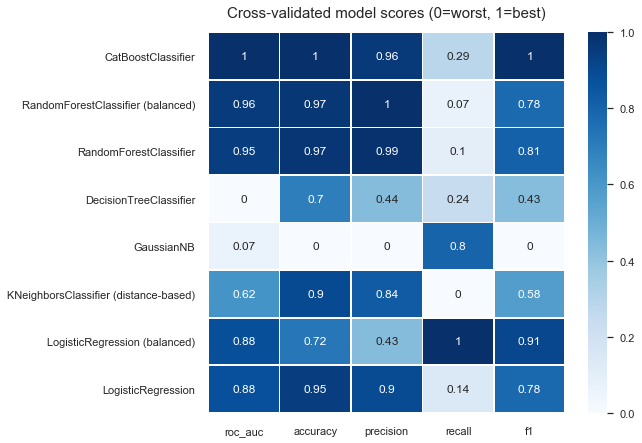

In [135]:
scaler = MinMaxScaler()
df_scores_scaled = scaler.fit_transform(df_scores)
df_scores_scaled = pd.DataFrame(df_scores_scaled,columns=df_scores.columns,index=df_scores.index)

fig,ax=plt.subplots(figsize=(8,7))
sns.heatmap(df_scores_scaled,cmap='Blues',annot=True,ax=ax,linewidths=0.75)
ax.set_ylim(0,8)
ax.set_title('Cross-validated model scores (0=worst, 1=best)',fontsize=15,pad=15)

In [136]:
df_scores

,roc_auc,accuracy,precision,recall,f1
LogisticRegression,87.08,85.10,73.68,51.04,60.28
LogisticRegression (balanced),87.15,79.73,52.94,76.91,62.71
KNeighborsClassifier (distance-based),82.07,83.95,70.88,46.80,56.37
GaussianNB,71.60,62.37,33.50,70.91,45.50
DecisionTreeClassifier,70.26,79.23,53.06,54.16,53.60
RandomForestClassifier,88.46,85.73,77.81,49.84,60.74
RandomForestClassifier (balanced),88.61,85.66,78.24,48.92,60.19
CatBoostClassifier,89.44,86.38,76.62,55.47,64.34


In [137]:
model = CatBoostClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.065344
0:	learn: 0.6484165	total: 30.4ms	remaining: 30.4s
1:	learn: 0.6066882	total: 52.6ms	remaining: 26.3s
2:	learn: 0.5716777	total: 78ms	remaining: 25.9s
3:	learn: 0.5423214	total: 103ms	remaining: 25.7s
4:	learn: 0.5167090	total: 128ms	remaining: 25.5s
5:	learn: 0.4959341	total: 152ms	remaining: 25.2s
6:	learn: 0.4771751	total: 173ms	remaining: 24.5s
7:	learn: 0.4622131	total: 213ms	remaining: 26.4s
8:	learn: 0.4482987	total: 240ms	remaining: 26.4s
9:	learn: 0.4377002	total: 264ms	remaining: 26.2s
10:	learn: 0.4275354	total: 286ms	remaining: 25.7s
11:	learn: 0.4187461	total: 312ms	remaining: 25.7s
12:	learn: 0.4114602	total: 339ms	remaining: 25.8s
13:	learn: 0.4054342	total: 364ms	remaining: 25.7s
14:	learn: 0.4001185	total: 387ms	remaining: 25.4s
15:	learn: 0.3958180	total: 414ms	remaining: 25.4s
16:	learn: 0.3920637	total: 455ms	remaining: 26.3s
17:	learn: 0.3880556	total: 480ms	remaining: 26.2s
18:	learn: 0.3846804	total: 502ms	remaining: 25.9s
19:	learn:

161:	learn: 0.3283455	total: 5.85s	remaining: 30.3s
162:	learn: 0.3281940	total: 5.88s	remaining: 30.2s
163:	learn: 0.3280988	total: 5.9s	remaining: 30.1s
164:	learn: 0.3279878	total: 5.93s	remaining: 30s
165:	learn: 0.3278520	total: 5.95s	remaining: 29.9s
166:	learn: 0.3277460	total: 5.98s	remaining: 29.8s
167:	learn: 0.3276365	total: 6s	remaining: 29.7s
168:	learn: 0.3275024	total: 6.03s	remaining: 29.7s
169:	learn: 0.3273810	total: 6.07s	remaining: 29.6s
170:	learn: 0.3272583	total: 6.1s	remaining: 29.6s
171:	learn: 0.3271184	total: 6.13s	remaining: 29.5s
172:	learn: 0.3270288	total: 6.15s	remaining: 29.4s
173:	learn: 0.3269080	total: 6.18s	remaining: 29.3s
174:	learn: 0.3267543	total: 6.21s	remaining: 29.3s
175:	learn: 0.3265968	total: 6.24s	remaining: 29.2s
176:	learn: 0.3264735	total: 6.28s	remaining: 29.2s
177:	learn: 0.3263418	total: 6.32s	remaining: 29.2s
178:	learn: 0.3262084	total: 6.34s	remaining: 29.1s
179:	learn: 0.3260987	total: 6.37s	remaining: 29s
180:	learn: 0.3259703

321:	learn: 0.3091455	total: 11.3s	remaining: 23.8s
322:	learn: 0.3090554	total: 11.3s	remaining: 23.7s
323:	learn: 0.3089757	total: 11.4s	remaining: 23.7s
324:	learn: 0.3088679	total: 11.4s	remaining: 23.6s
325:	learn: 0.3087669	total: 11.4s	remaining: 23.6s
326:	learn: 0.3086996	total: 11.4s	remaining: 23.5s
327:	learn: 0.3086317	total: 11.5s	remaining: 23.5s
328:	learn: 0.3085404	total: 11.5s	remaining: 23.4s
329:	learn: 0.3084278	total: 11.5s	remaining: 23.4s
330:	learn: 0.3083136	total: 11.5s	remaining: 23.3s
331:	learn: 0.3082318	total: 11.6s	remaining: 23.3s
332:	learn: 0.3081143	total: 11.6s	remaining: 23.2s
333:	learn: 0.3080140	total: 11.6s	remaining: 23.2s
334:	learn: 0.3079147	total: 11.6s	remaining: 23.1s
335:	learn: 0.3078224	total: 11.7s	remaining: 23.1s
336:	learn: 0.3077164	total: 11.7s	remaining: 23s
337:	learn: 0.3076297	total: 11.7s	remaining: 23s
338:	learn: 0.3075330	total: 11.8s	remaining: 22.9s
339:	learn: 0.3074387	total: 11.8s	remaining: 22.9s
340:	learn: 0.30

481:	learn: 0.2957228	total: 15.6s	remaining: 16.7s
482:	learn: 0.2956081	total: 15.6s	remaining: 16.7s
483:	learn: 0.2955209	total: 15.6s	remaining: 16.7s
484:	learn: 0.2954452	total: 15.6s	remaining: 16.6s
485:	learn: 0.2953730	total: 15.7s	remaining: 16.6s
486:	learn: 0.2952901	total: 15.7s	remaining: 16.5s
487:	learn: 0.2952241	total: 15.7s	remaining: 16.5s
488:	learn: 0.2951556	total: 15.7s	remaining: 16.5s
489:	learn: 0.2950763	total: 15.8s	remaining: 16.4s
490:	learn: 0.2950000	total: 15.8s	remaining: 16.4s
491:	learn: 0.2949030	total: 15.8s	remaining: 16.3s
492:	learn: 0.2948380	total: 15.9s	remaining: 16.3s
493:	learn: 0.2947588	total: 15.9s	remaining: 16.3s
494:	learn: 0.2946827	total: 15.9s	remaining: 16.2s
495:	learn: 0.2946078	total: 15.9s	remaining: 16.2s
496:	learn: 0.2945458	total: 16s	remaining: 16.2s
497:	learn: 0.2944788	total: 16s	remaining: 16.1s
498:	learn: 0.2944230	total: 16s	remaining: 16.1s
499:	learn: 0.2943361	total: 16.1s	remaining: 16.1s
500:	learn: 0.2942

645:	learn: 0.2845466	total: 21.2s	remaining: 11.6s
646:	learn: 0.2844700	total: 21.3s	remaining: 11.6s
647:	learn: 0.2844079	total: 21.3s	remaining: 11.6s
648:	learn: 0.2843418	total: 21.3s	remaining: 11.5s
649:	learn: 0.2842887	total: 21.4s	remaining: 11.5s
650:	learn: 0.2842169	total: 21.4s	remaining: 11.5s
651:	learn: 0.2841483	total: 21.4s	remaining: 11.4s
652:	learn: 0.2841015	total: 21.4s	remaining: 11.4s
653:	learn: 0.2840244	total: 21.5s	remaining: 11.4s
654:	learn: 0.2839925	total: 21.5s	remaining: 11.3s
655:	learn: 0.2839285	total: 21.6s	remaining: 11.3s
656:	learn: 0.2838625	total: 21.6s	remaining: 11.3s
657:	learn: 0.2838146	total: 21.6s	remaining: 11.2s
658:	learn: 0.2837554	total: 21.6s	remaining: 11.2s
659:	learn: 0.2837072	total: 21.7s	remaining: 11.2s
660:	learn: 0.2836672	total: 21.7s	remaining: 11.1s
661:	learn: 0.2835758	total: 21.7s	remaining: 11.1s
662:	learn: 0.2835131	total: 21.8s	remaining: 11.1s
663:	learn: 0.2834733	total: 21.8s	remaining: 11s
664:	learn: 0.

804:	learn: 0.2752956	total: 25.6s	remaining: 6.19s
805:	learn: 0.2752281	total: 25.6s	remaining: 6.16s
806:	learn: 0.2751479	total: 25.6s	remaining: 6.13s
807:	learn: 0.2751000	total: 25.6s	remaining: 6.09s
808:	learn: 0.2750648	total: 25.7s	remaining: 6.06s
809:	learn: 0.2750288	total: 25.7s	remaining: 6.03s
810:	learn: 0.2749663	total: 25.7s	remaining: 5.99s
811:	learn: 0.2749100	total: 25.7s	remaining: 5.96s
812:	learn: 0.2748547	total: 25.8s	remaining: 5.93s
813:	learn: 0.2748159	total: 25.8s	remaining: 5.9s
814:	learn: 0.2747744	total: 25.8s	remaining: 5.86s
815:	learn: 0.2747158	total: 25.9s	remaining: 5.83s
816:	learn: 0.2746506	total: 25.9s	remaining: 5.8s
817:	learn: 0.2745839	total: 25.9s	remaining: 5.76s
818:	learn: 0.2745380	total: 25.9s	remaining: 5.73s
819:	learn: 0.2744921	total: 26s	remaining: 5.7s
820:	learn: 0.2744478	total: 26s	remaining: 5.67s
821:	learn: 0.2743979	total: 26s	remaining: 5.64s
822:	learn: 0.2743350	total: 26.1s	remaining: 5.61s
823:	learn: 0.2742814

965:	learn: 0.2666415	total: 31s	remaining: 1.09s
966:	learn: 0.2666053	total: 31.1s	remaining: 1.06s
967:	learn: 0.2665692	total: 31.2s	remaining: 1.03s
968:	learn: 0.2665356	total: 31.3s	remaining: 1s
969:	learn: 0.2664534	total: 31.3s	remaining: 969ms
970:	learn: 0.2664011	total: 31.4s	remaining: 937ms
971:	learn: 0.2663634	total: 31.4s	remaining: 905ms
972:	learn: 0.2663019	total: 31.4s	remaining: 872ms
973:	learn: 0.2662493	total: 31.5s	remaining: 840ms
974:	learn: 0.2662036	total: 31.5s	remaining: 808ms
975:	learn: 0.2661597	total: 31.5s	remaining: 775ms
976:	learn: 0.2661183	total: 31.6s	remaining: 743ms
977:	learn: 0.2660791	total: 31.6s	remaining: 711ms
978:	learn: 0.2660200	total: 31.6s	remaining: 678ms
979:	learn: 0.2659712	total: 31.7s	remaining: 646ms
980:	learn: 0.2659201	total: 31.7s	remaining: 614ms
981:	learn: 0.2658578	total: 31.7s	remaining: 582ms
982:	learn: 0.2658038	total: 31.8s	remaining: 549ms
983:	learn: 0.2657625	total: 31.8s	remaining: 517ms
984:	learn: 0.265

In [139]:
print(f'roc_auc: {round(roc_auc_score(y_test,y_pred)*100,2)}%')
print(f'accuracy: {round(accuracy_score(y_test,y_pred)*100,2)}%')
print(f'precision: {round(precision_score(y_test,y_pred)*100,2)}%')
print(f'recall: {round(recall_score(y_test,y_pred)*100,2)}%')
print(f'f1: {round(f1_score(y_test,y_pred)*100,2)}%')

roc_auc: 75.56%
accuracy: 86.55%
precision: 77.13%
recall: 55.83%
f1: 64.77%


In [138]:
confusion_matrix(y_test,y_pred)

array([[27643,  1367],
       [ 3647,  4609]])

# Bonus: hyperparameters tuning (without clustering)

In [140]:
model = RandomForestClassifier()
params = {'n_estimators':range(100,1250,50),
          'criterion':['gini','entropy'],
          'max_features':['sqrt','log2',None],
          'class_weight':['balanced',None]}

#Define the CV strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

#Integrate the CV strategy into the SearchGrid
search = RandomizedSearchCV(estimator=model, param_distributions=params,
                            scoring='precision', n_jobs=-1, cv=cv, n_iter=10)
best_model = search.fit(X_train,y_train)

In [141]:
best_model.best_score_

0.7913797651678701

In [142]:
best_model.best_params_

{'n_estimators': 450,
 'max_features': 'log2',
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [ ]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)

In [ ]:
print(f'roc_auc: {round(roc_auc_score(y_test,y_pred)*100,2)}%')
print(f'accuracy: {round(accuracy_score(y_test,y_pred)*100,2)}%')
print(f'precision: {round(precision_score(y_test,y_pred)*100,2)}%')
print(f'recall: {round(recall_score(y_test,y_pred)*100,2)}%')
print(f'f1: {round(f1_score(y_test,y_pred)*100,2)}%')